In [1]:
import os
from pathlib import Path

from adex.helpers import get_pre_processed_dataset
from adex.models import Condition, TISSUE_COLORS, ConditionDataLoader, TissueEnum, ConditionTissueDataLoader, \
    FileDataLoader
from adex.models import METADATA_COLUMNS
from adex.pca import PcaHelper

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = 20

files_path = "../data/adex-database/samples"
metadata_path = "../data/adex-database/metadata.tsv"

# Experiment with PCA for the RA dataset

In [3]:
ra_dataset = get_pre_processed_dataset(ConditionDataLoader(Condition.RA), files_path, metadata_path)
ra_dataset.head()

shape: (5, 28_671)
┌────────────┬─────────────┬─────────────┬────────────┬───┬───────────┬────────┬───────┬───────────┐
│ Sample     ┆ RFC2        ┆ HSPA6       ┆ PAX8       ┆ … ┆ Cell Type ┆ Gender ┆ Age   ┆ Ethnicity │
│ ---        ┆ ---         ┆ ---         ┆ ---        ┆   ┆ ---       ┆ ---    ┆ ---   ┆ ---       │
│ str        ┆ str         ┆ str         ┆ str        ┆   ┆ str       ┆ str    ┆ str   ┆ str       │
╞════════════╪═════════════╪═════════════╪════════════╪═══╪═══════════╪════════╪═══════╪═══════════╡
│ GSM2371169 ┆ 8.720859109 ┆ 7.440205905 ┆ 6.56033693 ┆ … ┆ null      ┆ Female ┆ 21-30 ┆ null      │
│            ┆ 15261       ┆ 89512       ┆ 470826     ┆   ┆           ┆        ┆       ┆           │
│ GSM2981145 ┆ 5.299633649 ┆ 8.490514199 ┆ null       ┆ … ┆ null      ┆ Female ┆ null  ┆ null      │
│            ┆ 23009       ┆ 99837       ┆            ┆   ┆           ┆        ┆       ┆           │
│ GSM1366368 ┆ 6.082120060 ┆ 6.493565936 ┆ 6.01927254 ┆ … ┆ T cells   ┆ null   ┆ null  ┆ null      │
│            ┆ 93722       ┆ 61283       ┆ 670901     ┆   ┆           ┆        ┆       ┆           │
│ GSM2371086 ┆ 9.178125620 ┆ 8.512024614 ┆ 7.94224441 ┆ … ┆ null      ┆ Female ┆ 61-70 ┆ null      │
│            ┆ 74164       ┆ 45607       ┆ 54971      ┆   ┆           ┆        ┆       ┆           │
│ GSM2371177 ┆ 8.334822006 ┆ 7.647415731 ┆ 5.58315139 ┆ … ┆ null      ┆ Female ┆ 51-60 ┆ null      │
│            ┆ 73517       ┆ 58322       ┆ 402881     ┆   ┆           ┆        ┆       ┆           │
└────────────┴─────────────┴─────────────┴────────────┴───┴───────────┴────────┴───────┴───────────┘

In [4]:
ra_dataset.shape

(1122, 28671)

In [34]:
ra_dataset_only_features_pandas = ra_dataset.drop("Sample").drop(METADATA_COLUMNS).to_pandas()
ra_dataset_only_features_pandas.head()

RFC2             HSPA6              PAX8 GUCA1A  \
0  7.75739829813776  8.52766470234738  12.0247096740962   None   
1  5.86378282525108  9.17891725204084              None   None   
2  6.81450974822409  10.5182378606535  5.23140335940967   None   
3   5.8252541496269  8.83884567930569              None   None   
4  8.54304591813182  8.76262430166783  8.35050162518401   None   

               THRA PTPN21              CCL5            CYP2E1  \
0   13.072810860834   None  6.63148464434766  7.73910524744137   
1  4.79329596009568   None  9.45987648854357              None   
2  6.23498328552953   None  9.62859072110941  5.12513378222151   
3  4.90853350313439   None  9.50592690753674              None   
4  9.09363627164442   None  9.96827897632932   6.0353961360876   

              EPHB3             ESRRA  ...            FKSG43  \
0  8.98893563126459  11.2772387002576  ...              None   
1              None  7.48290690329661  ...  6.37270149042415   
2  5.82987671757113  6.61559095684279  ...              None   
3              None  7.79198116445788  ...  6.56867536474153   
4   7.2733946704924   9.1424578464743  ...              None   

          LOC644006         LOC728734         LOC729992      LOC100289068  \
0              None              None              None              None   
1  5.87374954917958  6.50824493604356  7.45233584577288  8.61473561190469   
2              None              None              None              None   
3  6.37634630383182  7.42710926196682  7.56851454169455  8.43915645280532   
4              None              None              None              None   

          LOC646817      LOC100294318         LOC643446          FLJ45340  \
0              None              None              None              None   
1  7.33731215662702  4.92587409785953  9.96036776991519  7.02890930159431   
2              None              None              None              None   
3  6.92253481999061  4.77069381439922  10.1691226753353  7.39376138620086   
4              None              None              None              None   

          LOC399940  
0              None  
1  4.59283918512803  
2              None  
3  5.41472375478337  
4              None  

[5 rows x 28661 columns]

In [35]:
ra_dataset_values = ra_dataset_only_features_pandas.values
ra_dataset_values

array([['7.75739829813776', '8.52766470234738', '12.0247096740962', ...,
        None, None, None],
       ['5.86378282525108', '9.17891725204084', None, ...,
        '9.96036776991519', '7.02890930159431', '4.59283918512803'],
       ['6.81450974822409', '10.5182378606535', '5.23140335940967', ...,
        None, None, None],
       ...,
       ['6.56513705073542', '9.17370636057311', None, ...,
        '10.3884138327186', '7.78639262933053', '2.68069579232116'],
       ['7.05696489105768', '10.9707721837119', '5.86402767033066', ...,
        None, None, None],
       ['5.87323046482264', '9.59344388457426', None, ...,
        '9.97042826124807', '7.75501399299634', '3.40074611515084']],
      dtype=object)

In [36]:
ra_dataset_normalized_values = StandardScaler().fit_transform(ra_dataset_values) # normalizing the features
ra_dataset_normalized_values

array([[ 7.83809558e-01, -6.75641033e-01,  4.24068704e+00, ...,
                    nan,             nan,             nan],
       [-1.44719916e+00, -2.61662044e-01,             nan, ...,
        -1.03931955e+00, -9.04814524e-01,  1.53025342e-01],
       [-3.27077316e-01,  5.89698295e-01, -5.33943221e-01, ...,
                    nan,             nan,             nan],
       ...,
       [-6.20881770e-01, -2.64974430e-01,             nan, ...,
         7.44903521e-01,  5.94293603e-01, -1.36959694e+00],
       [-4.14229448e-02,  8.77358899e-01, -8.93074225e-02, ...,
                    nan,             nan,             nan],
       [-1.43606819e+00,  1.83836953e-03,             nan, ...,
        -9.97384440e-01,  5.32193268e-01, -7.96227458e-01]])

In [37]:
ra_dataset_normalized_values.shape

(1122, 28661)

In [38]:
# Check whether the normalized data has a mean of zero and a standard deviation of one! 
np.nanmean(ra_dataset_normalized_values), np.nanstd(ra_dataset_normalized_values)

(-2.8336210516514364e-19, 0.9999999999999986)

In [39]:
ra_dataset_normalized_pandas = pd.DataFrame(ra_dataset_normalized_values)
ra_dataset_normalized_pandas

0         1         2      3         4      5         6      \
0     0.783810 -0.675641  4.240687    NaN  4.071204    NaN -1.548145   
1    -1.447199 -0.261662       NaN    NaN -1.161785    NaN  0.367436   
2    -0.327077  0.589698 -0.533943    NaN -0.250580    NaN  0.481701   
3    -1.492593 -0.477834       NaN    NaN -1.088950    NaN  0.398625   
4     1.709439 -0.526285  1.658294    NaN  1.556205    NaN  0.711761   
...        ...       ...       ...    ...       ...    ...       ...   
1117 -0.943170 -0.328024       NaN    NaN -0.894869    NaN  0.287291   
1118  0.023319  0.457965 -0.647920    NaN -0.244284    NaN -0.062106   
1119 -0.620882 -0.264974       NaN    NaN -0.704238    NaN  0.408295   
1120 -0.041423  0.877359 -0.089307    NaN -0.279893    NaN  0.486308   
1121 -1.436068  0.001838       NaN    NaN -1.310371    NaN -1.011526   

         7         8         9      ...     28651     28652     28653  \
0     2.744937  2.463824  4.203364  ...       NaN       NaN       NaN   
1          NaN       NaN  0.201704  ... -0.367089 -1.639230 -0.086919   
2    -0.275772 -0.123158 -0.713004  ...       NaN       NaN       NaN   
3          NaN       NaN  0.527666  ...  0.403140  0.000518  0.839735   
4     0.776128  1.058952  1.951935  ...       NaN       NaN       NaN   
...        ...       ...       ...  ...       ...       ...       ...   
1117       NaN       NaN  0.158966  ... -1.328744 -1.422343  0.771585   
1118 -0.575565 -0.635412 -0.521927  ...       NaN       NaN       NaN   
1119       NaN       NaN  0.837273  ...  1.499915  0.660501 -1.365850   
1120  0.022568 -0.186747 -0.571556  ...       NaN       NaN       NaN   
1121       NaN       NaN  0.293100  ... -1.838687 -1.586121 -1.744137   

         28654     28655     28656     28657     28658     28659     28660  
0          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1    -1.677445  0.612164 -0.473872 -0.290412 -1.039320 -0.904815  0.153025  
2          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
3    -1.454184 -0.145446 -1.334181 -0.746672 -0.169167 -0.182749  0.807485  
4          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
...        ...       ...       ...       ...       ...       ...       ...  
1117  0.123285  1.344357  0.412555 -0.125112  0.030519 -0.219907 -0.644762  
1118       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1119  0.752791 -0.591040  1.073350 -0.040014  0.744904  0.594294 -1.369597  
1120       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1121  0.142008  0.877052  0.227606 -1.450421 -0.997384  0.532193 -0.796227  

[1122 rows x 28661 columns]

In [40]:
pca = PCA(n_components=2)
ra_pca = pca.fit_transform(ra_dataset_normalized_pandas.fillna(0))

In [41]:
ra_pca_pandas = pd.DataFrame(
    data = ra_pca, 
    columns = ['PC1', 'PC2']
)

In [42]:
ra_pca_pandas.head()

PC1        PC2
0  146.391258 -28.492164
1  -34.700872  55.691437
2  -45.407794 -28.725868
3  -31.422888  50.917129
4  162.136572  -8.771289

In [43]:
print(f"Explained variation per principal component: {pca.explained_variance_ratio_}")

Explained variation per principal component: [0.38808221 0.08700221]


<Figure size 640x480 with 0 Axes>

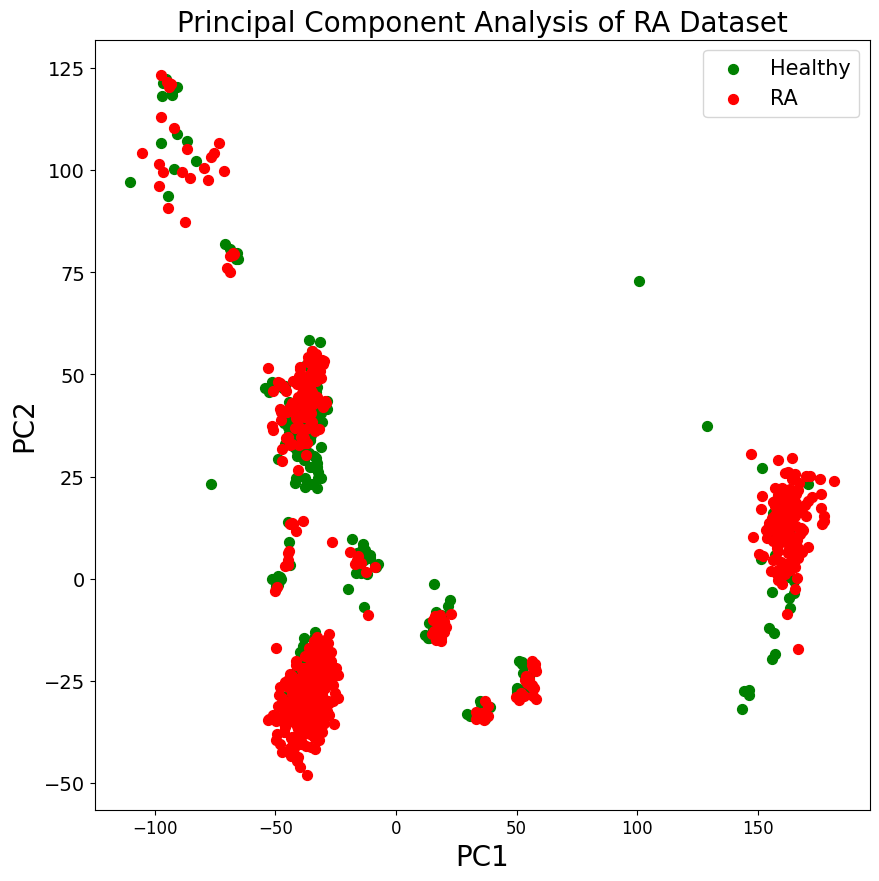

In [45]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.title("Principal Component Analysis of RA Dataset", fontsize=20)
targets = ['Healthy', 'RA']
colors = ['g', 'r']
for target, color in zip(targets, colors):
    index = ra_dataset.to_pandas()['Condition'] == target
    plt.scatter(
        ra_pca_pandas.loc[index, 'PC1'], 
        ra_pca_pandas.loc[index, 'PC2'], 
        c=color, 
        s=50
    )

plt.legend(targets, prop={'size': 15})

# PCA per condition

INFO : --- Running PCA for 'RA'---
INFO : Loaded dataset for PCA with shape: Samples(1122), Genes(28671)
INFO : Dataset normalised | Mean: '2.436310037916976e-18' Standard Deviation:'1.0000000000000007'
INFO : Explained variation per principal component: [0.38808221 0.08700221]
INFO : ----------------------------------------------
INFO : --- Running PCA for 'T1D'---
INFO : Loaded dataset for PCA with shape: Samples(176), Genes(27591)
INFO : Dataset normalised | Mean: '-4.2145813552057525e-19' Standard Deviation:'1.0000000000000002'
INFO : Explained variation per principal component: [0.25736401 0.16418631]
INFO : ----------------------------------------------
INFO : --- Running PCA for 'SSc'---
INFO : Loaded dataset for PCA with shape: Samples(229), Genes(20421)
INFO : Dataset normalised | Mean: '1.0621927001736338e-18' Standard Deviation:'1.0'
INFO : Explained variation per principal component: [0.35055071 0.1575874 ]
INFO : ----------------------------------------------
INFO : --- Ru

<Figure size 640x480 with 0 Axes>

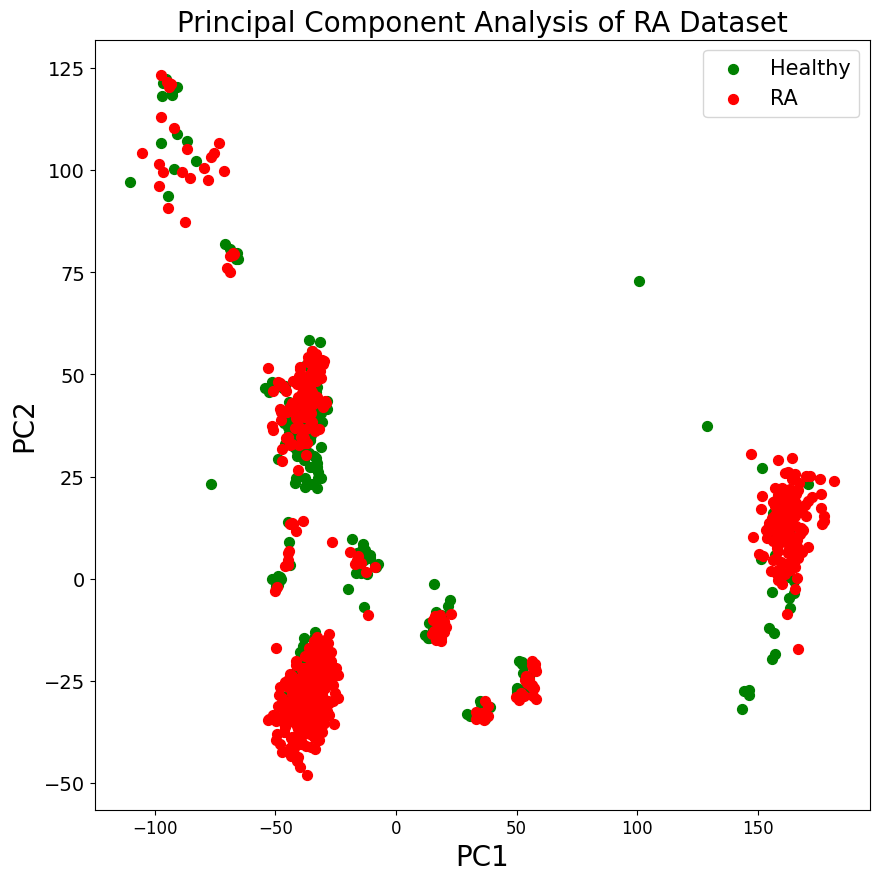

<Figure size 640x480 with 0 Axes>

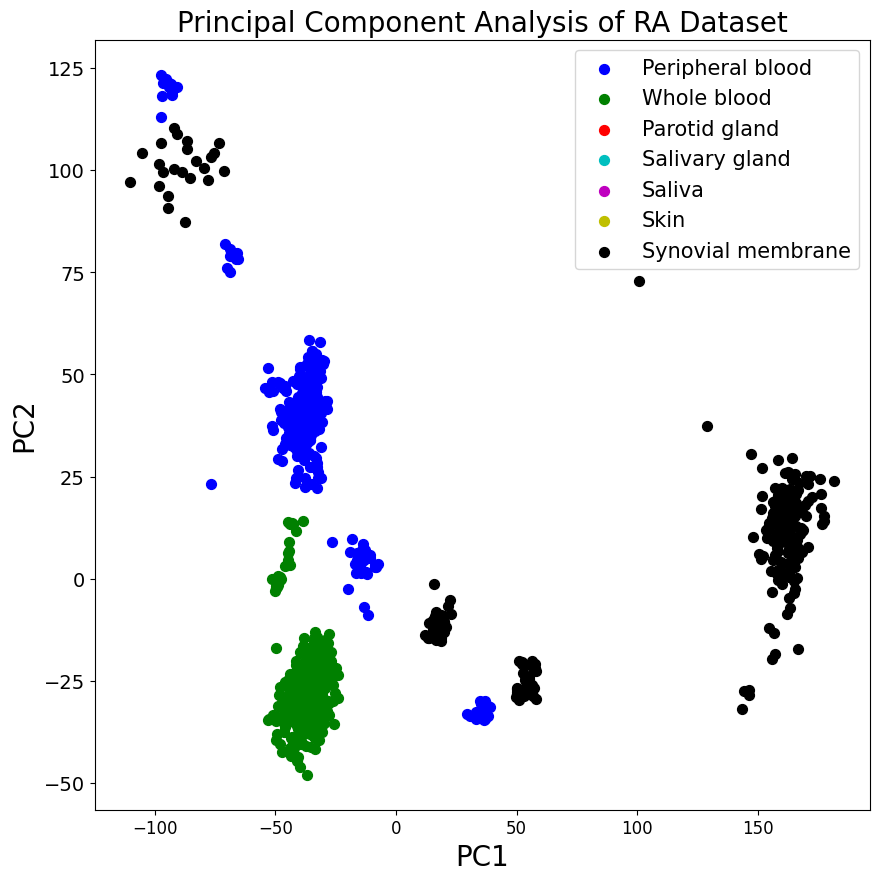

<Figure size 640x480 with 0 Axes>

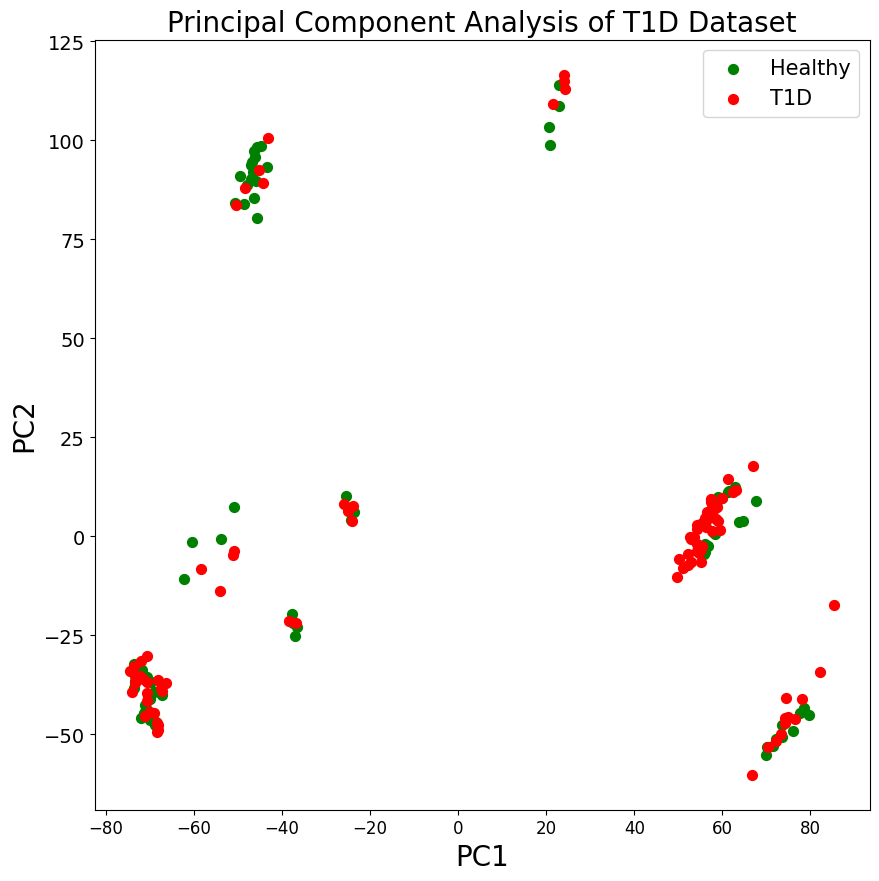

<Figure size 640x480 with 0 Axes>

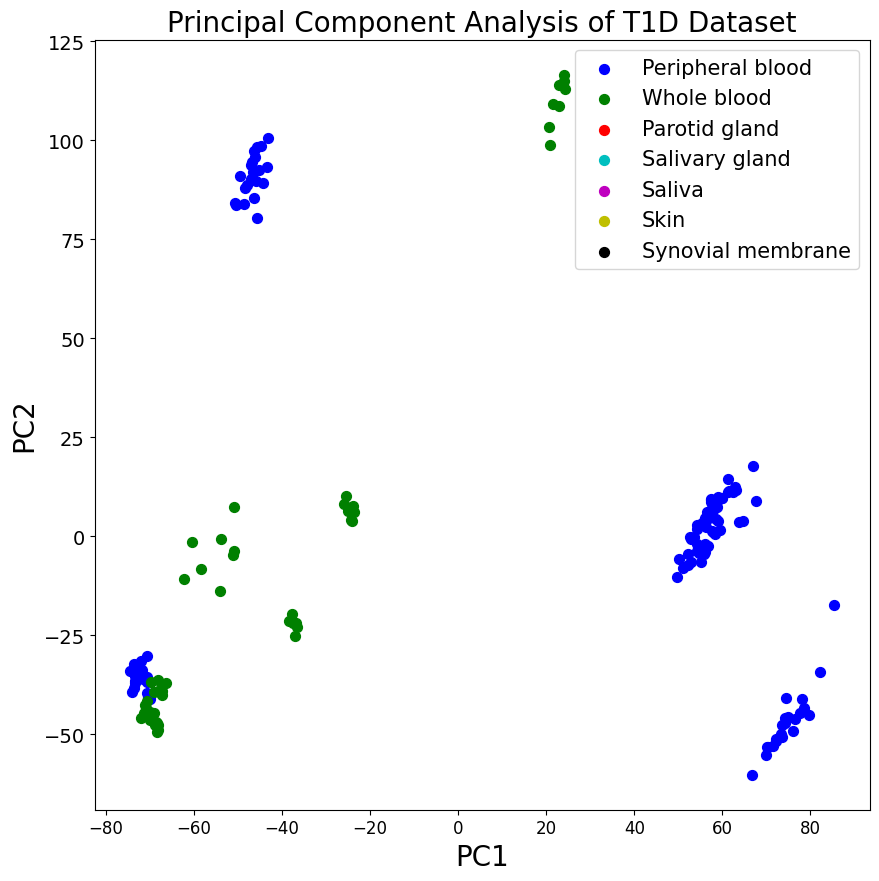

<Figure size 640x480 with 0 Axes>

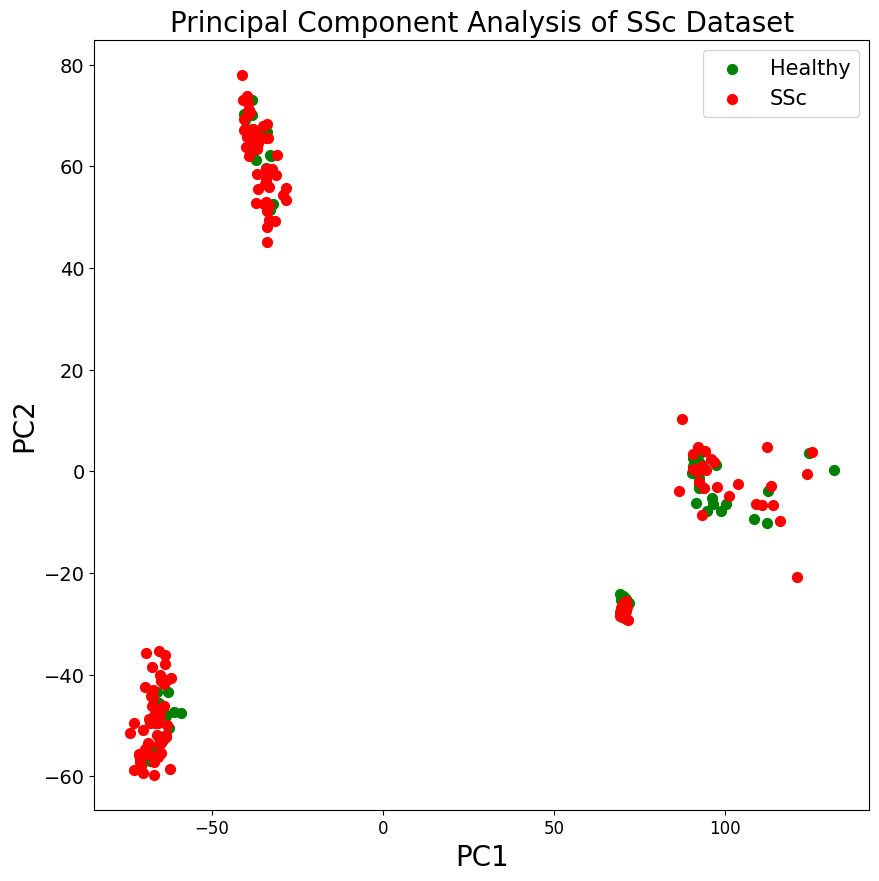

<Figure size 640x480 with 0 Axes>

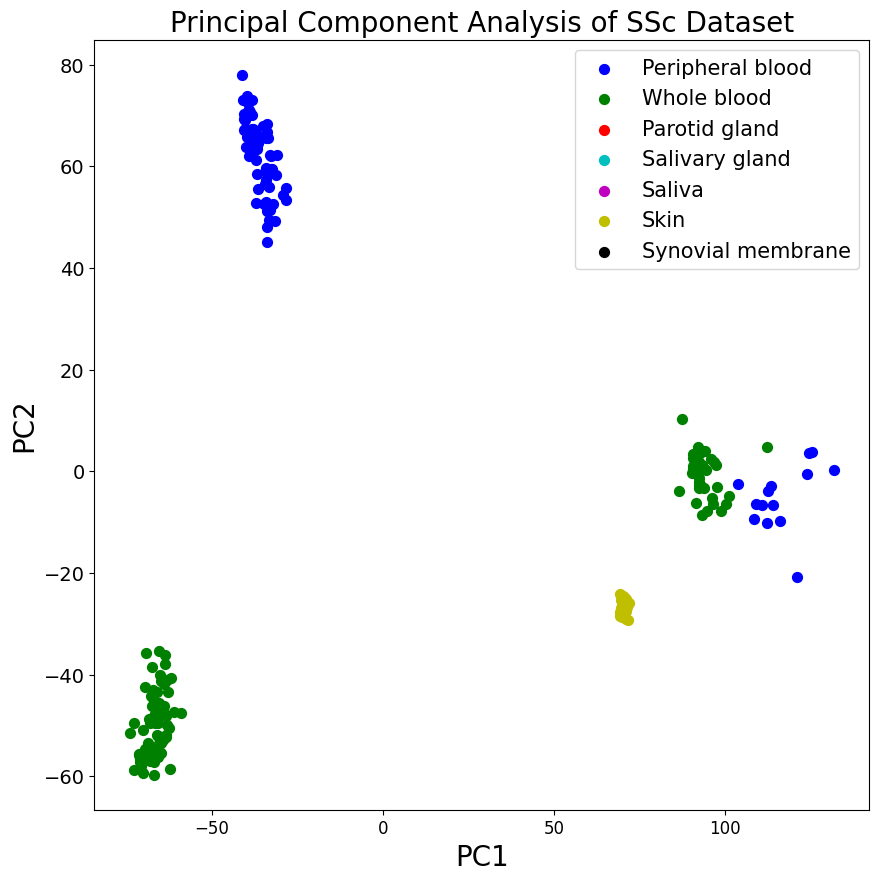

<Figure size 640x480 with 0 Axes>

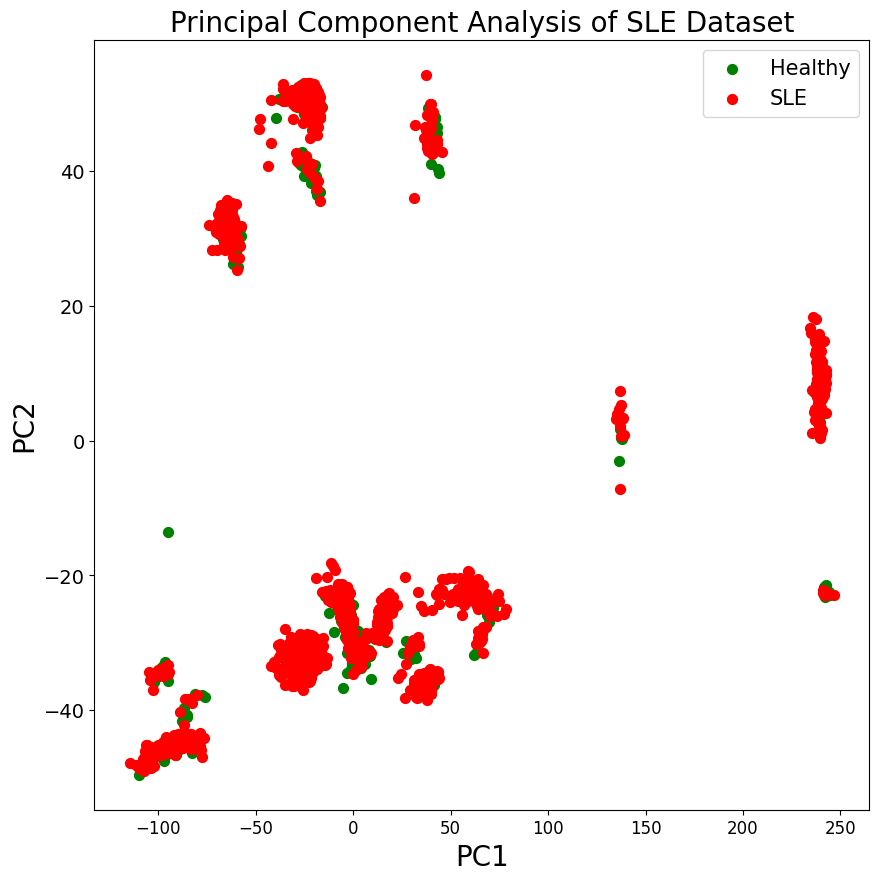

<Figure size 640x480 with 0 Axes>

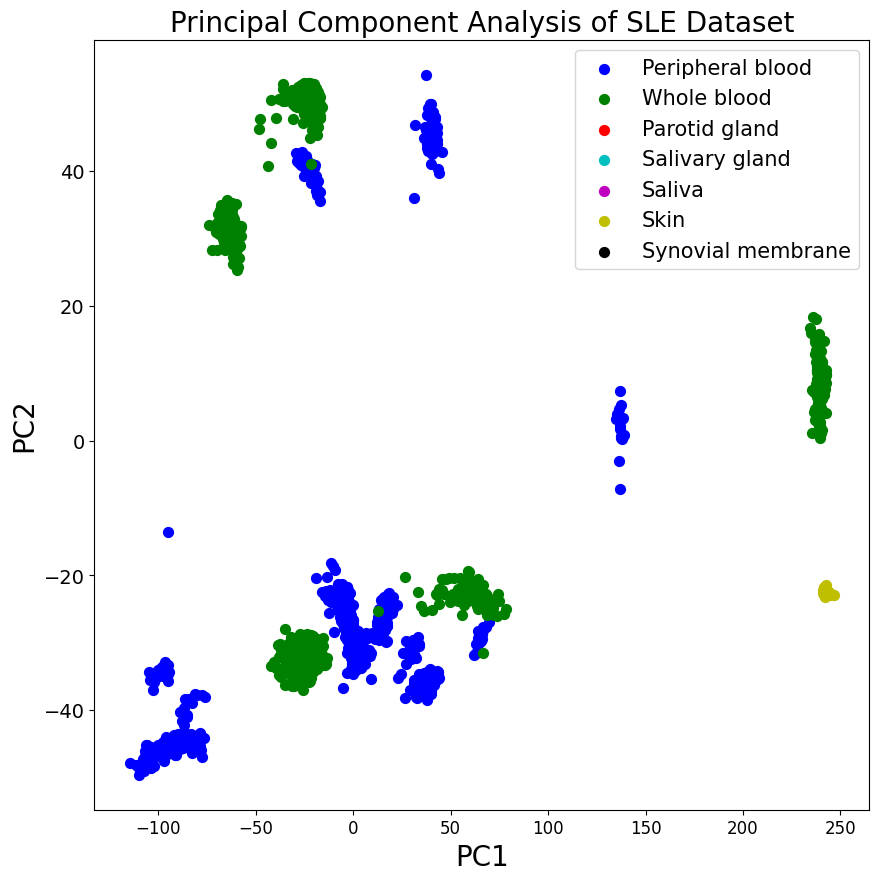

<Figure size 640x480 with 0 Axes>

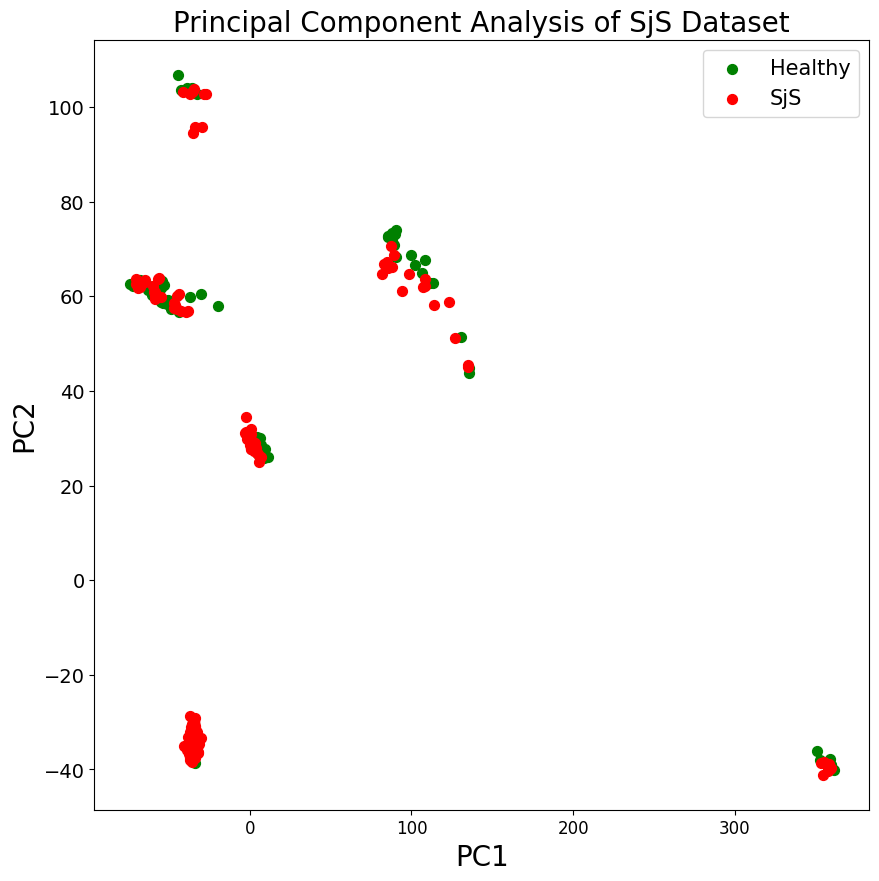

<Figure size 640x480 with 0 Axes>

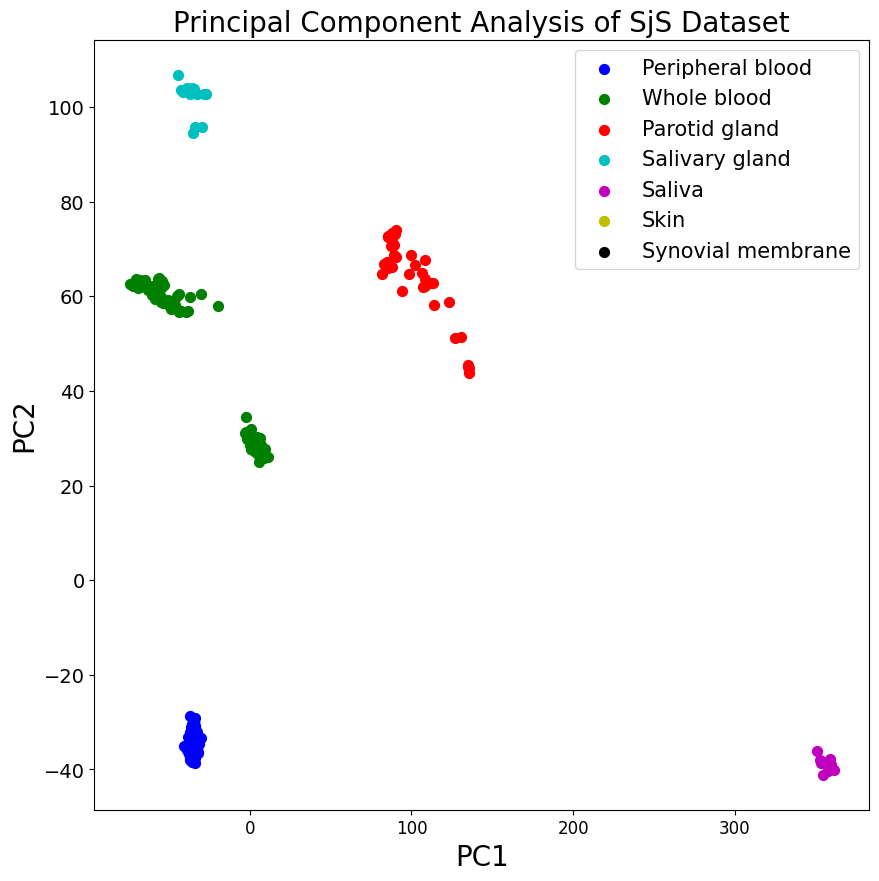

In [5]:
for condition in Condition:
    pca = PcaHelper(ConditionDataLoader(condition), files_path, metadata_path)
    pca.draw(
        column_that_defines_colors="Condition",
        target_colors=[
            ("Healthy", "g"),
            (condition.name, "r")
        ]
    )

    pca.draw(
        column_that_defines_colors="Tissue",
        target_colors=TISSUE_COLORS
    )

# PCA per Condition and Tissue

INFO : --- Running PCA for 'RA/Peripheral blood'---
INFO : Loaded dataset for PCA with shape: Samples(302), Genes(28671)
/Users/thelgis/Documents/source/applied-bioinformatics-thesis/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/thelgis/Documents/source/applied-bioinformatics-thesis/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/thelgis/Documents/source/applied-bioinformatics-thesis/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
INFO : Dataset normalised | Mean: '4.162003088219245e-18' Standard Deviation:'1.0000000000000002'
INFO : Explained variation per principal component: [0.2528477  0.22378758]
INFO : ---

<Figure size 640x480 with 0 Axes>

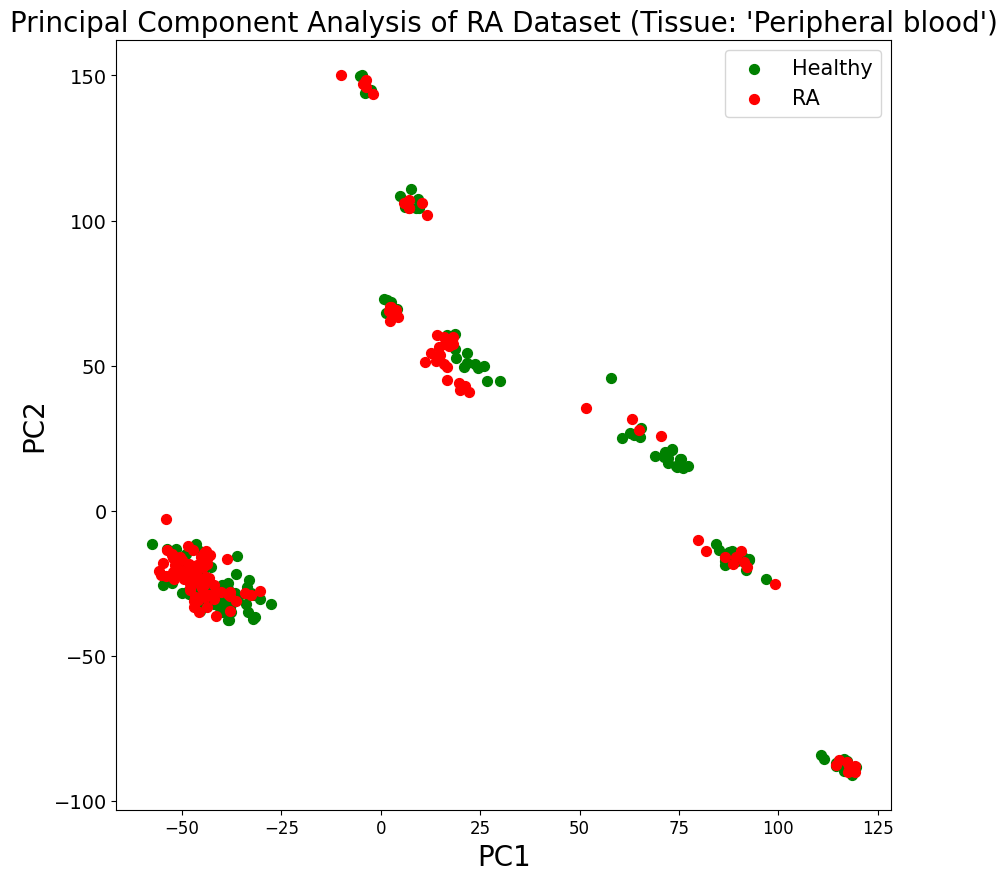

<Figure size 640x480 with 0 Axes>

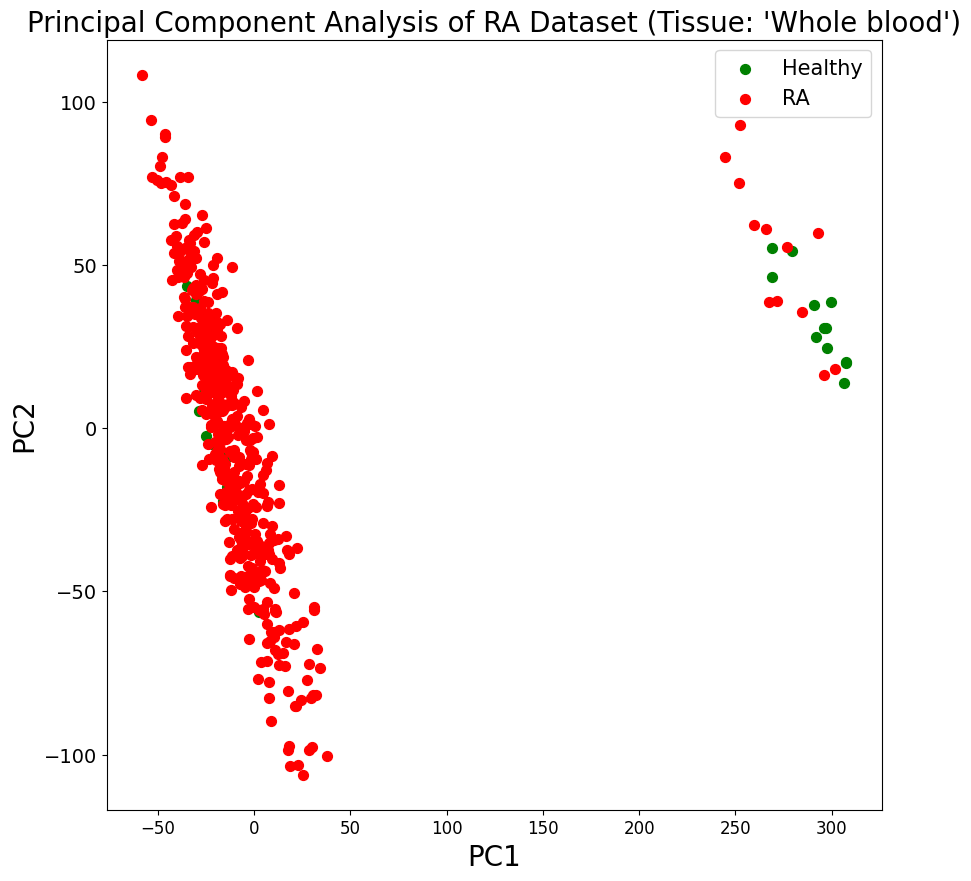

<Figure size 640x480 with 0 Axes>

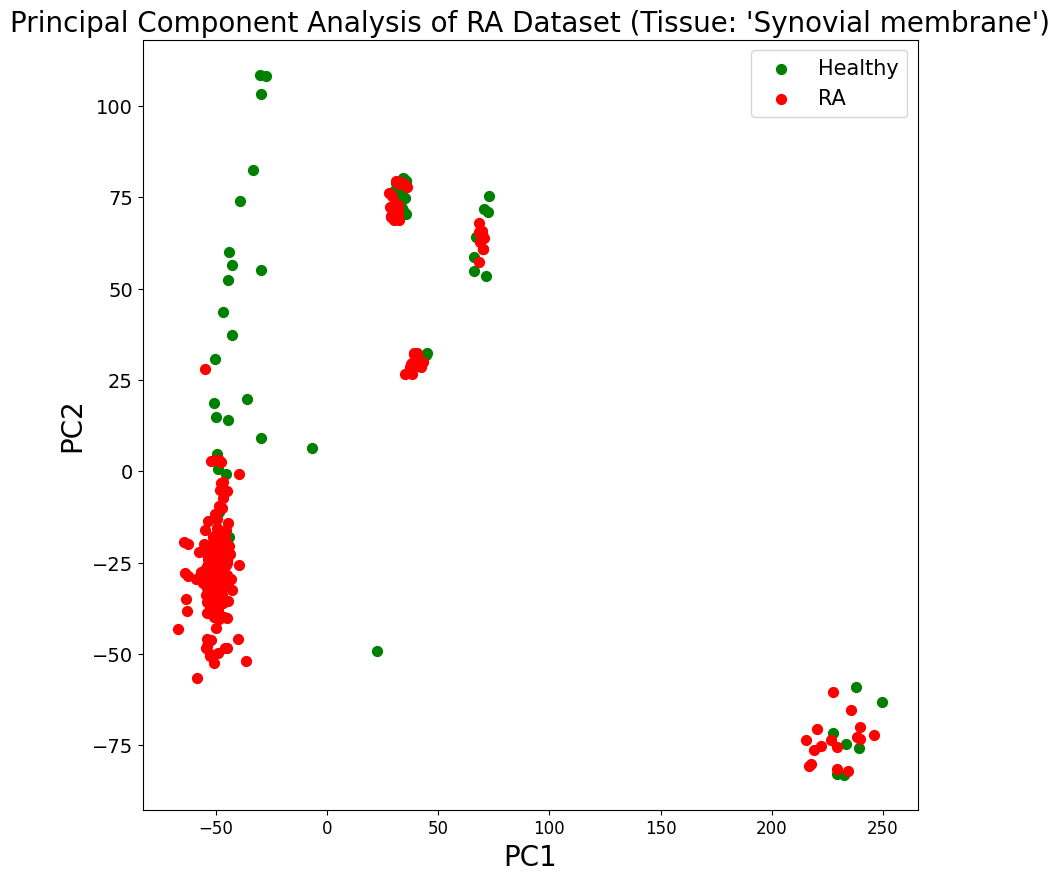

<Figure size 640x480 with 0 Axes>

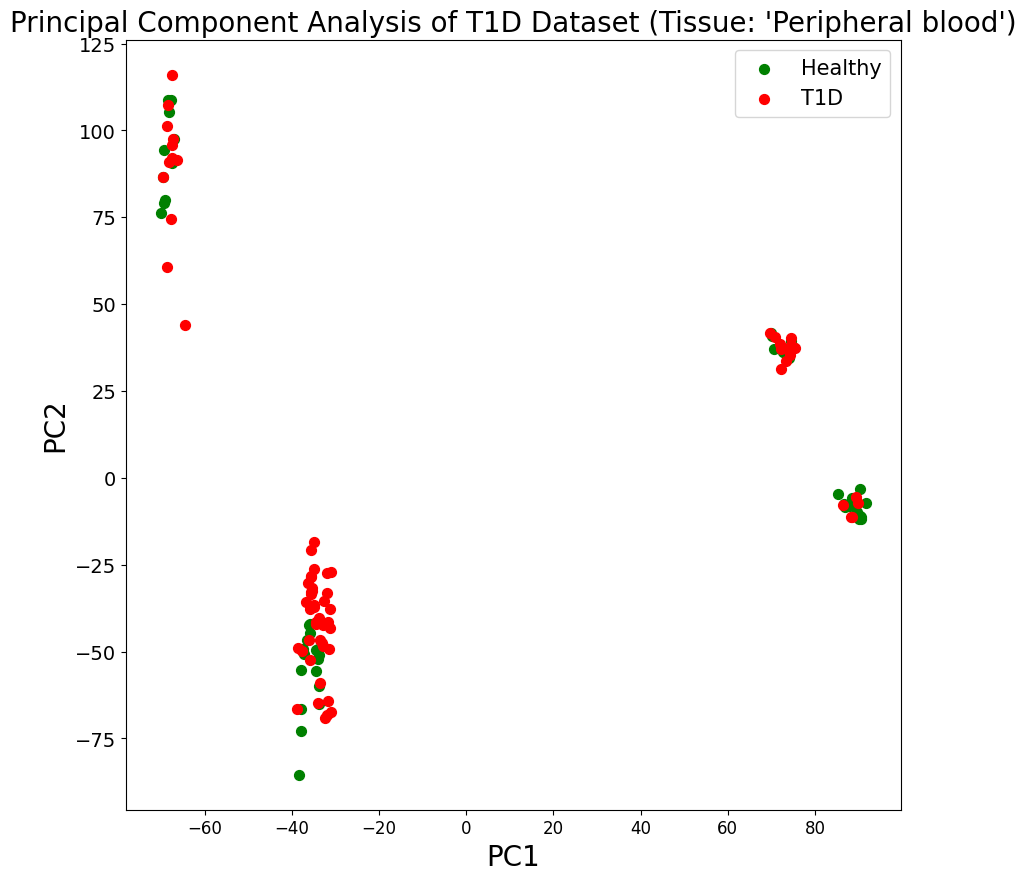

<Figure size 640x480 with 0 Axes>

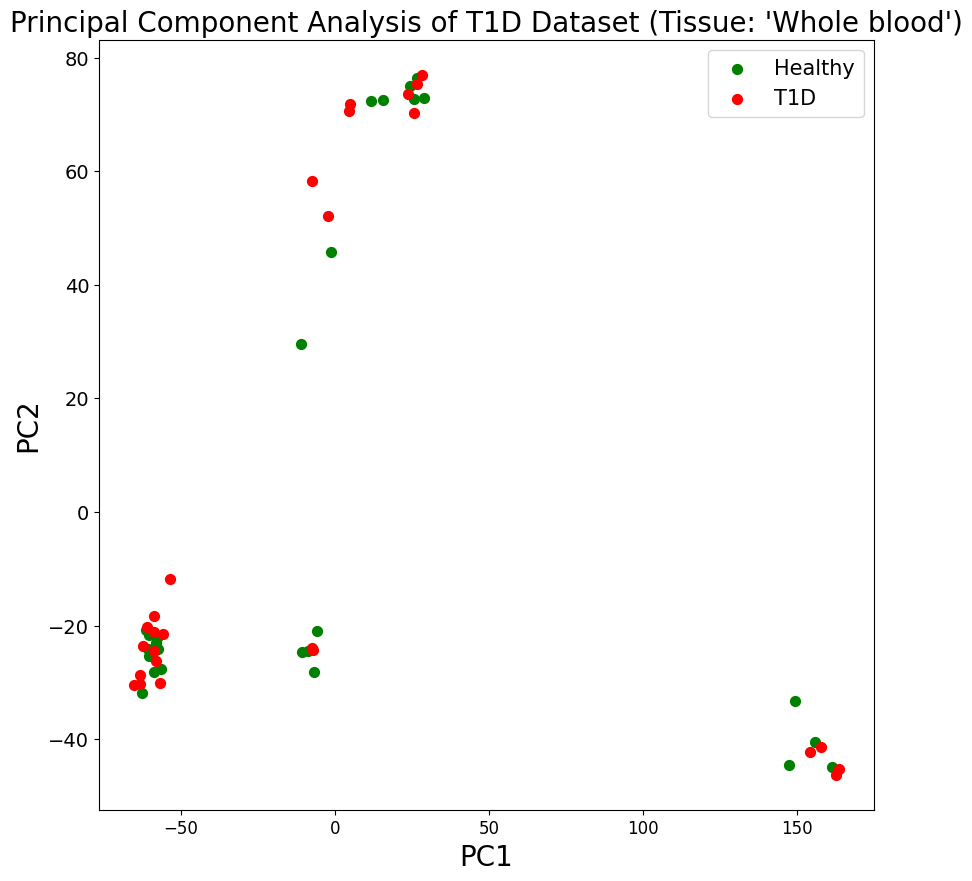

<Figure size 640x480 with 0 Axes>

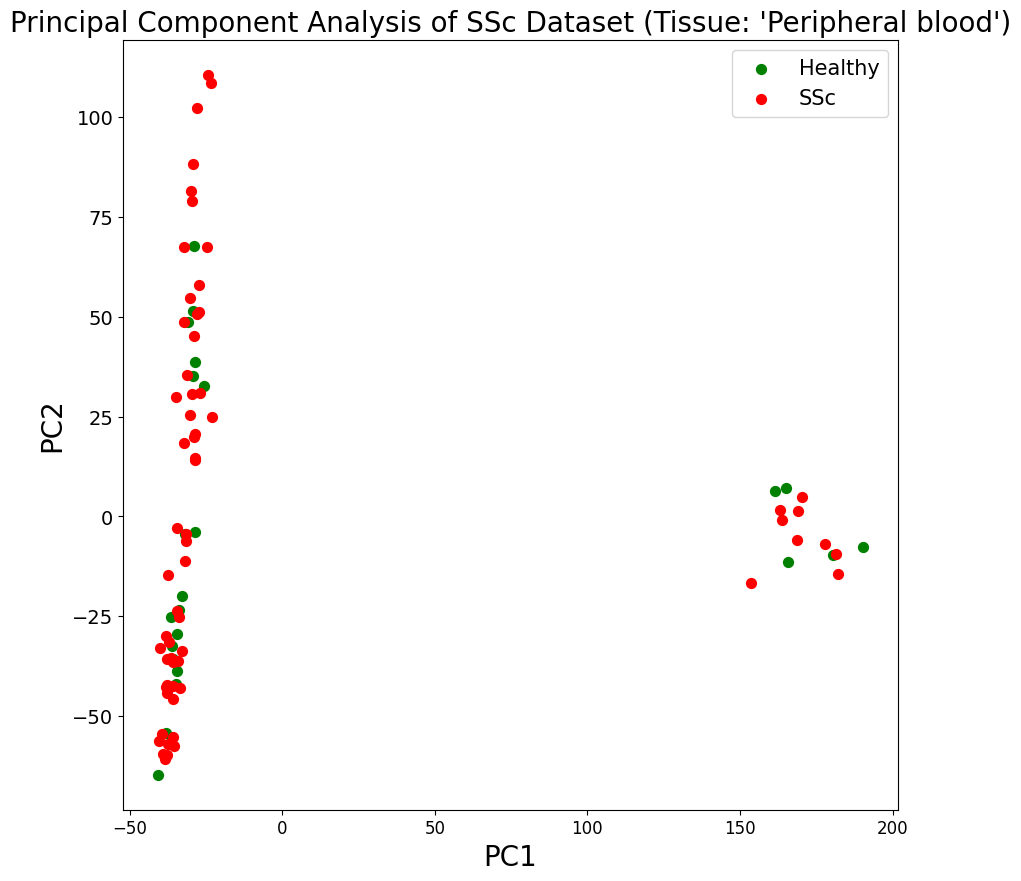

<Figure size 640x480 with 0 Axes>

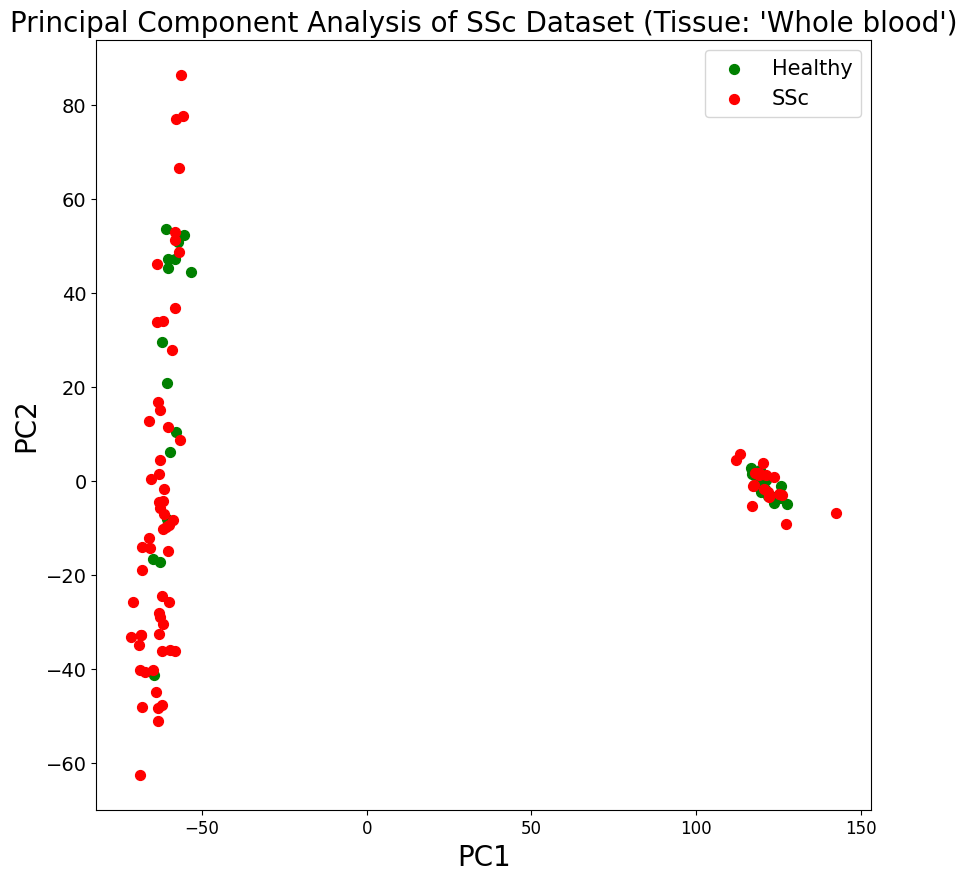

<Figure size 640x480 with 0 Axes>

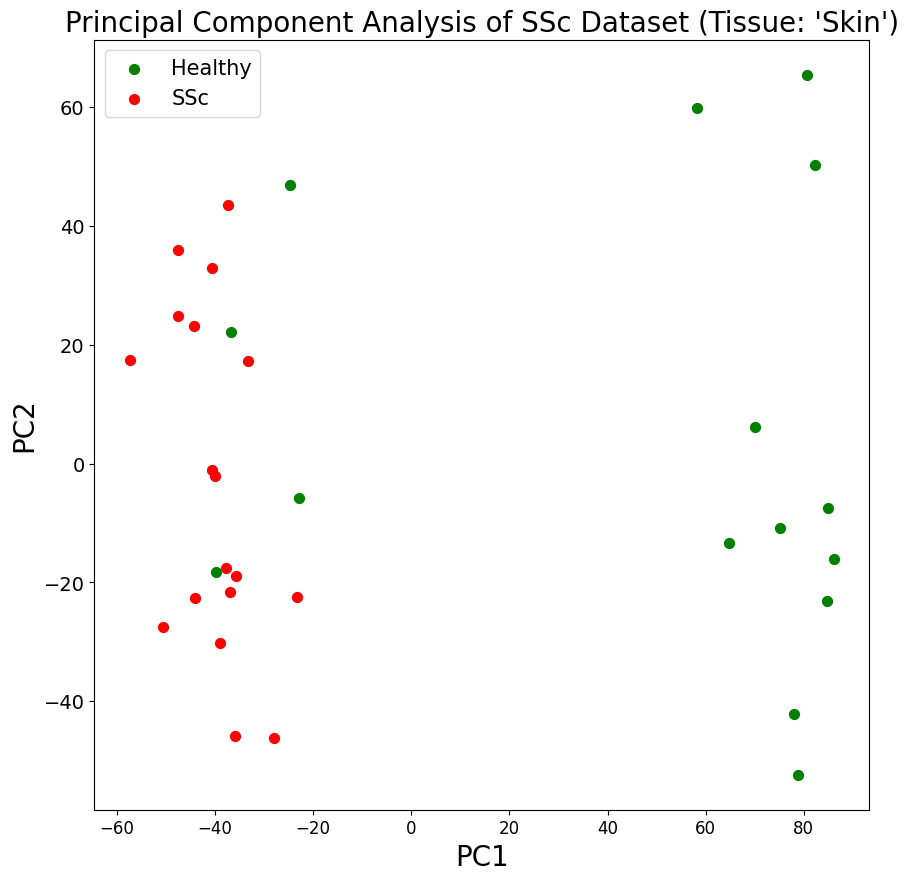

<Figure size 640x480 with 0 Axes>

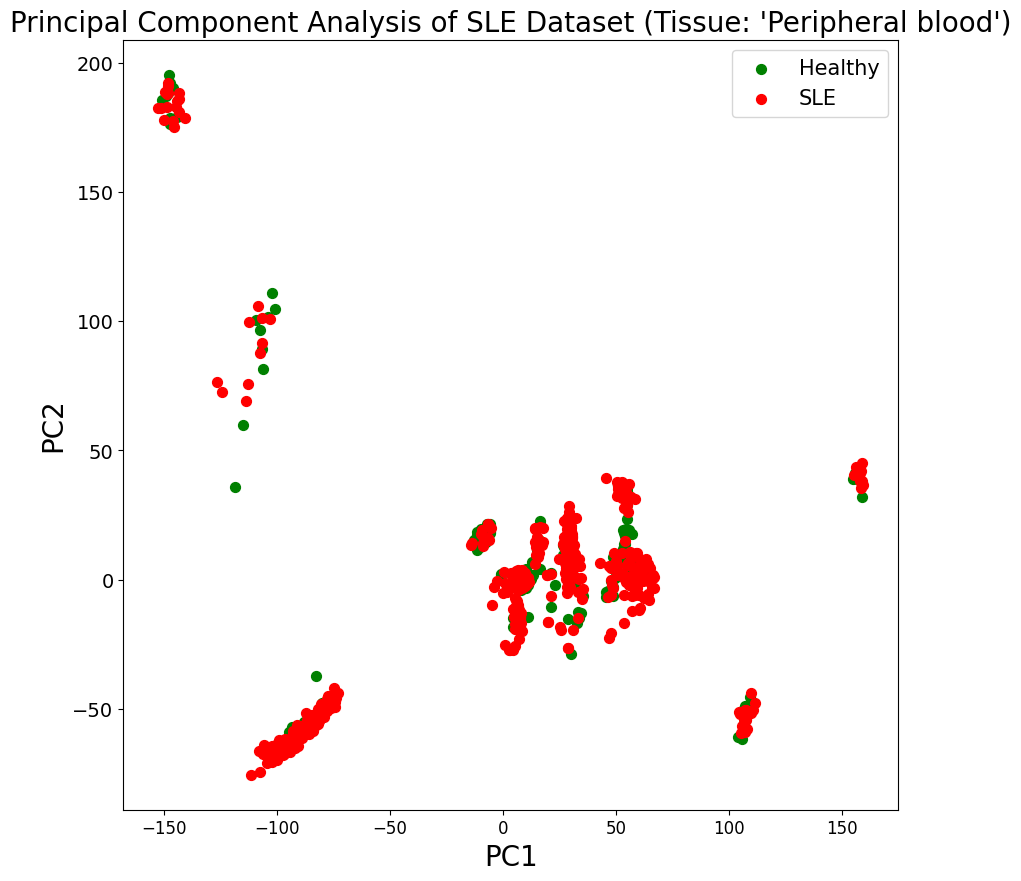

<Figure size 640x480 with 0 Axes>

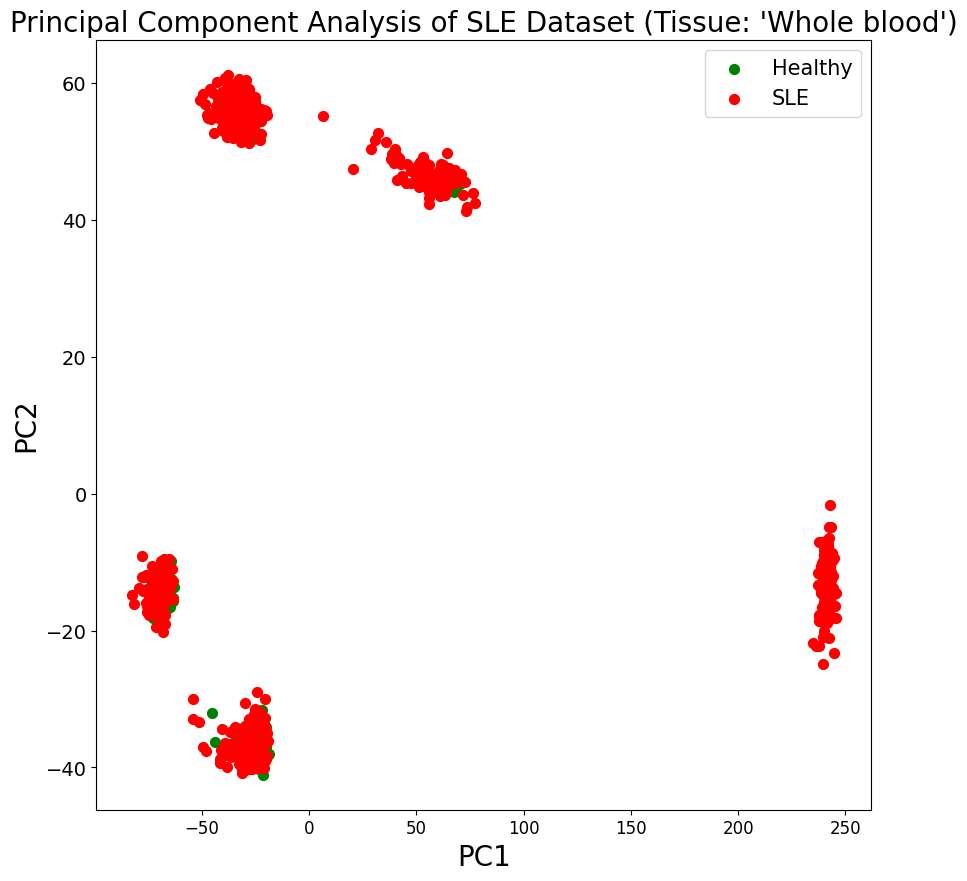

<Figure size 640x480 with 0 Axes>

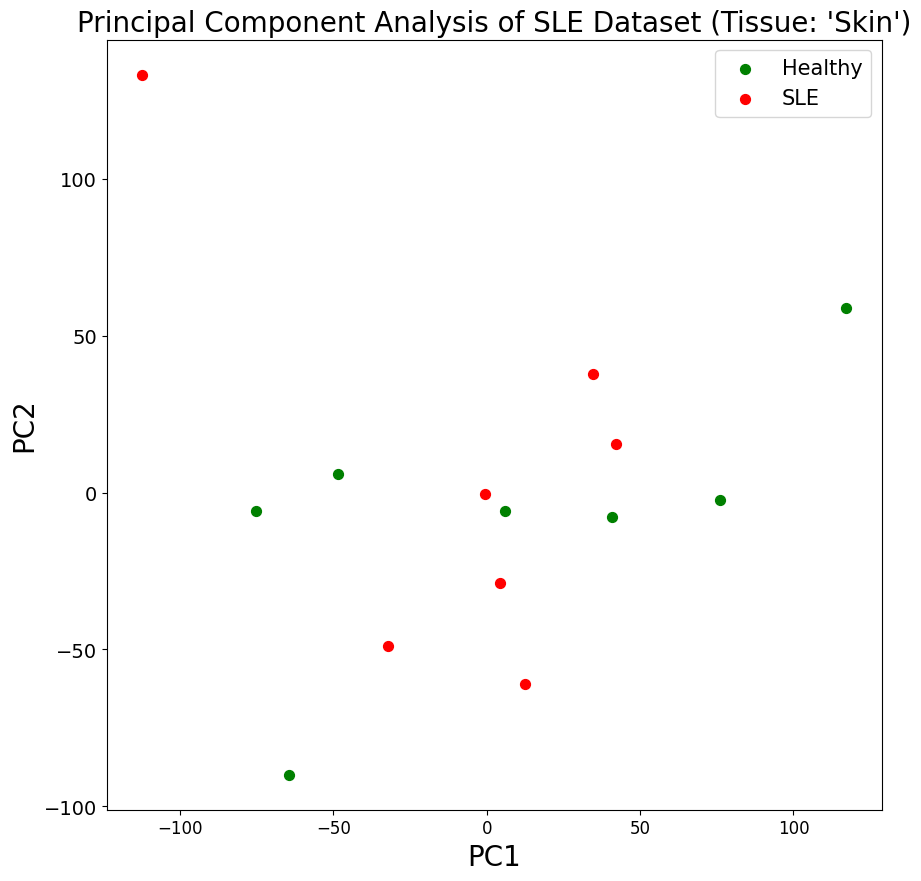

<Figure size 640x480 with 0 Axes>

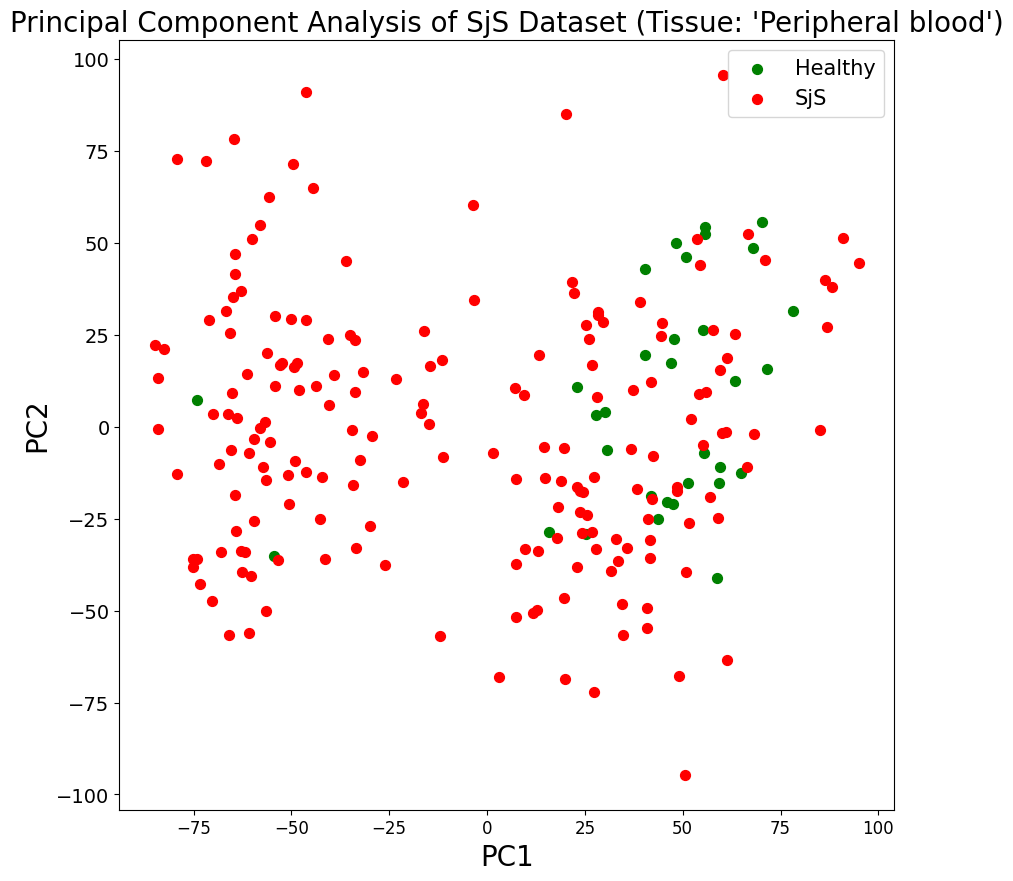

<Figure size 640x480 with 0 Axes>

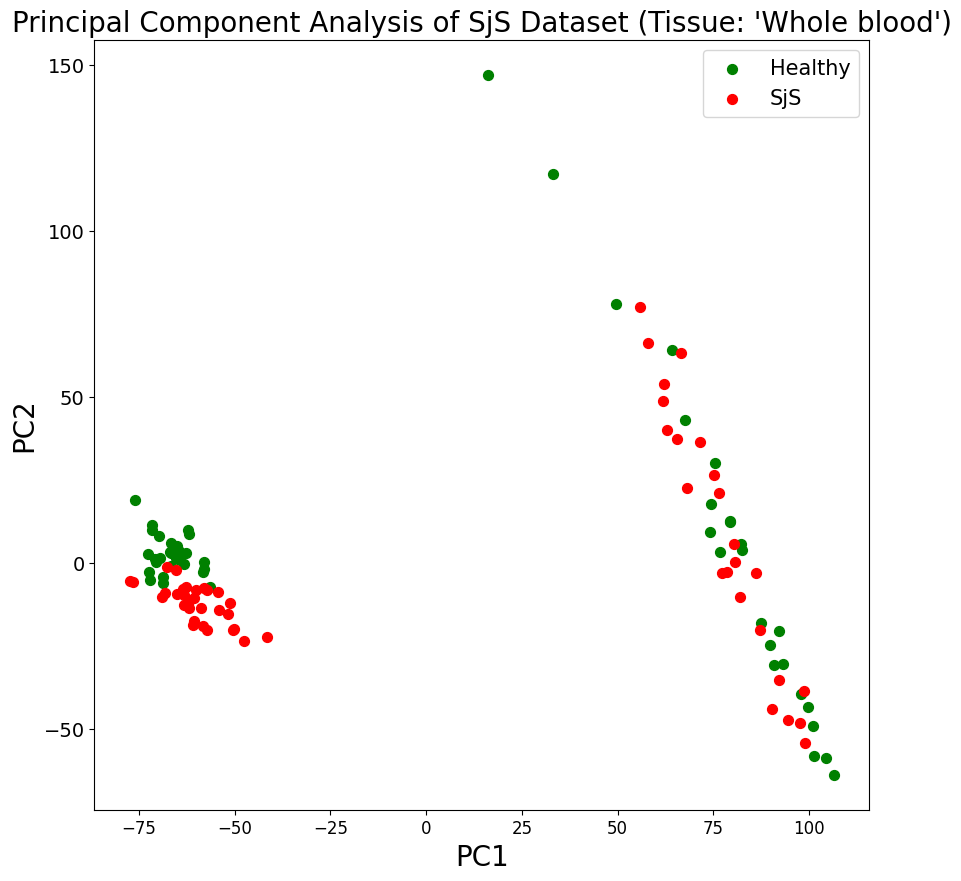

<Figure size 640x480 with 0 Axes>

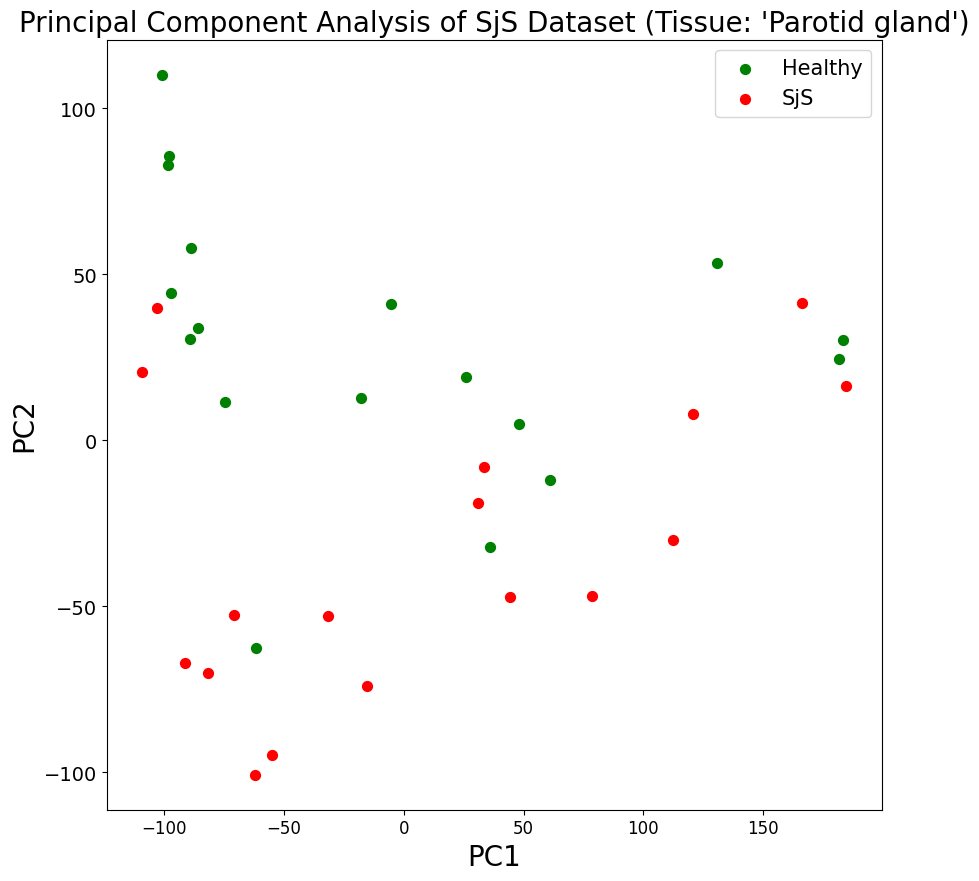

<Figure size 640x480 with 0 Axes>

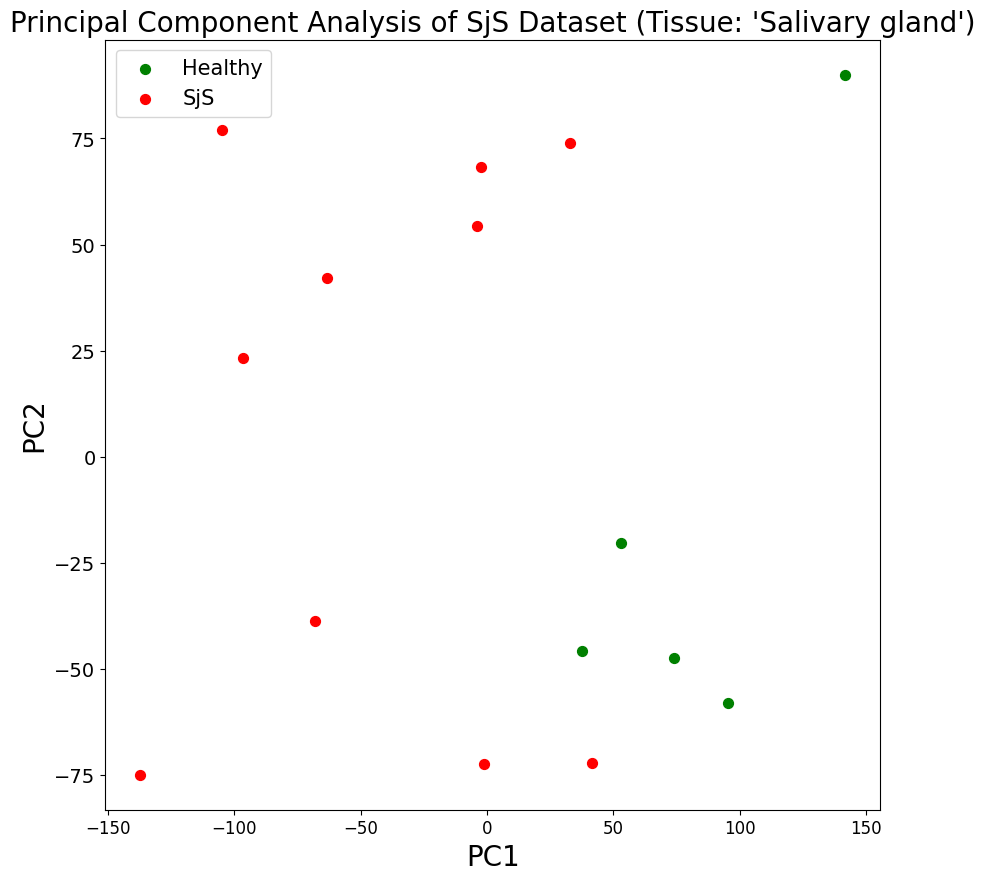

<Figure size 640x480 with 0 Axes>

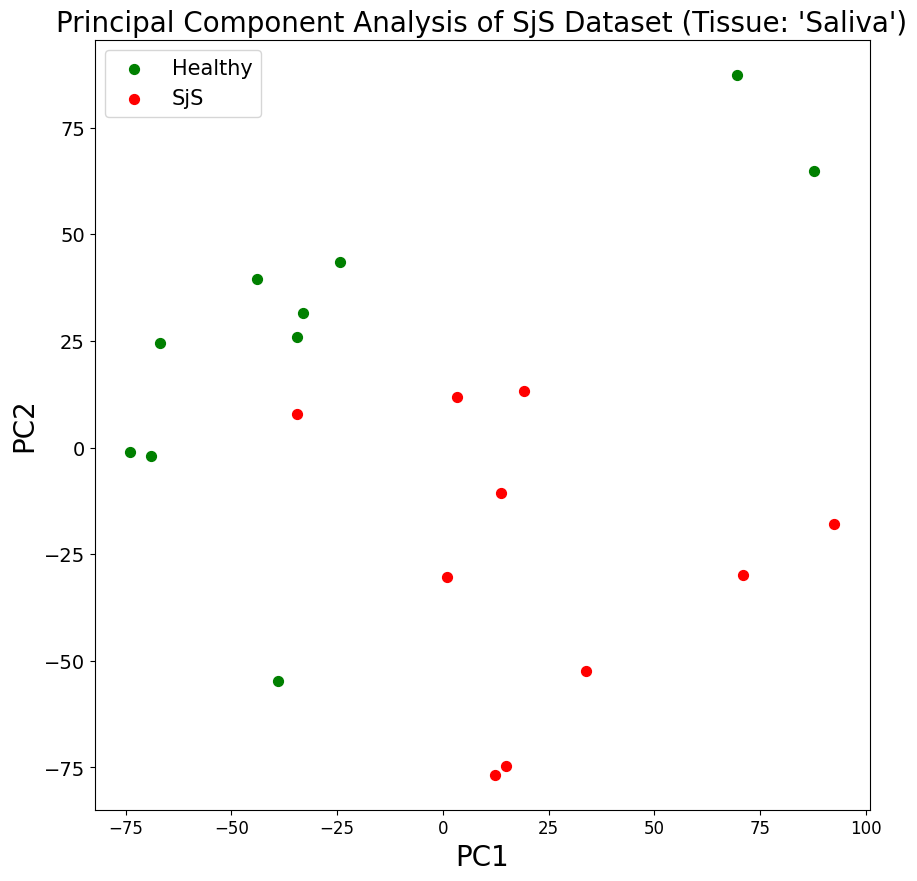

In [6]:
for condition in Condition:
    for tissue in TissueEnum:
        pca = PcaHelper(ConditionTissueDataLoader(condition, tissue), files_path, metadata_path)
        pca.draw(
            column_that_defines_colors="Condition",
            target_colors=[
                ("Healthy", "g"),
                (condition.name, "r")
            ]
        )

# PCA per file

INFO : Processing file: GSE90081.tsv.parquet
INFO : --- Running PCA for 'RA/GSE90081.tsv.parquet'---
INFO : Loaded dataset for PCA with shape: Samples(24), Genes(13645)
INFO : Dataset normalised | Mean: '-1.0130564575023583e-17' Standard Deviation:'0.9999999999999999'
INFO : Explained variation per principal component: [0.30326326 0.15732321]
INFO : ----------------------------------------------
INFO : Processing file: GSE38351_RA_GPL96.tsv.parquet
INFO : --- Running PCA for 'RA/GSE38351_RA_GPL96.tsv.parquet'---
INFO : Loaded dataset for PCA with shape: Samples(20), Genes(13905)
INFO : Dataset normalised | Mean: '1.1088487291214823e-16' Standard Deviation:'1.0'
INFO : Explained variation per principal component: [0.29969746 0.10061232]
INFO : ----------------------------------------------
INFO : Processing file: GSE65010_Naive_effector_T_cells.tsv.parquet
INFO : --- Running PCA for 'RA/GSE65010_Naive_effector_T_cells.tsv.parquet'---
INFO : Loaded dataset for PCA with shape: Samples(12)

<Figure size 640x480 with 0 Axes>

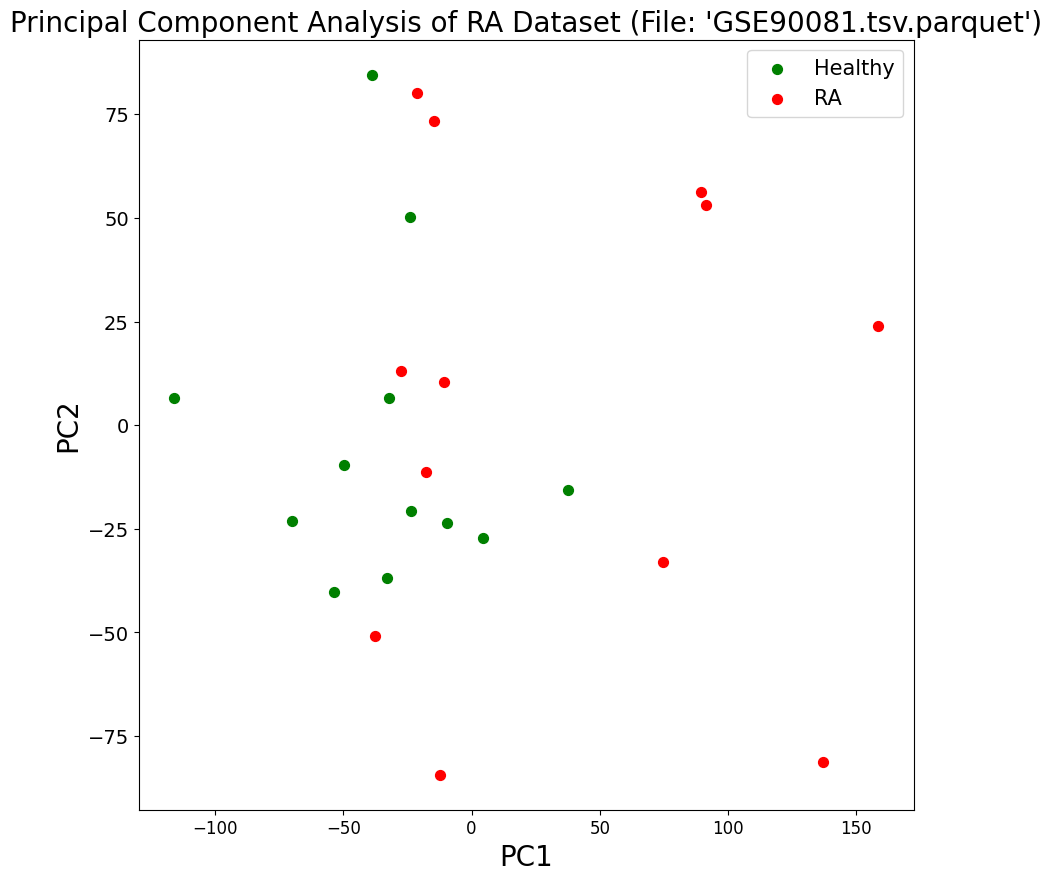

<Figure size 640x480 with 0 Axes>

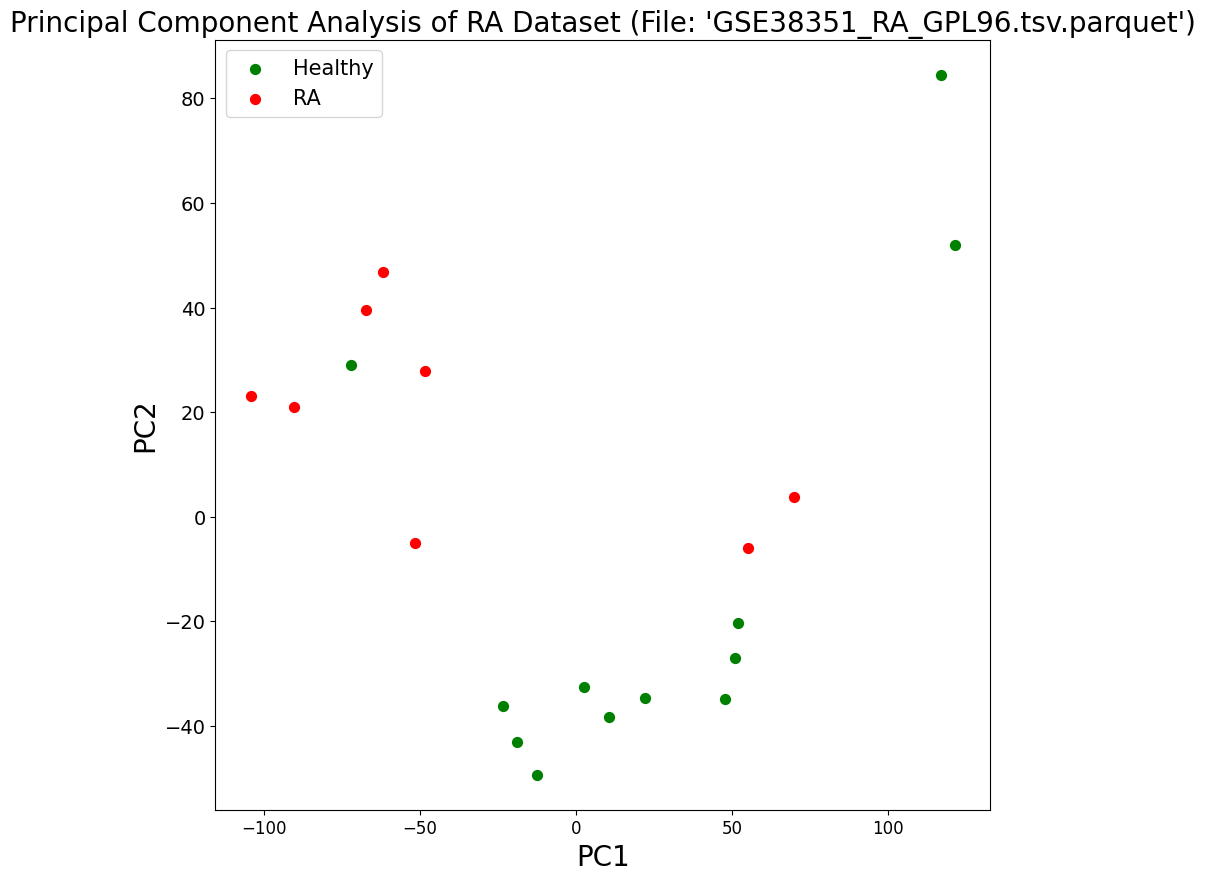

<Figure size 640x480 with 0 Axes>

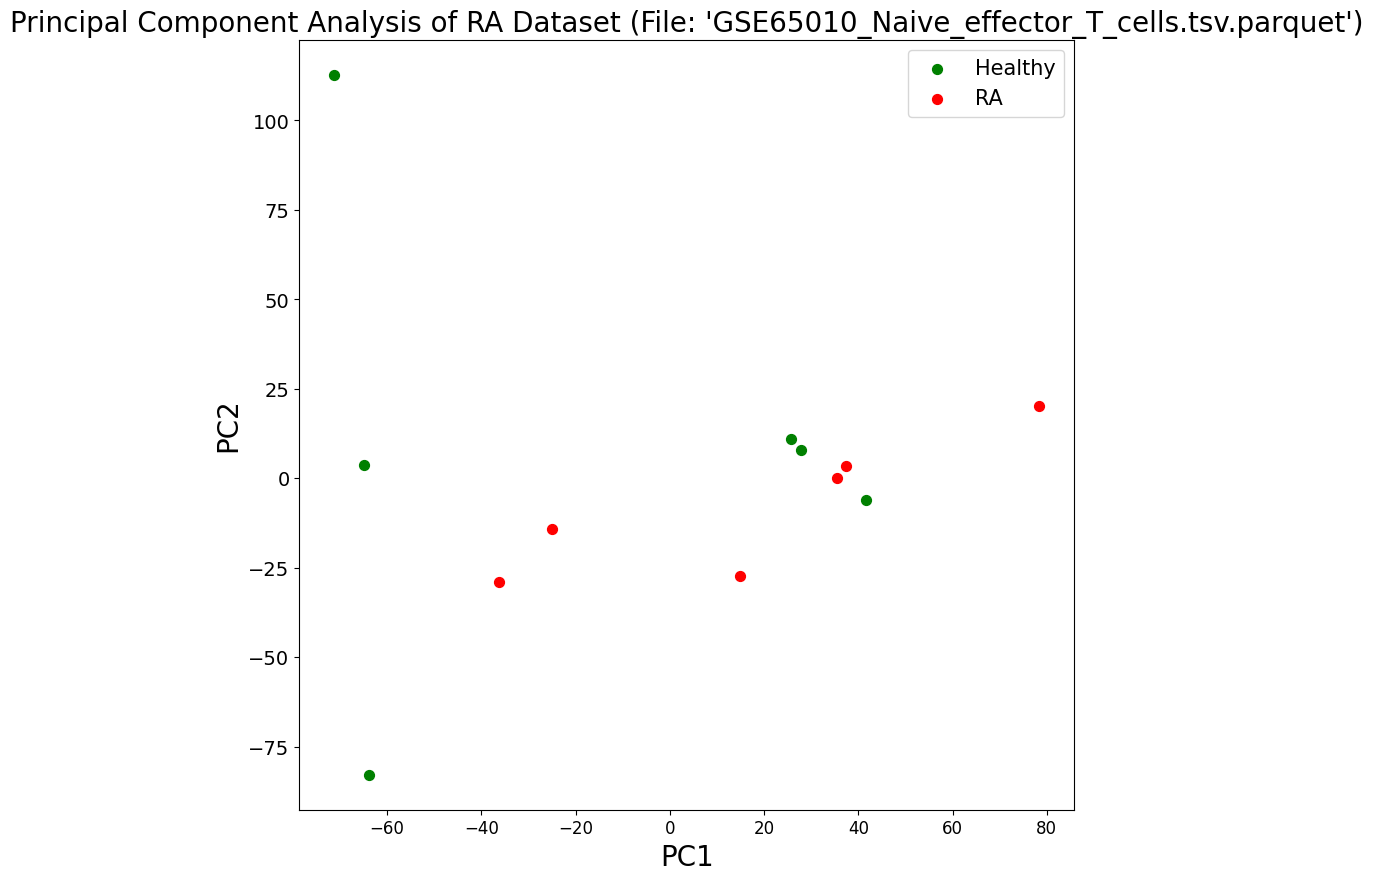

<Figure size 640x480 with 0 Axes>

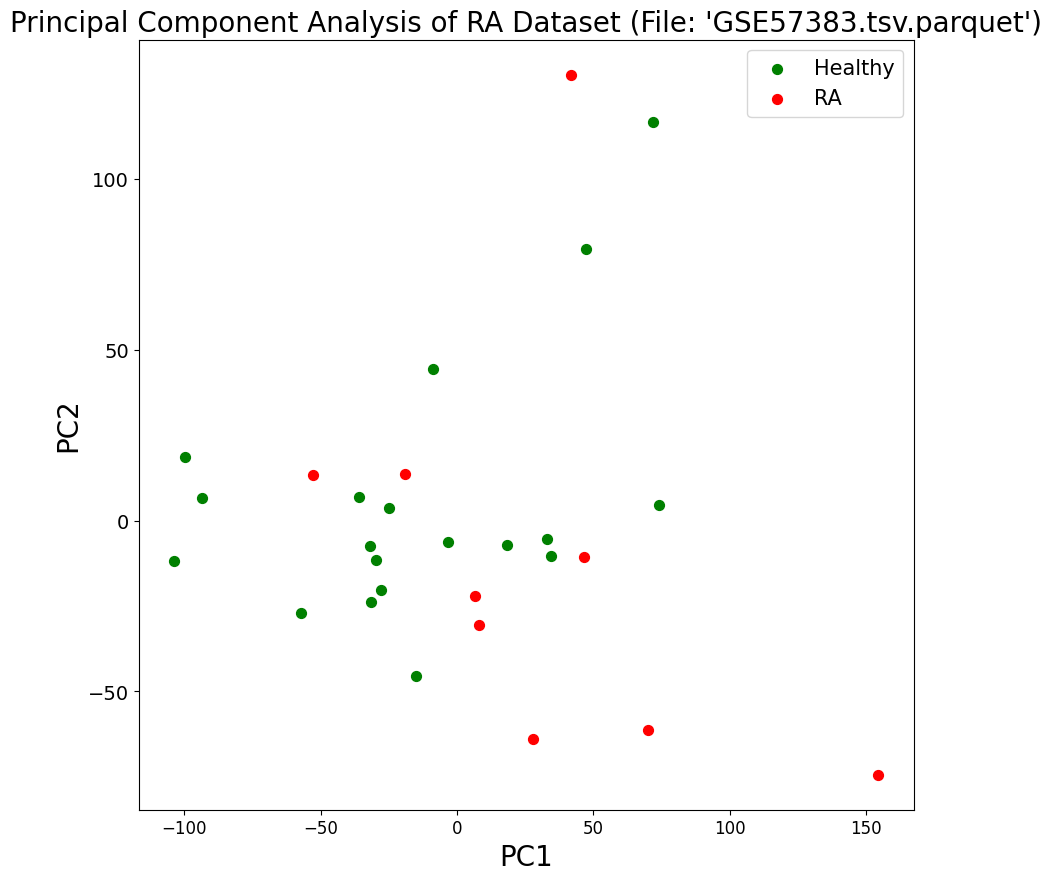

<Figure size 640x480 with 0 Axes>

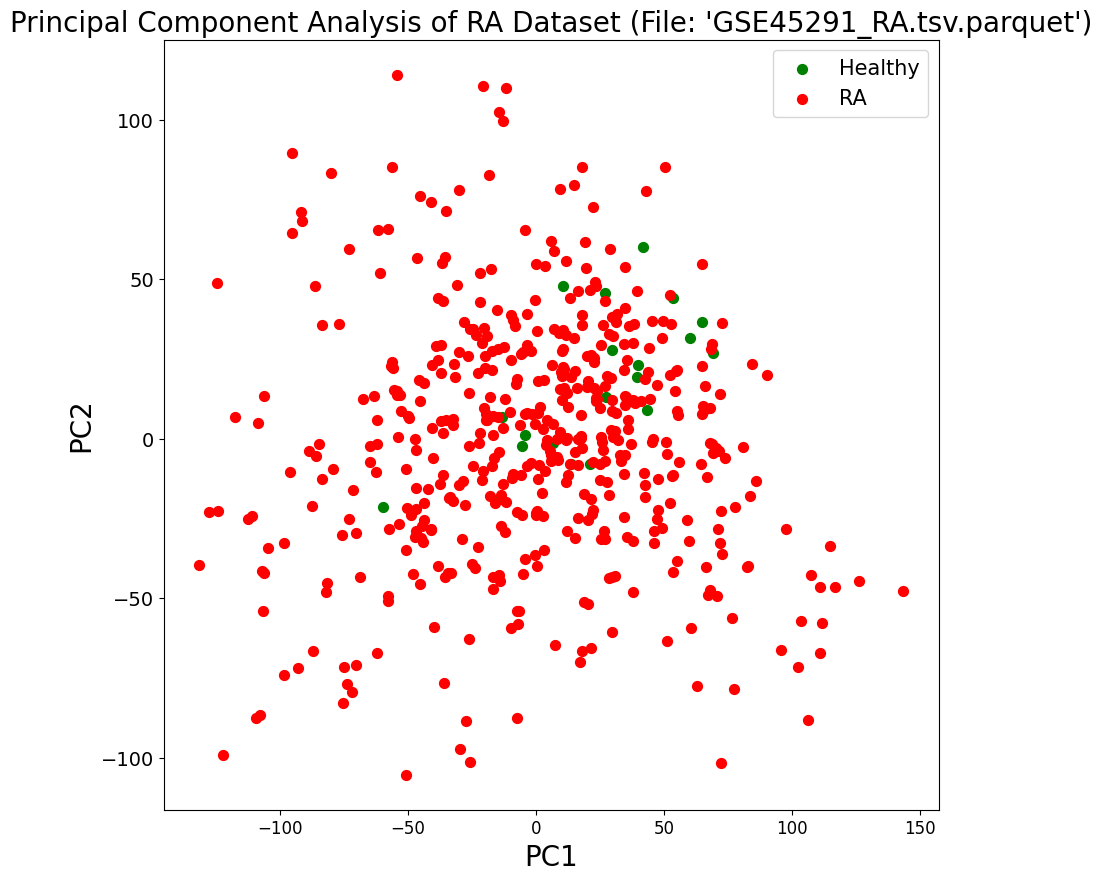

<Figure size 640x480 with 0 Axes>

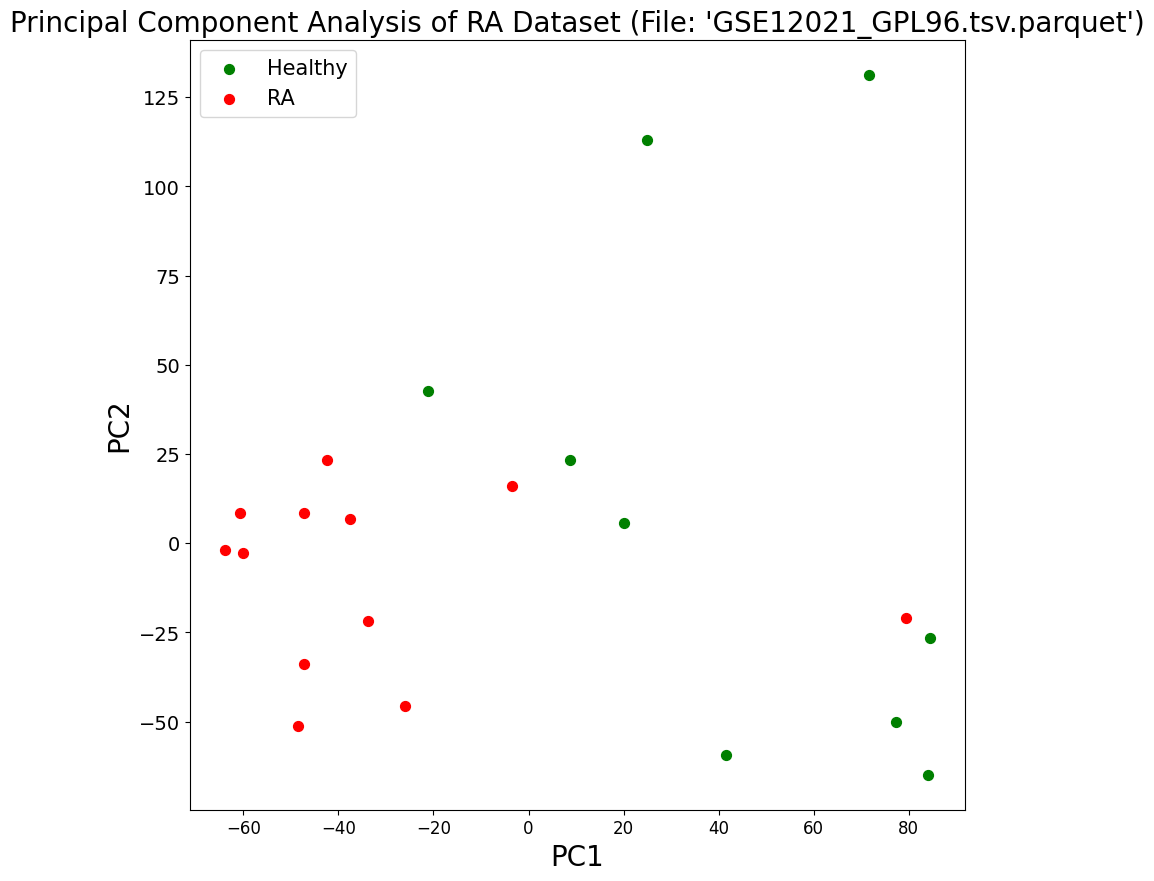

<Figure size 640x480 with 0 Axes>

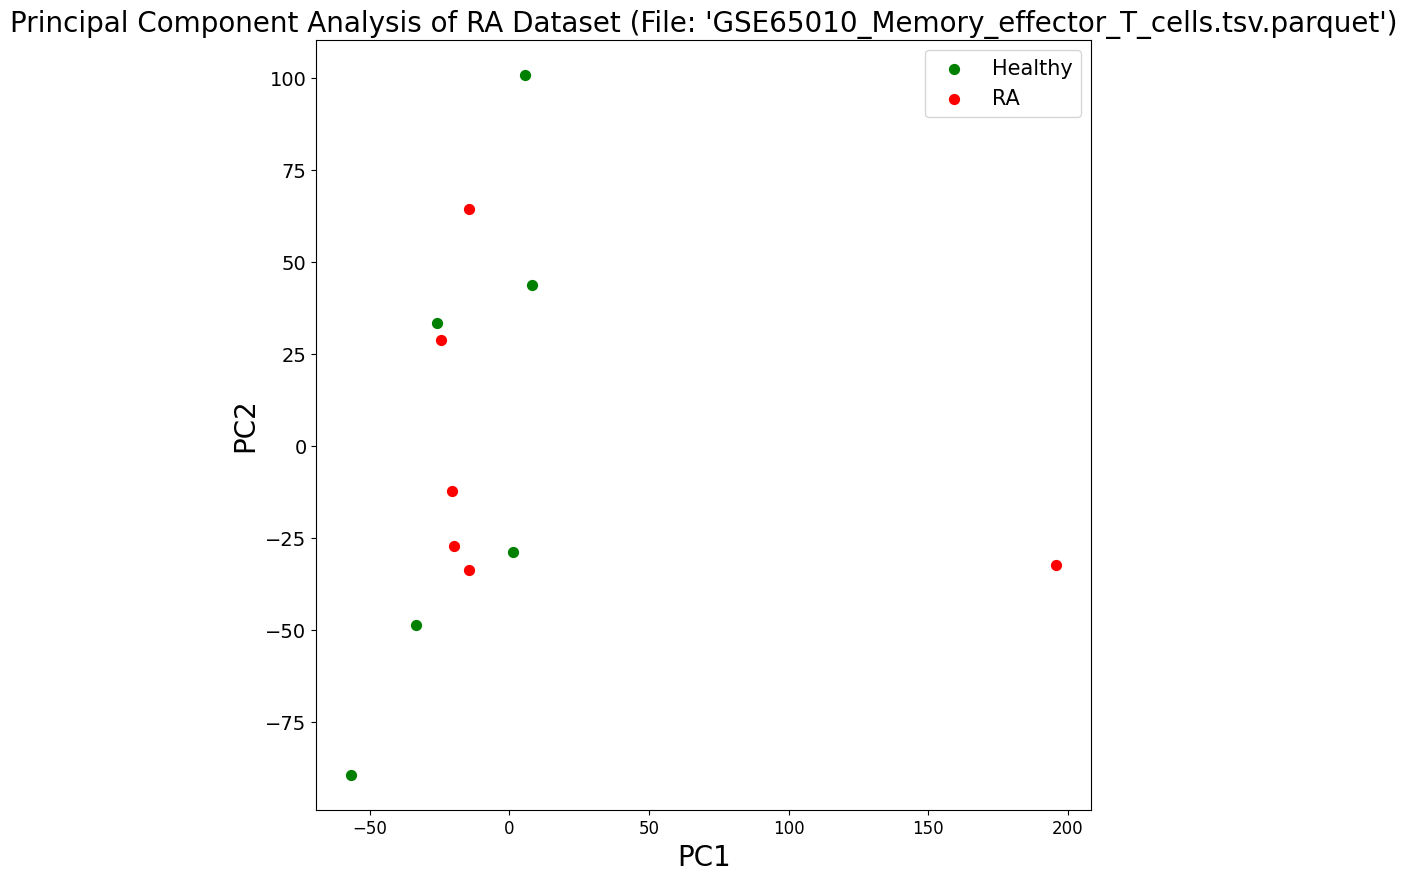

<Figure size 640x480 with 0 Axes>

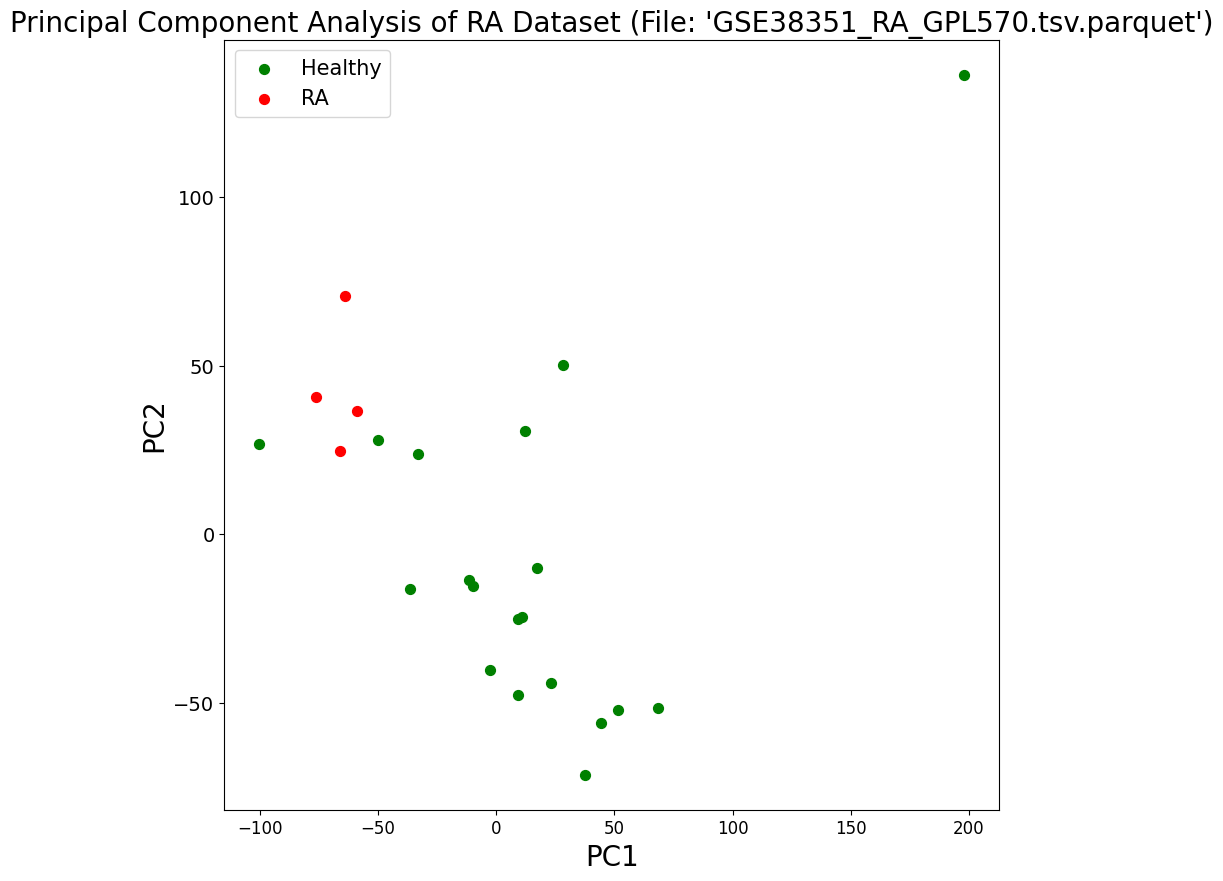

<Figure size 640x480 with 0 Axes>

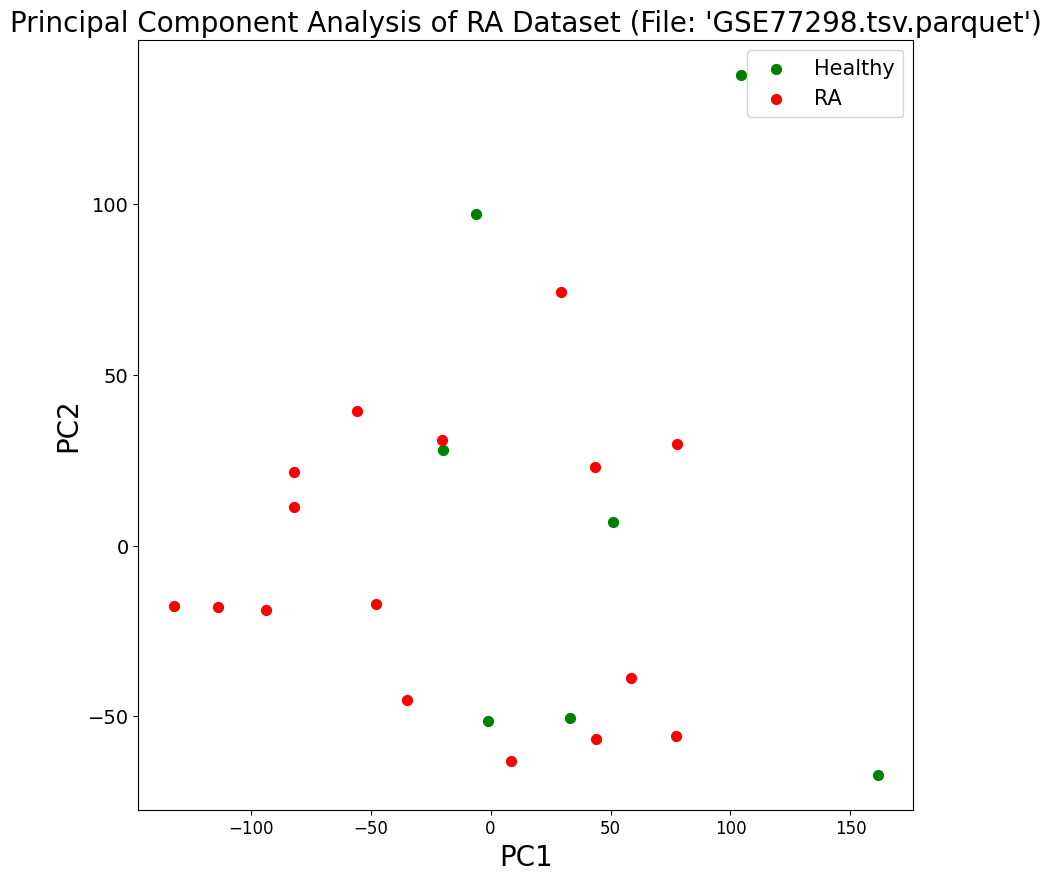

<Figure size 640x480 with 0 Axes>

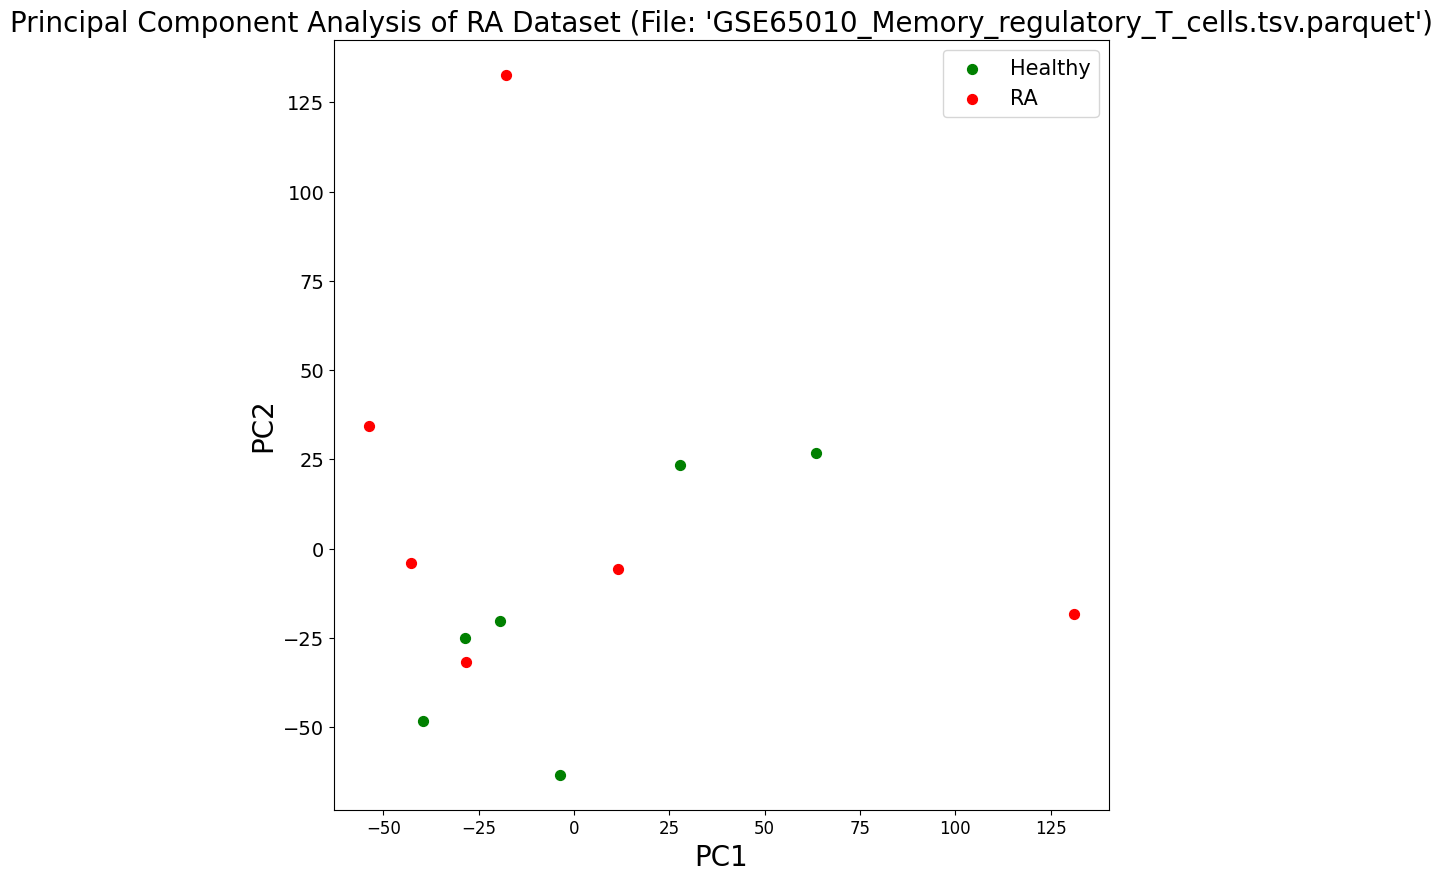

<Figure size 640x480 with 0 Axes>

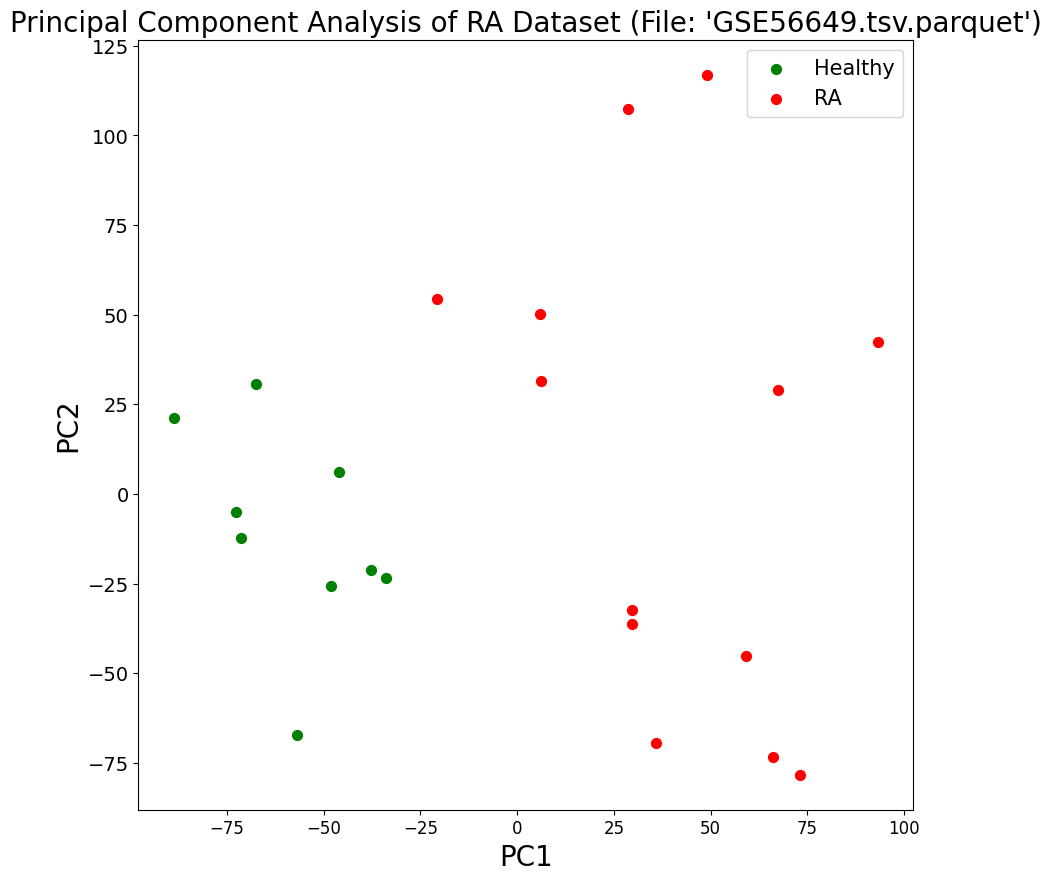

<Figure size 640x480 with 0 Axes>

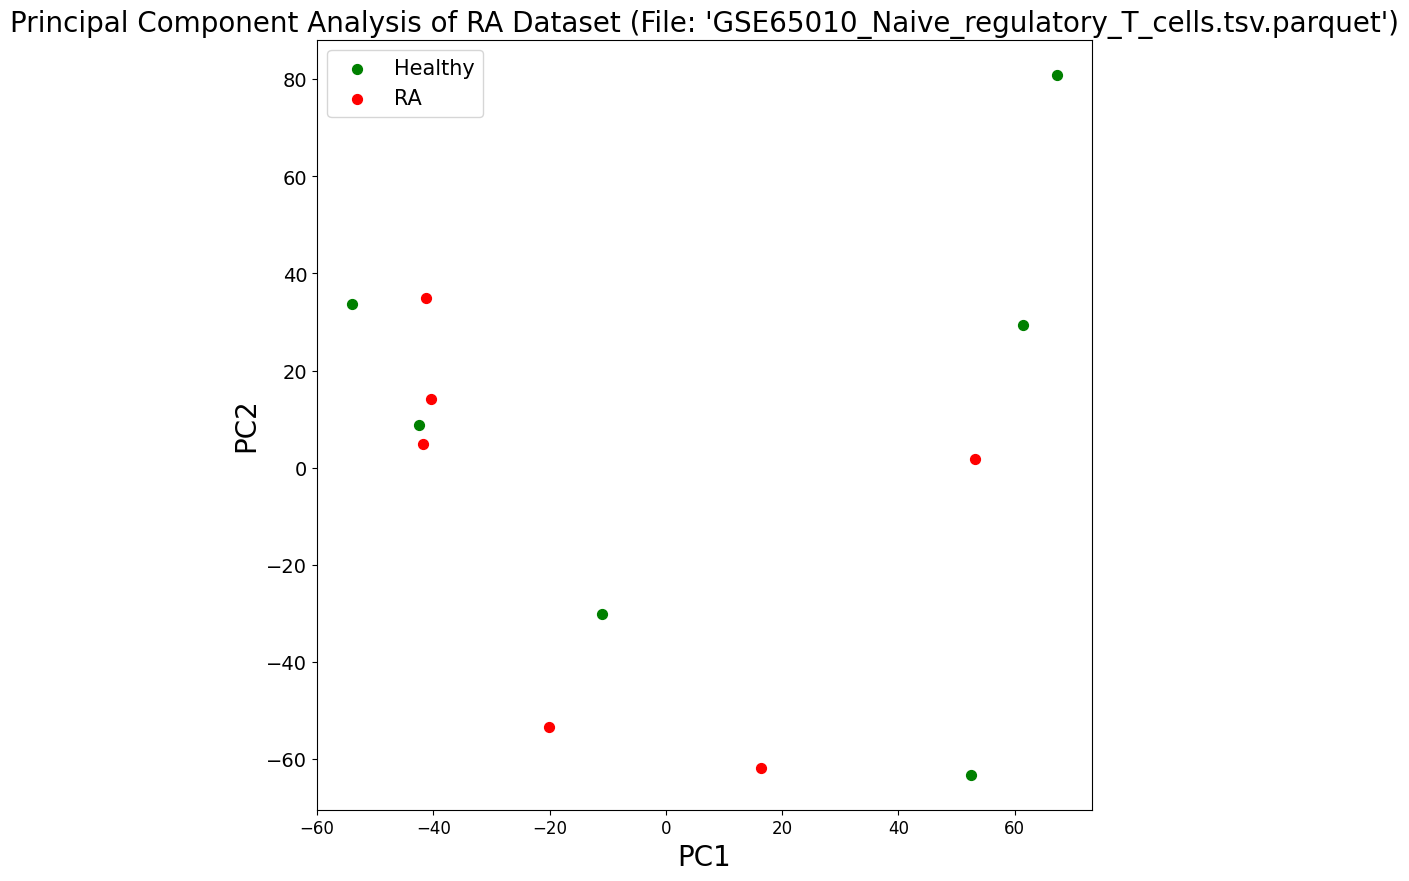

<Figure size 640x480 with 0 Axes>

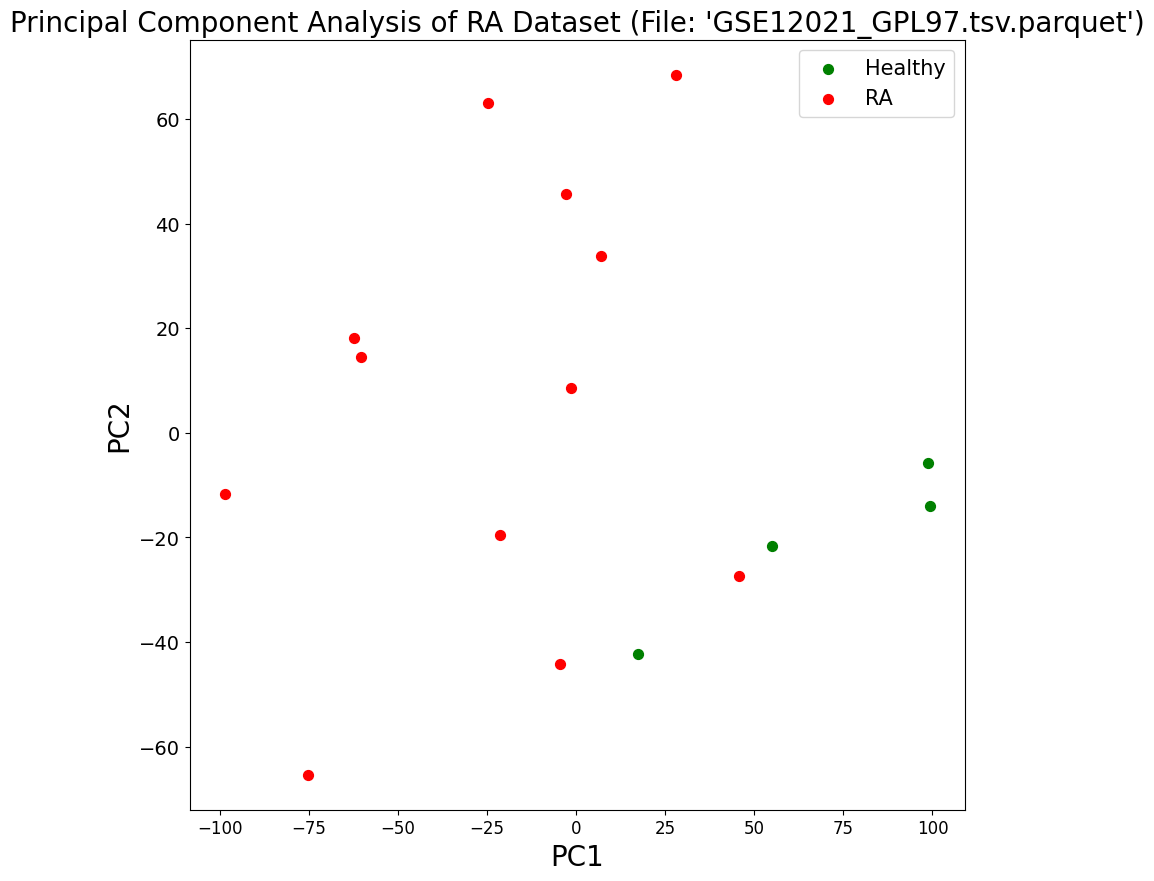

<Figure size 640x480 with 0 Axes>

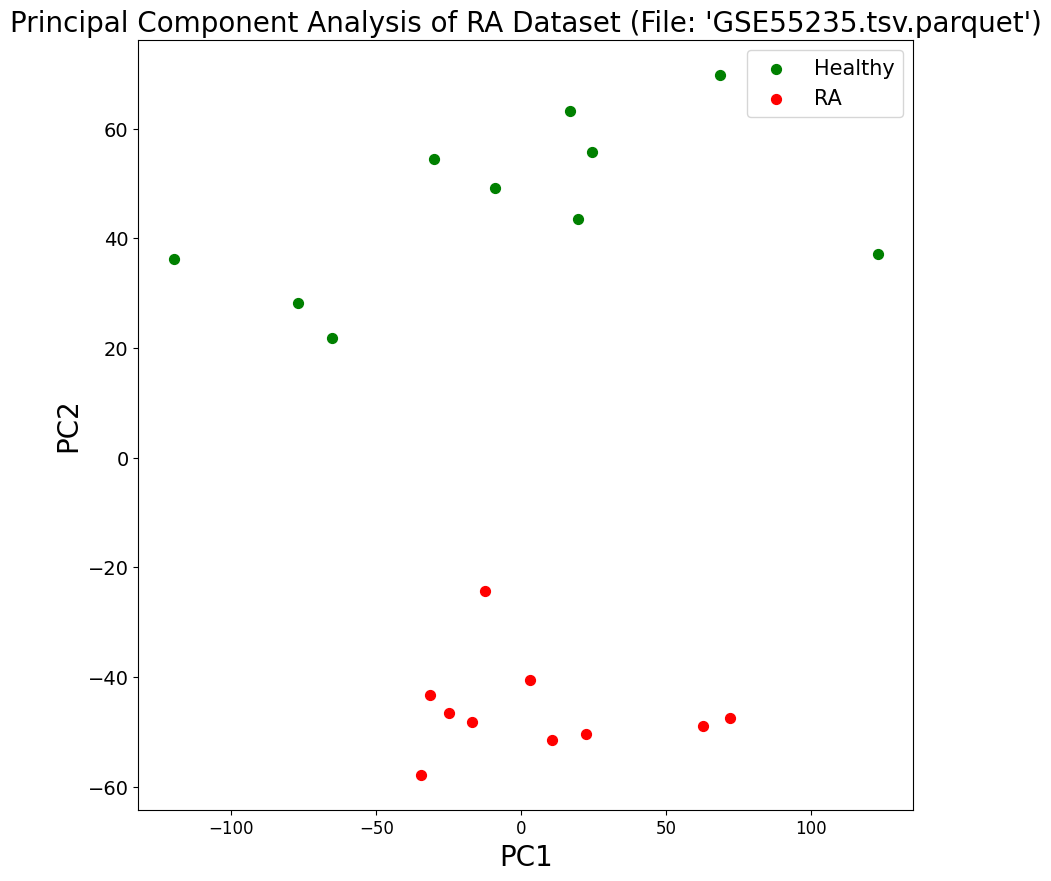

<Figure size 640x480 with 0 Axes>

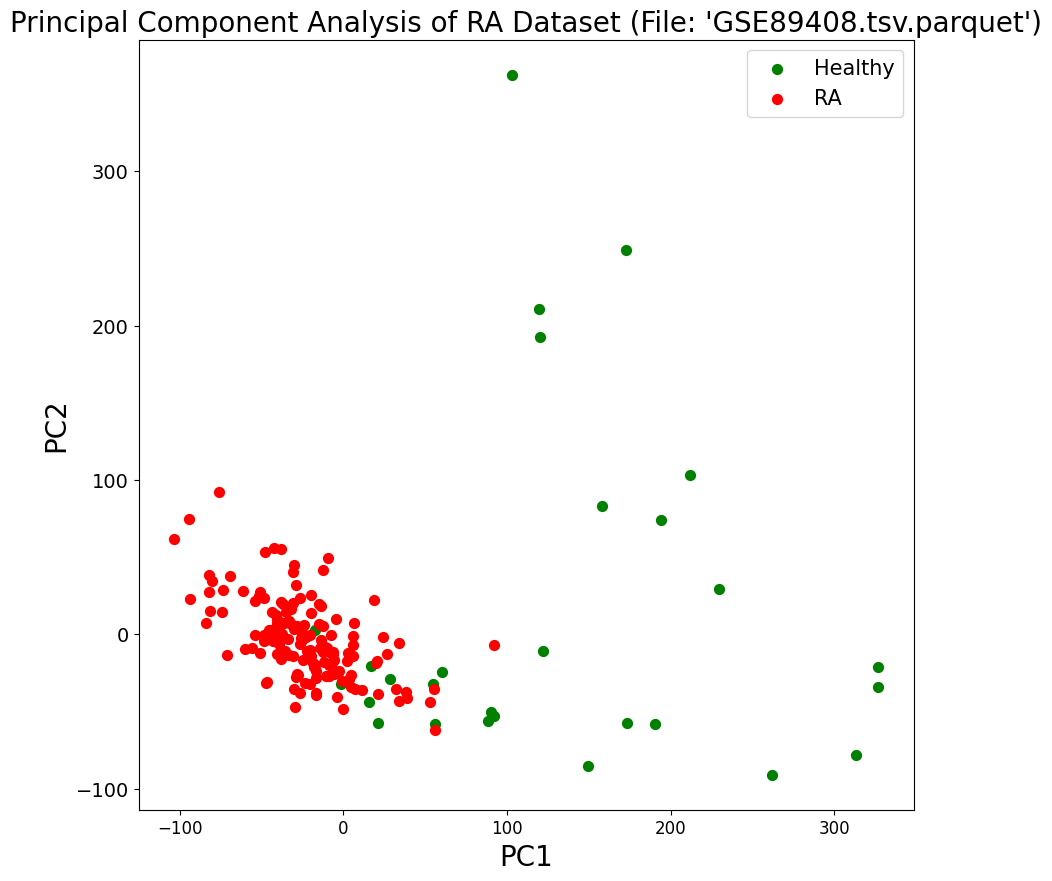

<Figure size 640x480 with 0 Axes>

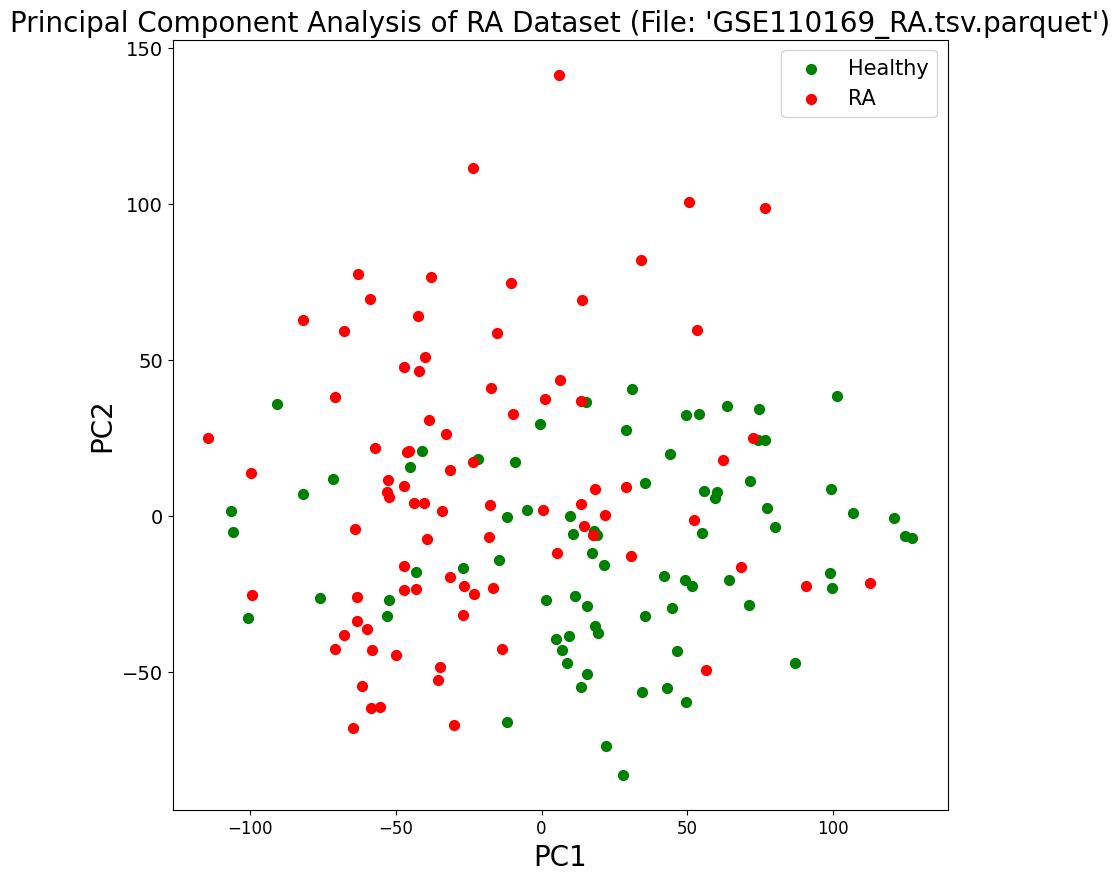

<Figure size 640x480 with 0 Axes>

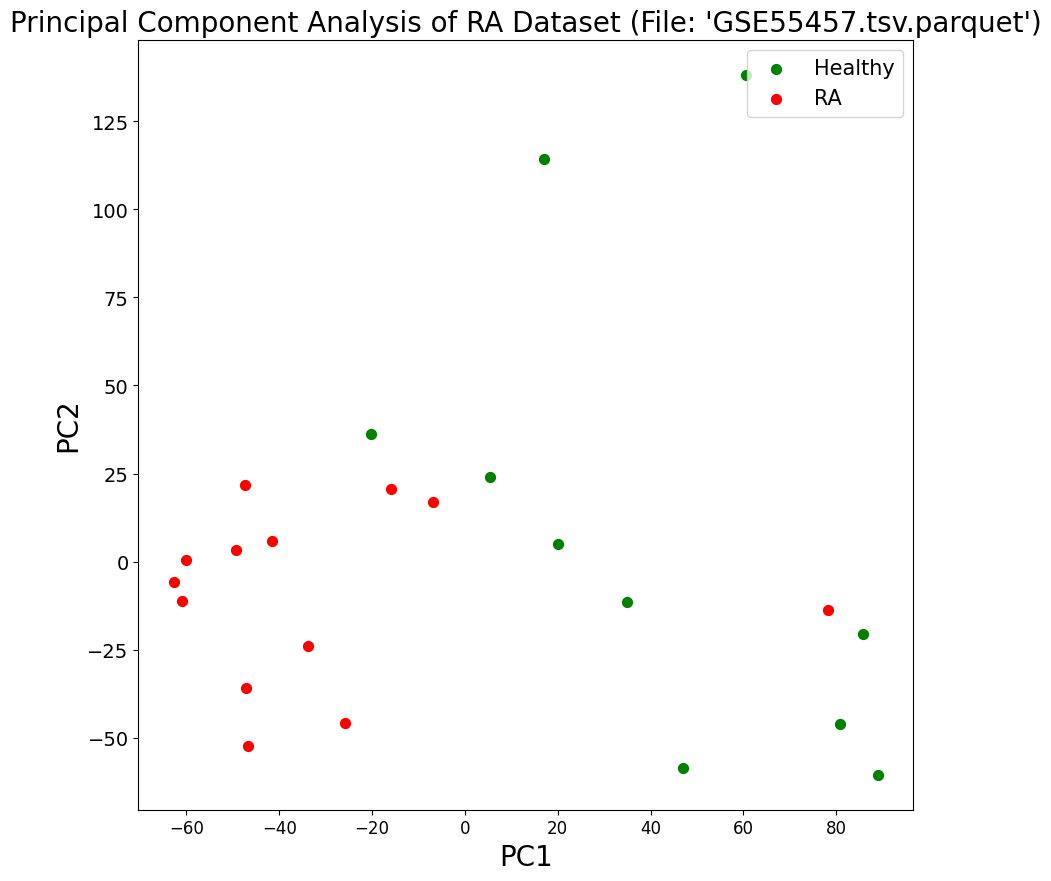

<Figure size 640x480 with 0 Axes>

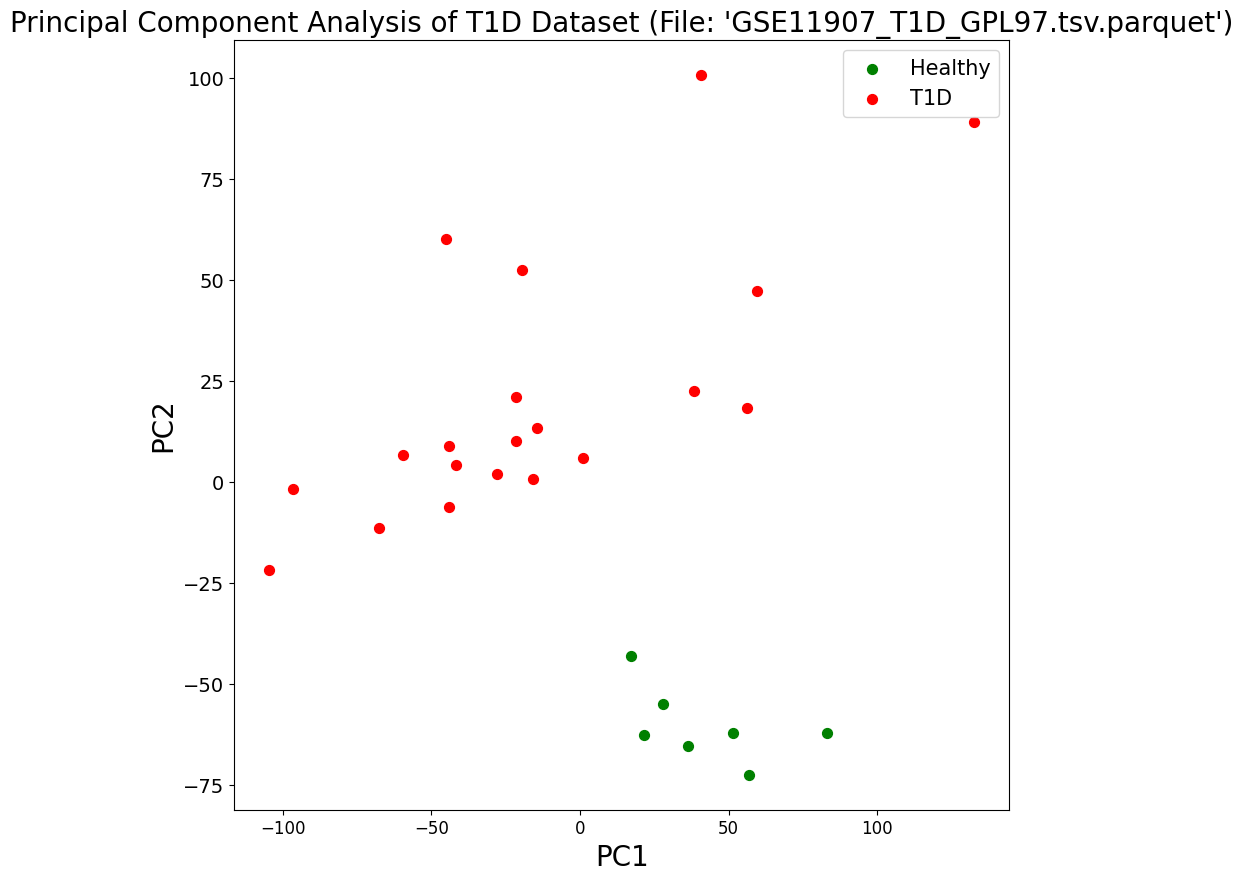

<Figure size 640x480 with 0 Axes>

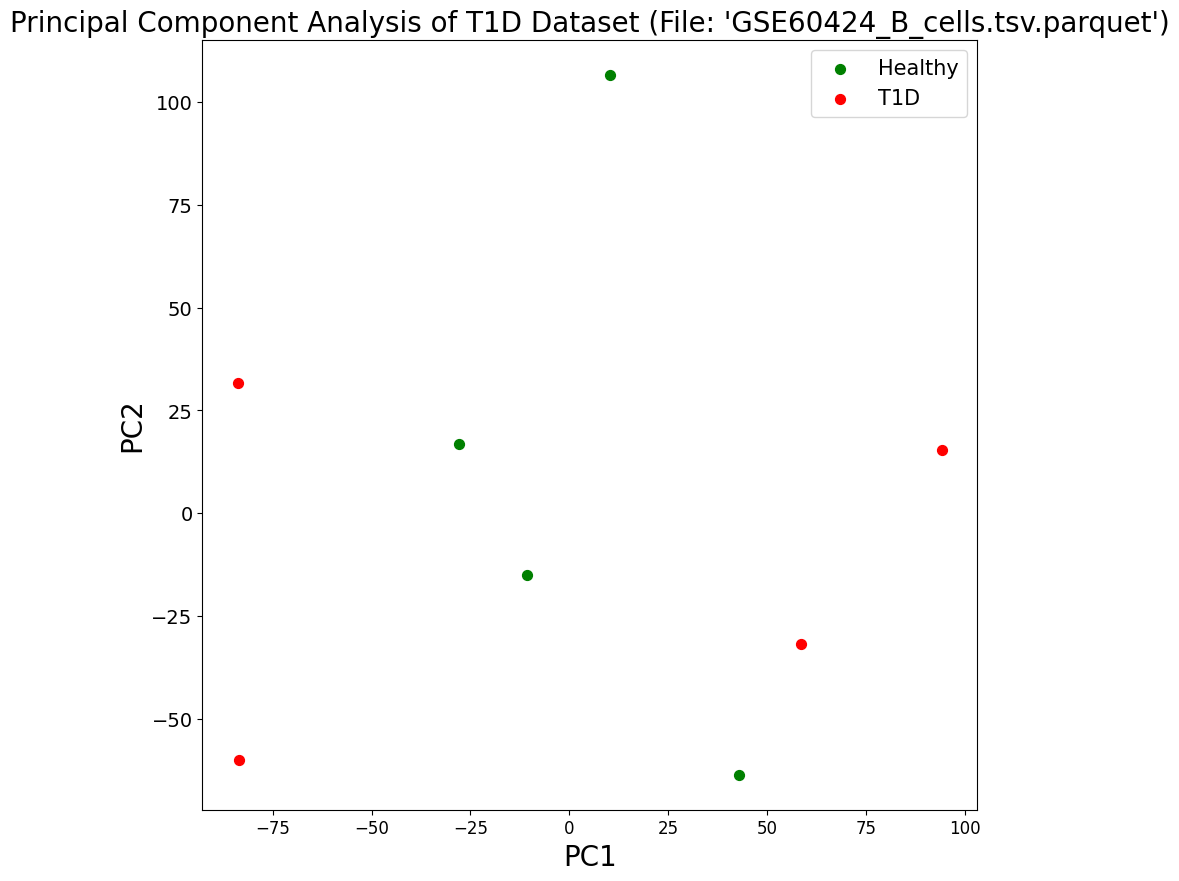

<Figure size 640x480 with 0 Axes>

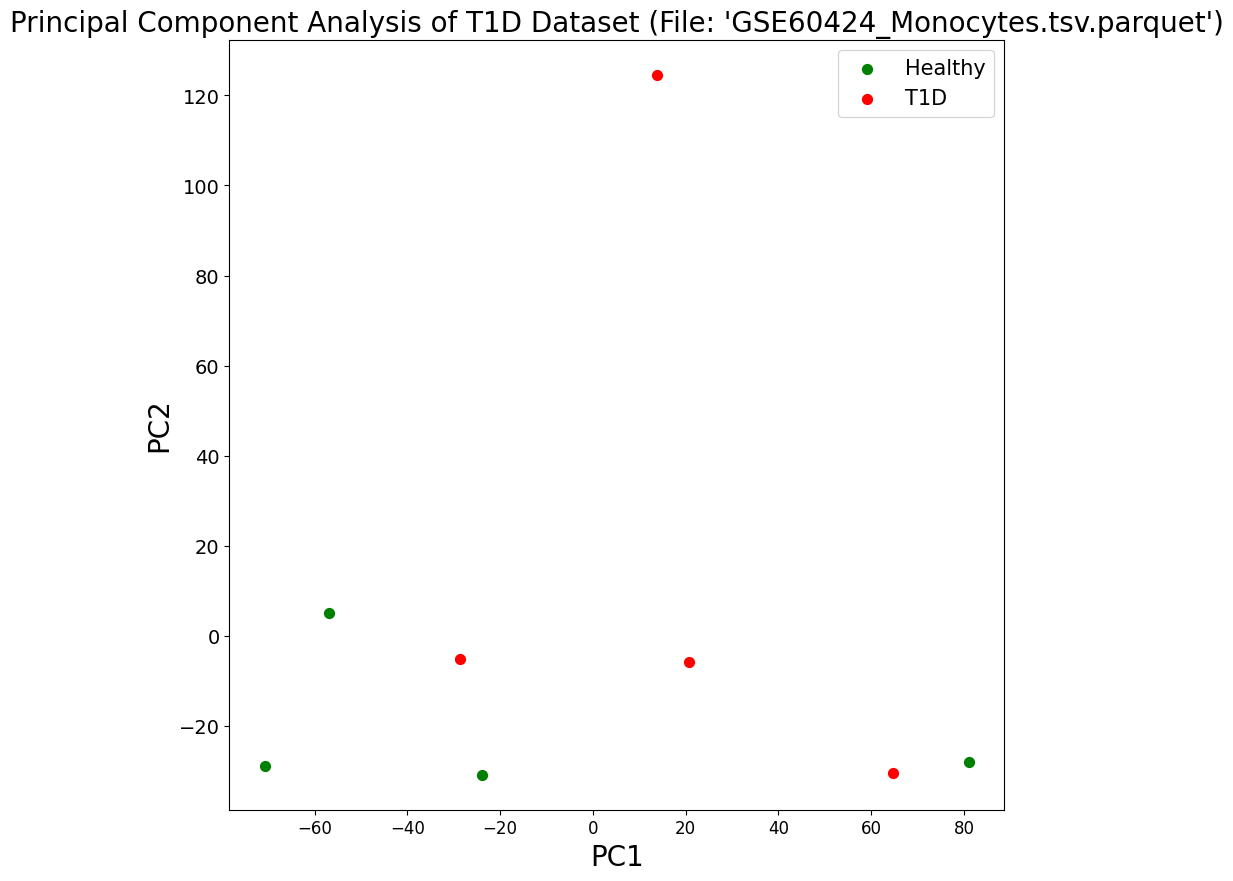

<Figure size 640x480 with 0 Axes>

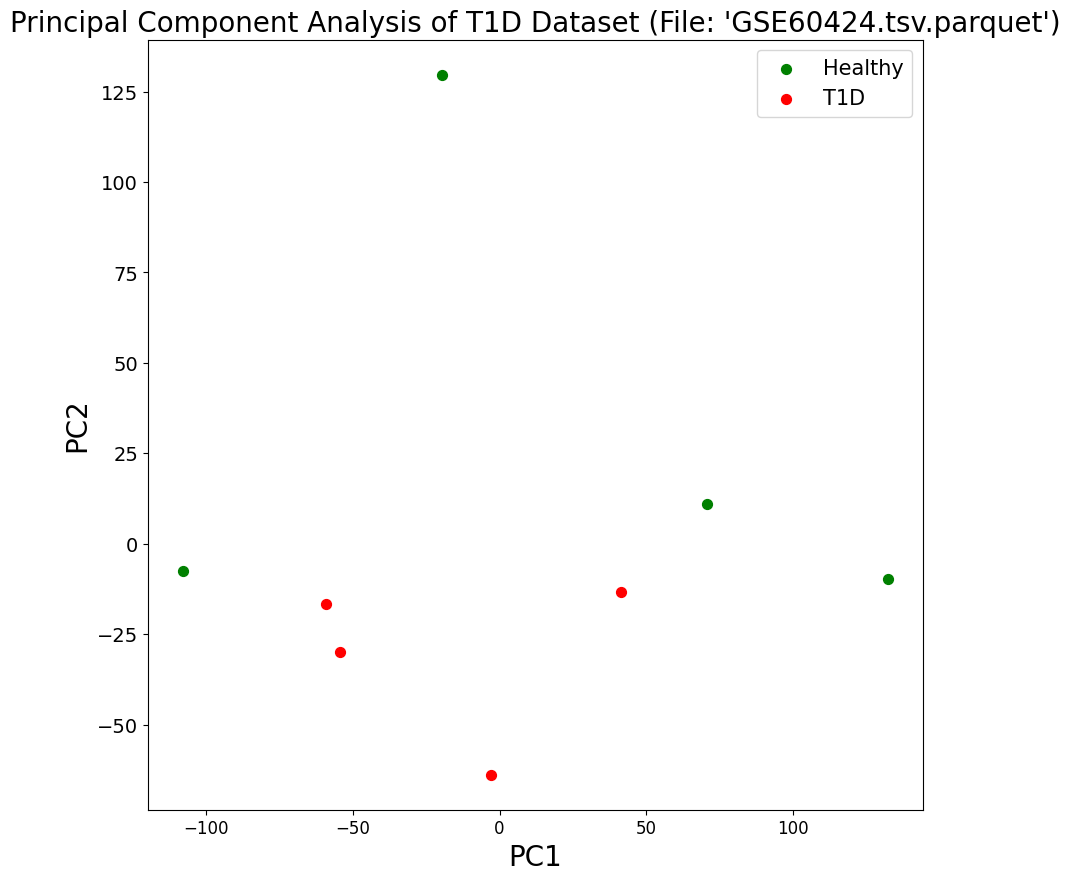

<Figure size 640x480 with 0 Axes>

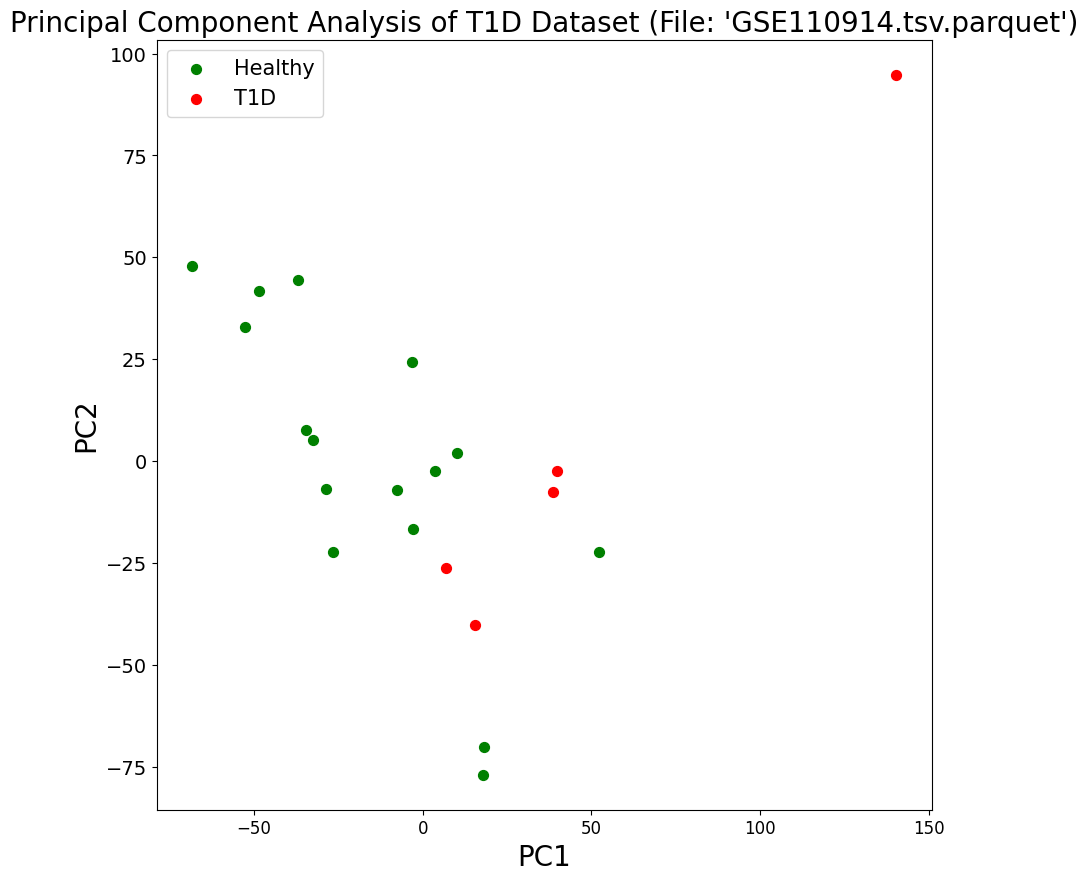

<Figure size 640x480 with 0 Axes>

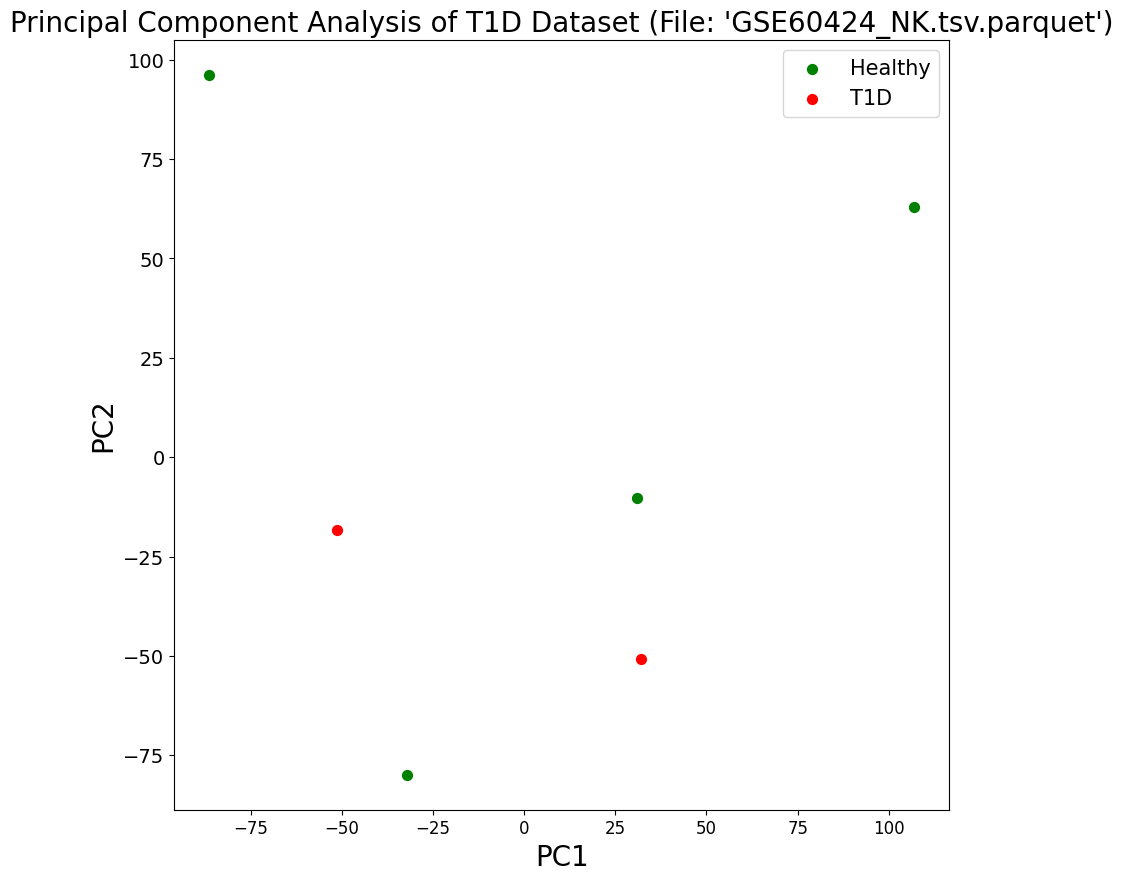

<Figure size 640x480 with 0 Axes>

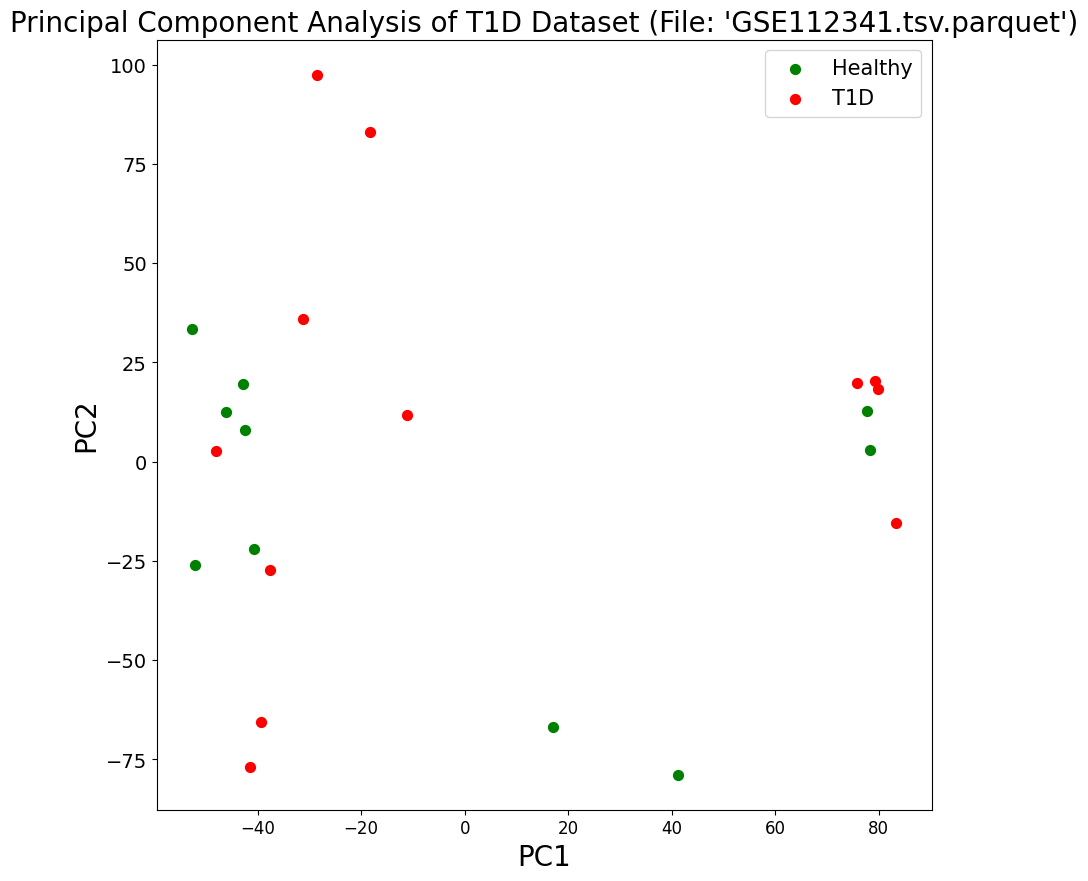

<Figure size 640x480 with 0 Axes>

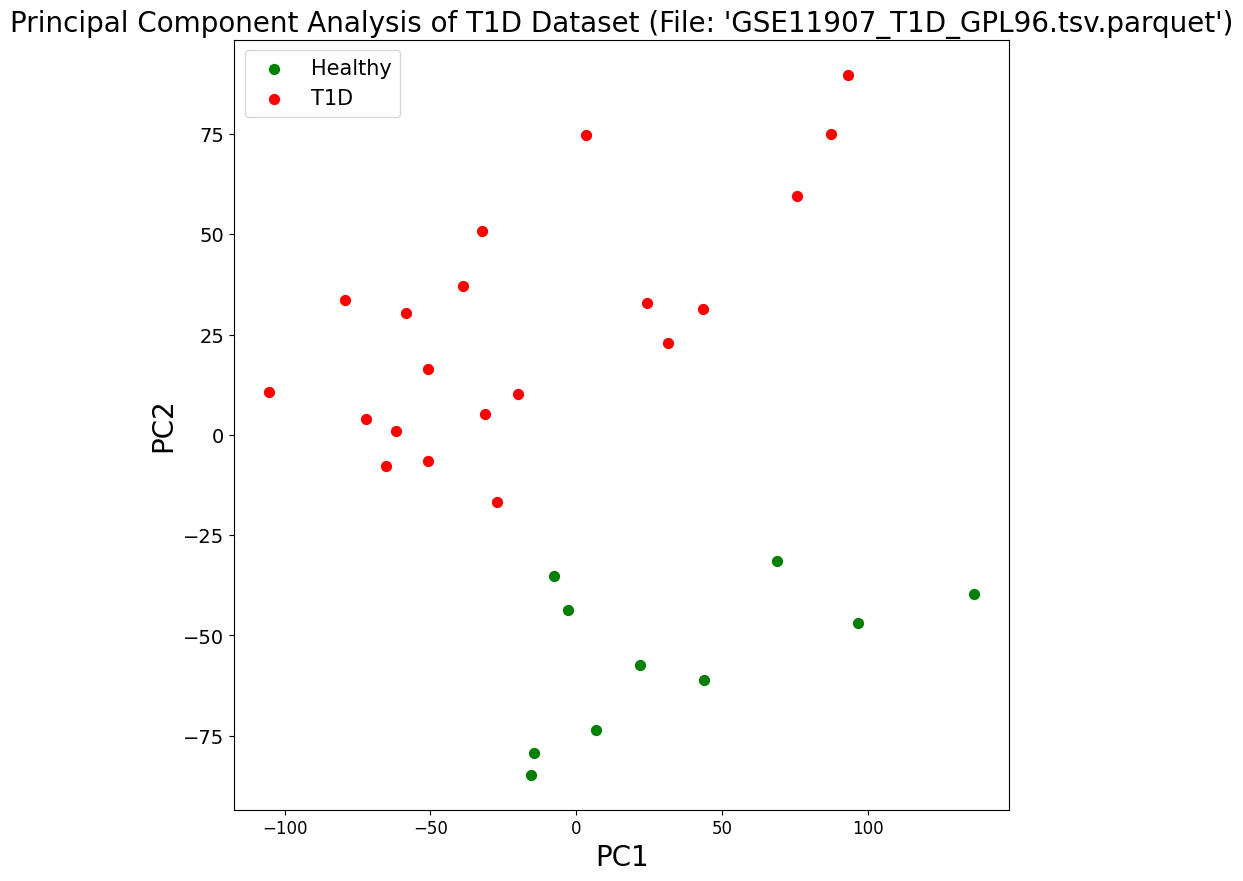

<Figure size 640x480 with 0 Axes>

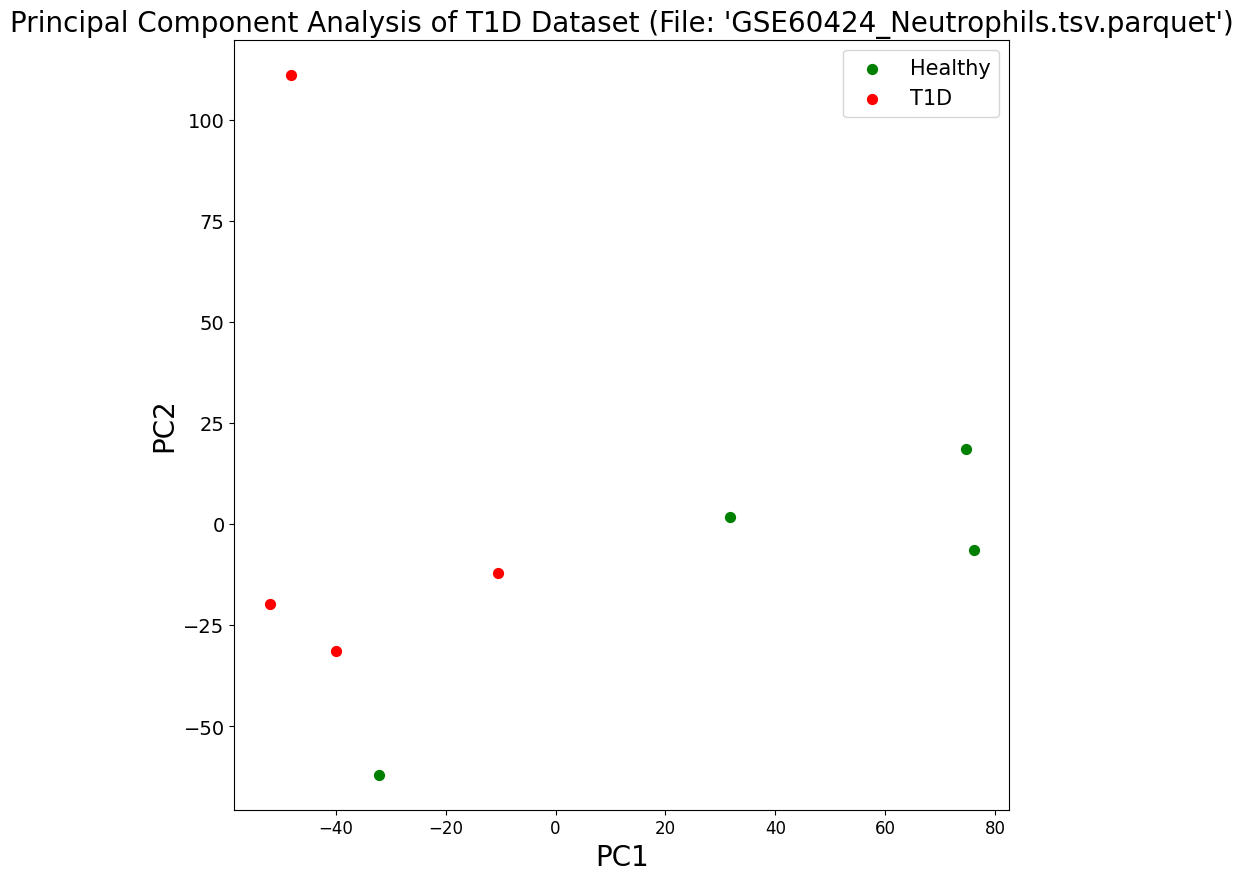

<Figure size 640x480 with 0 Axes>

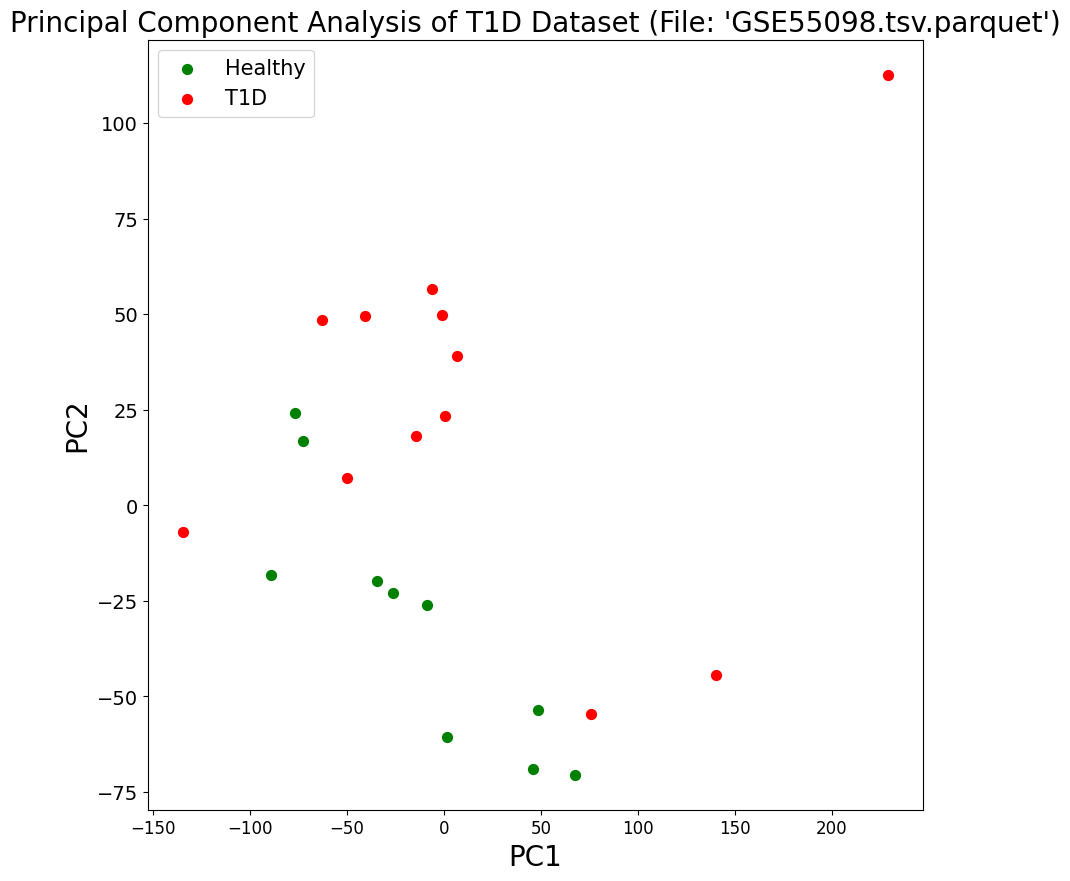

<Figure size 640x480 with 0 Axes>

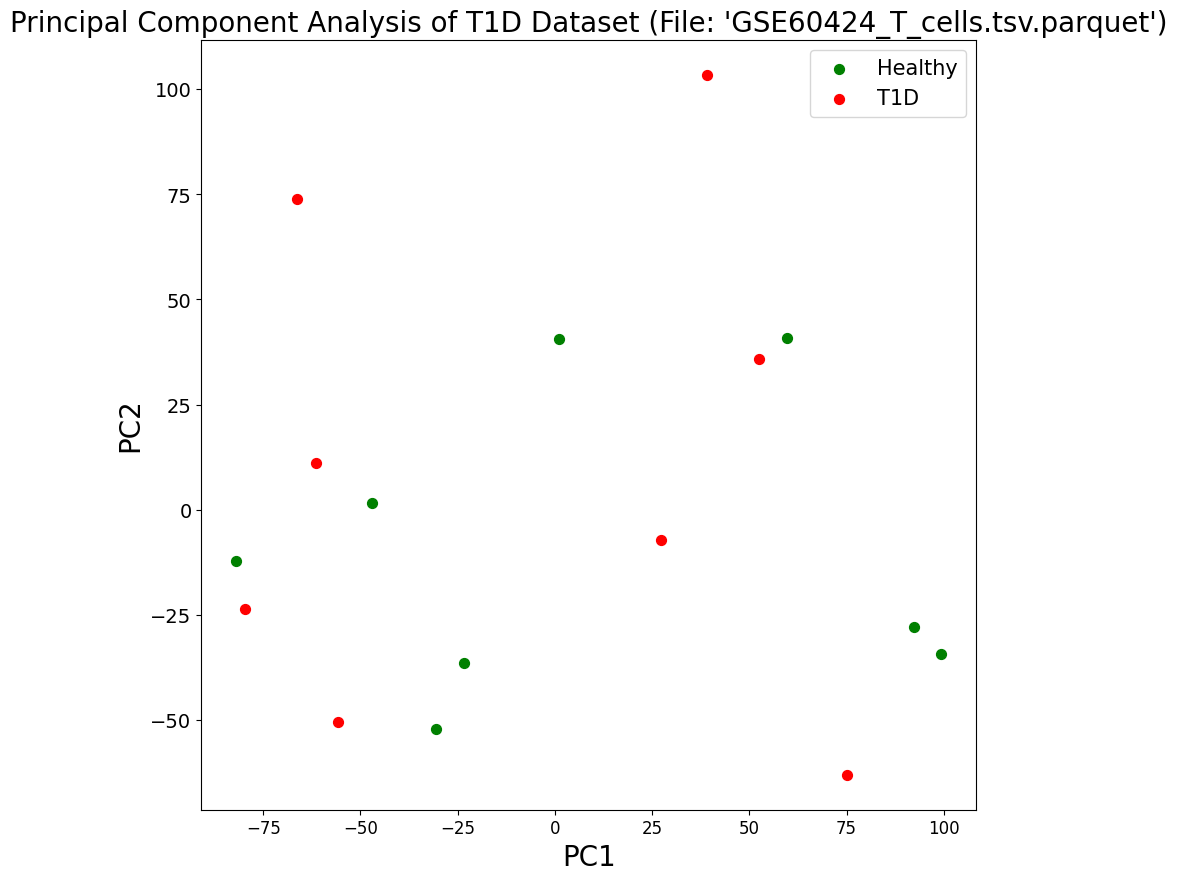

<Figure size 640x480 with 0 Axes>

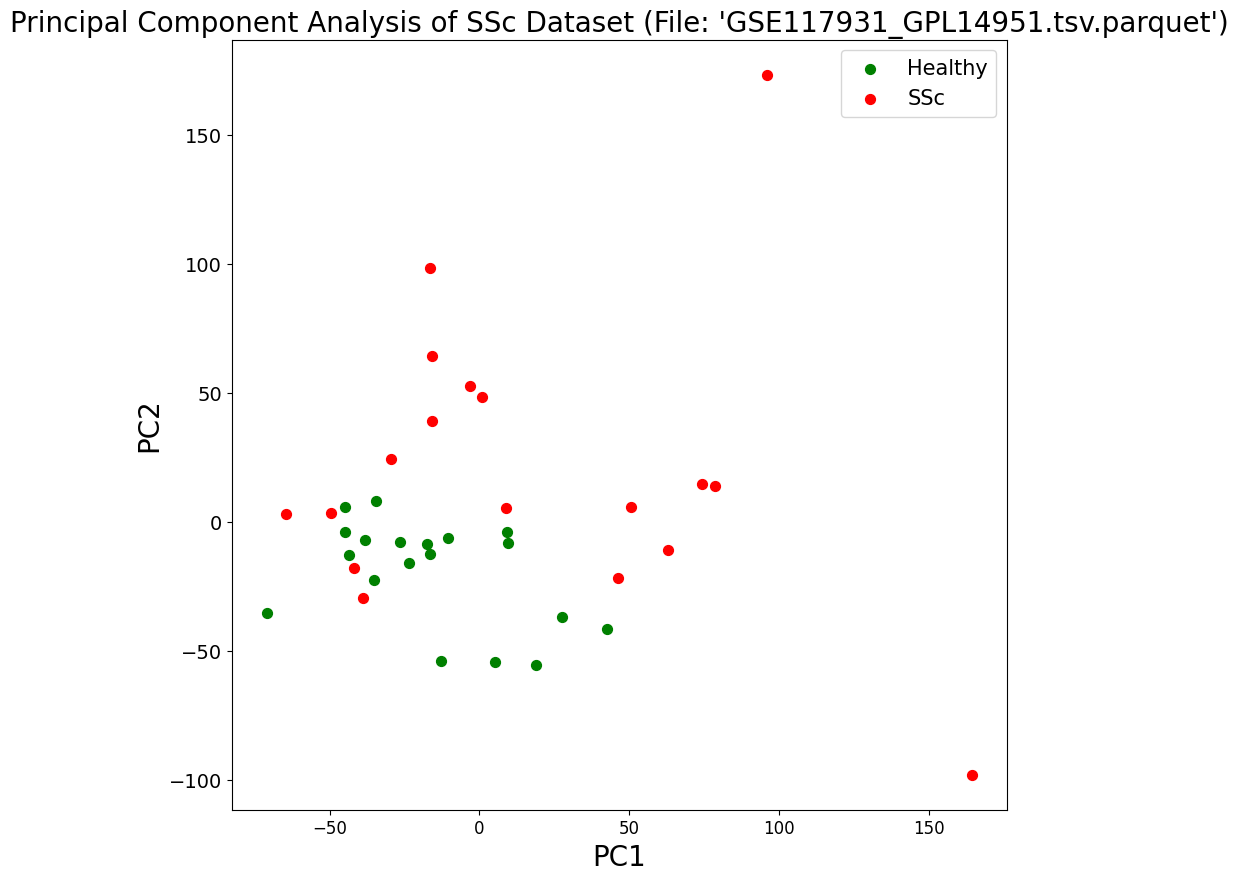

<Figure size 640x480 with 0 Axes>

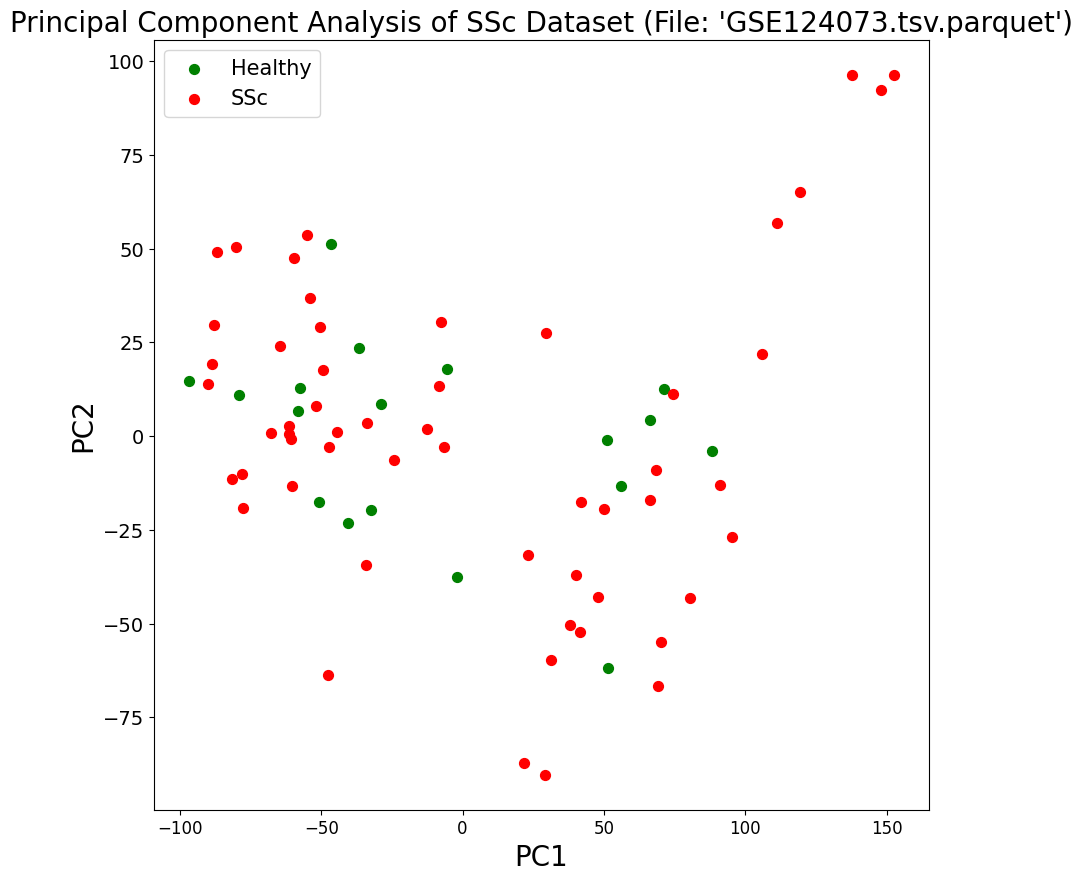

<Figure size 640x480 with 0 Axes>

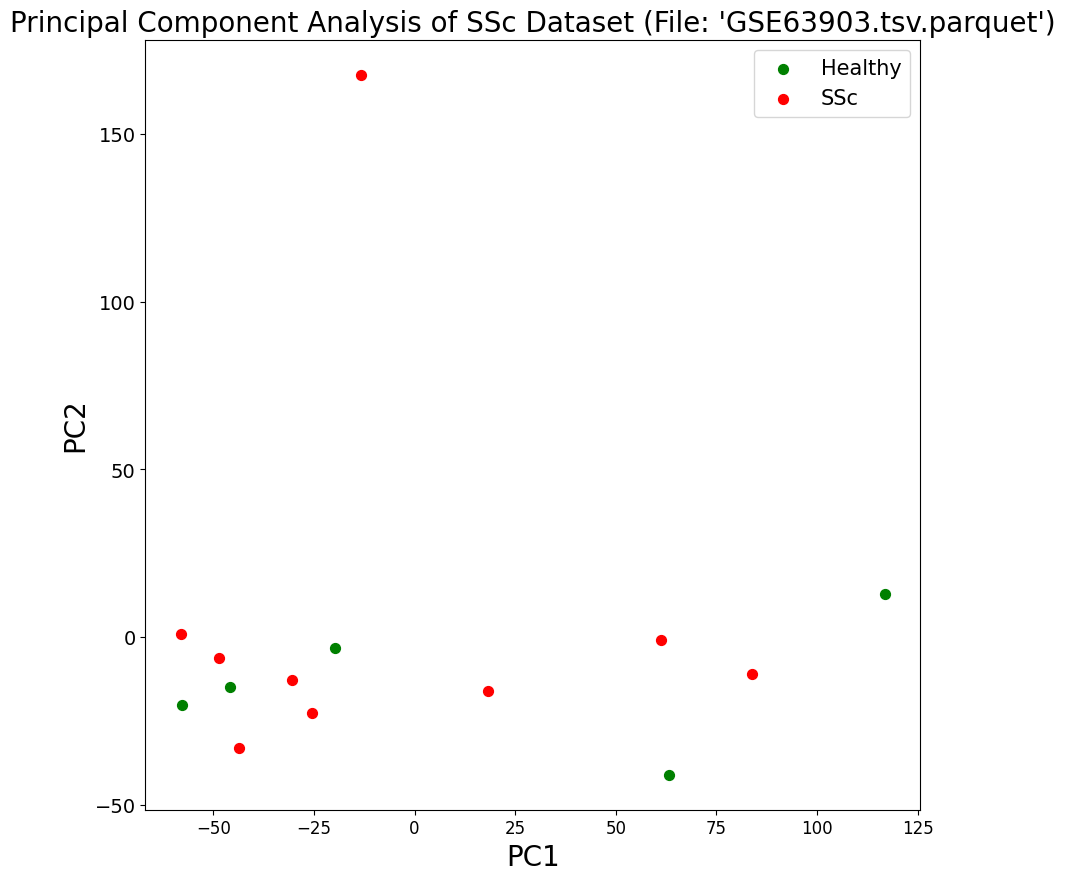

<Figure size 640x480 with 0 Axes>

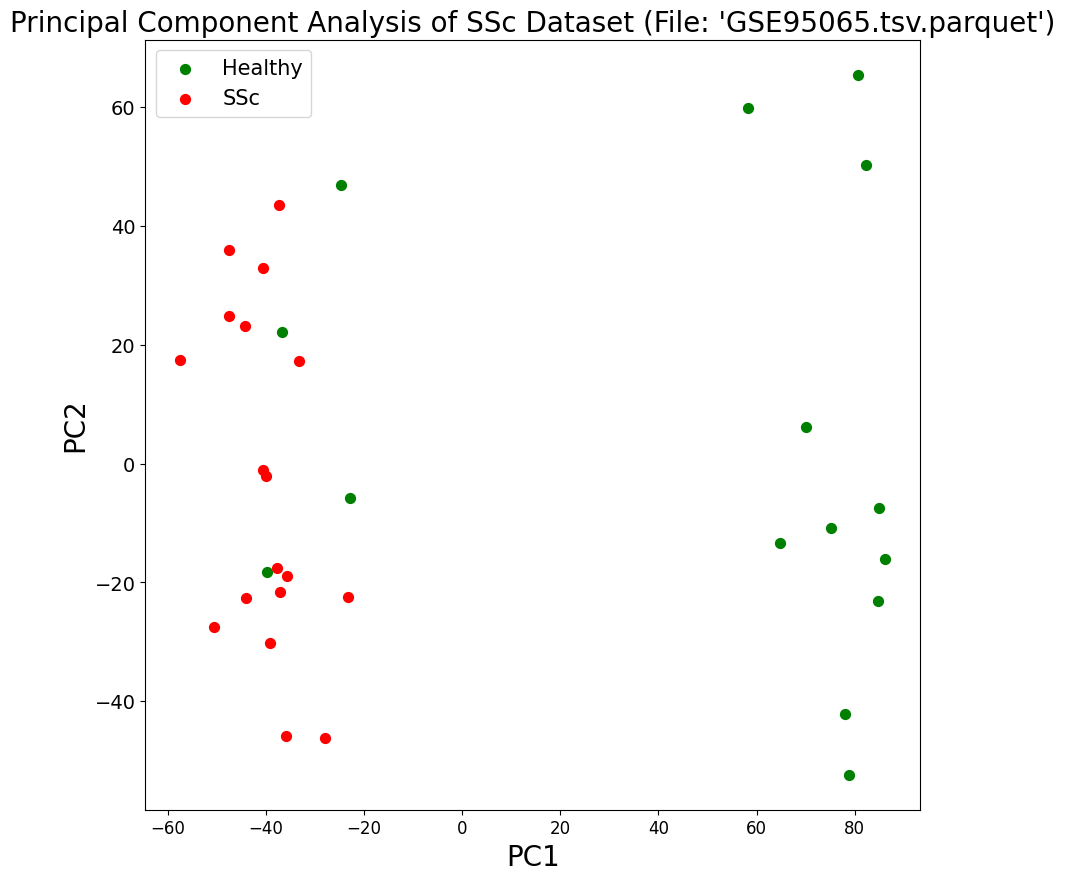

<Figure size 640x480 with 0 Axes>

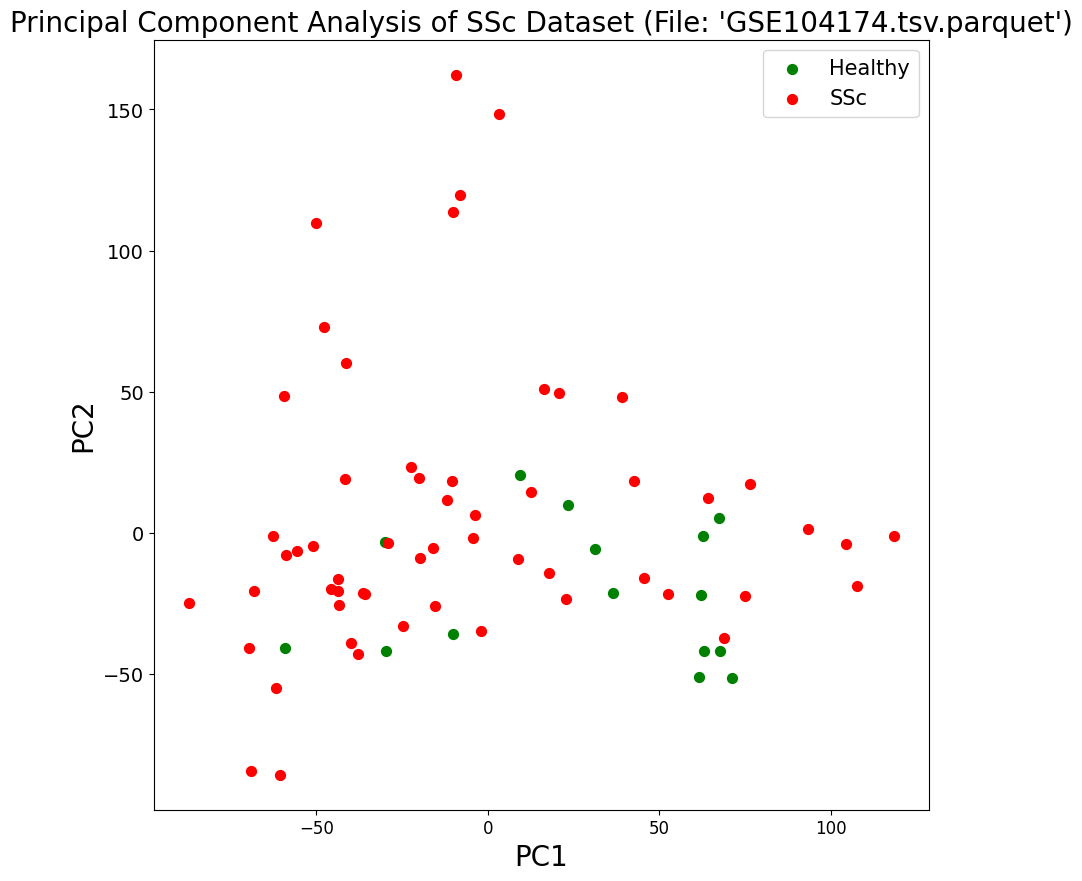

<Figure size 640x480 with 0 Axes>

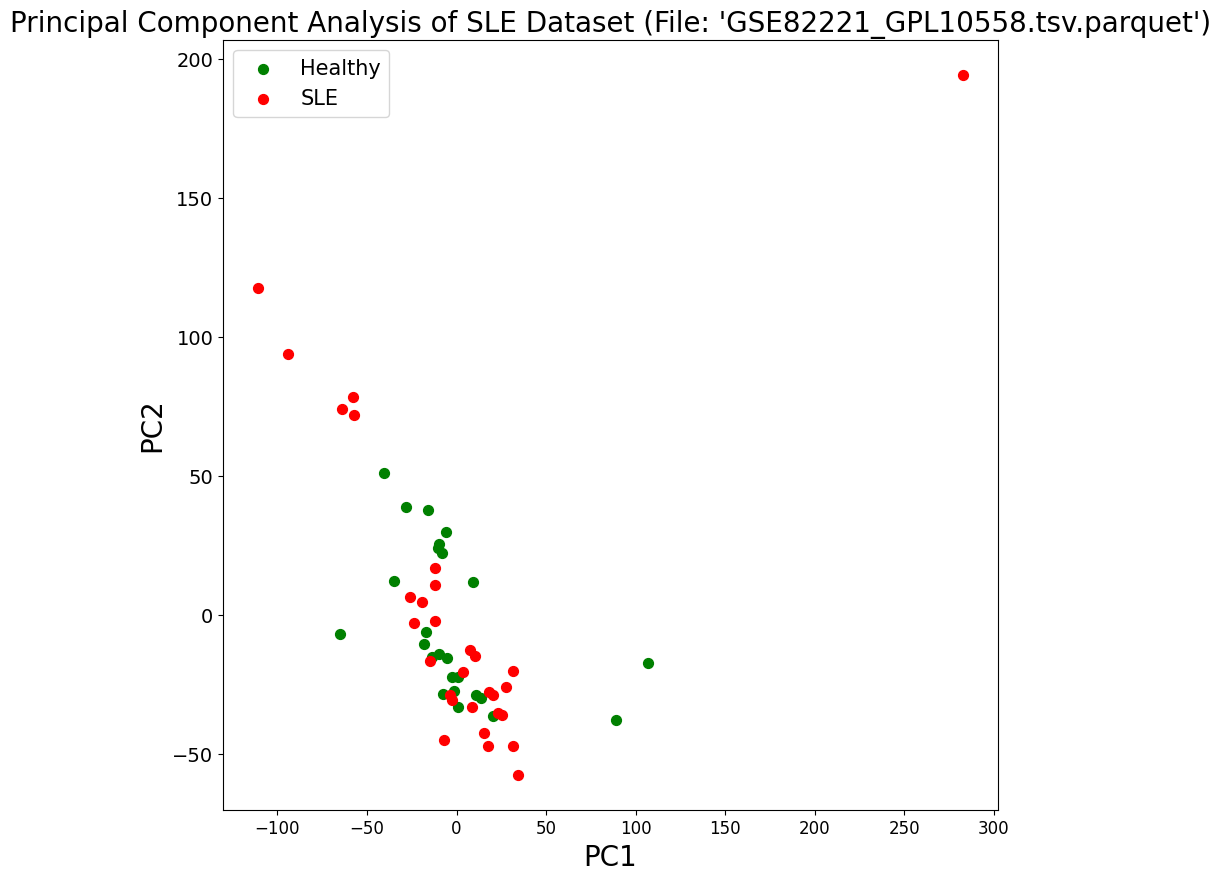

<Figure size 640x480 with 0 Axes>

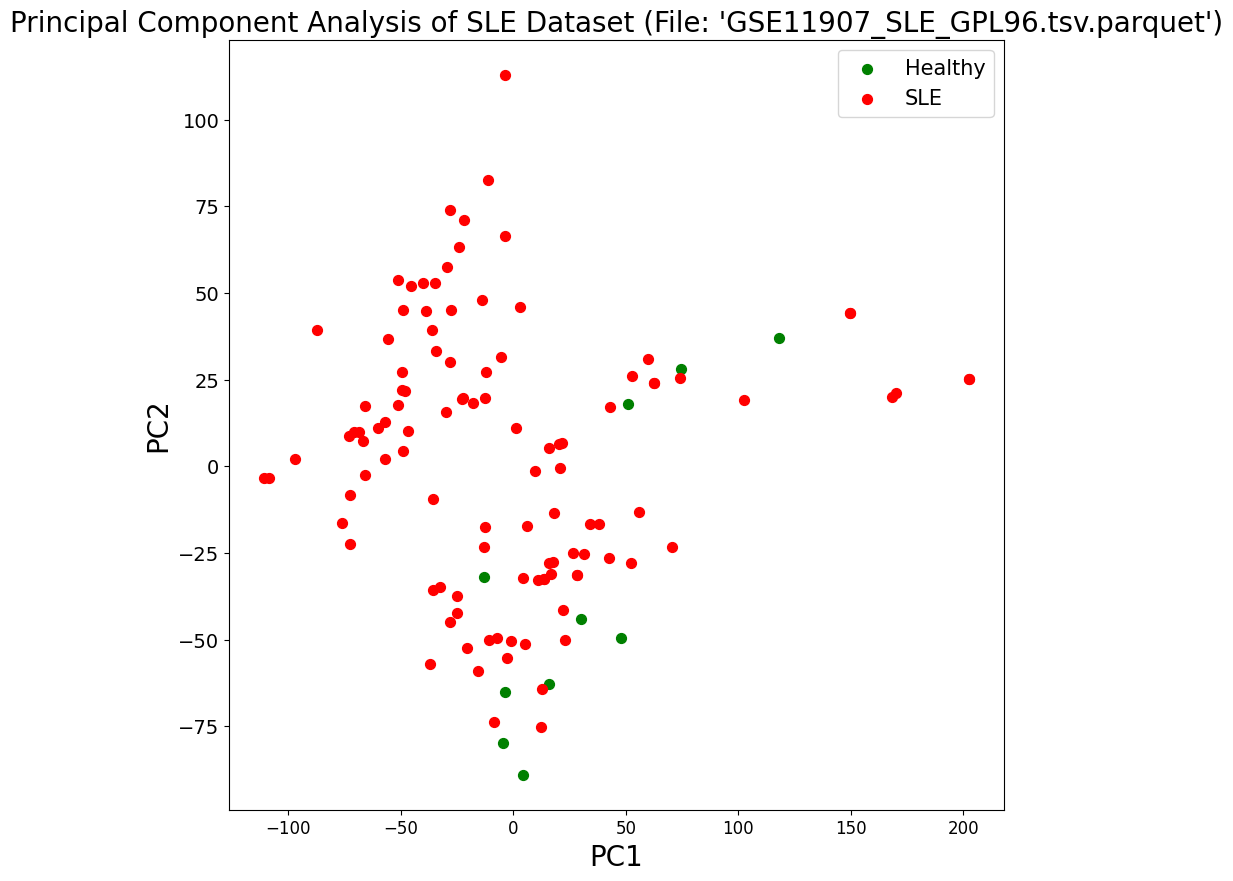

<Figure size 640x480 with 0 Axes>

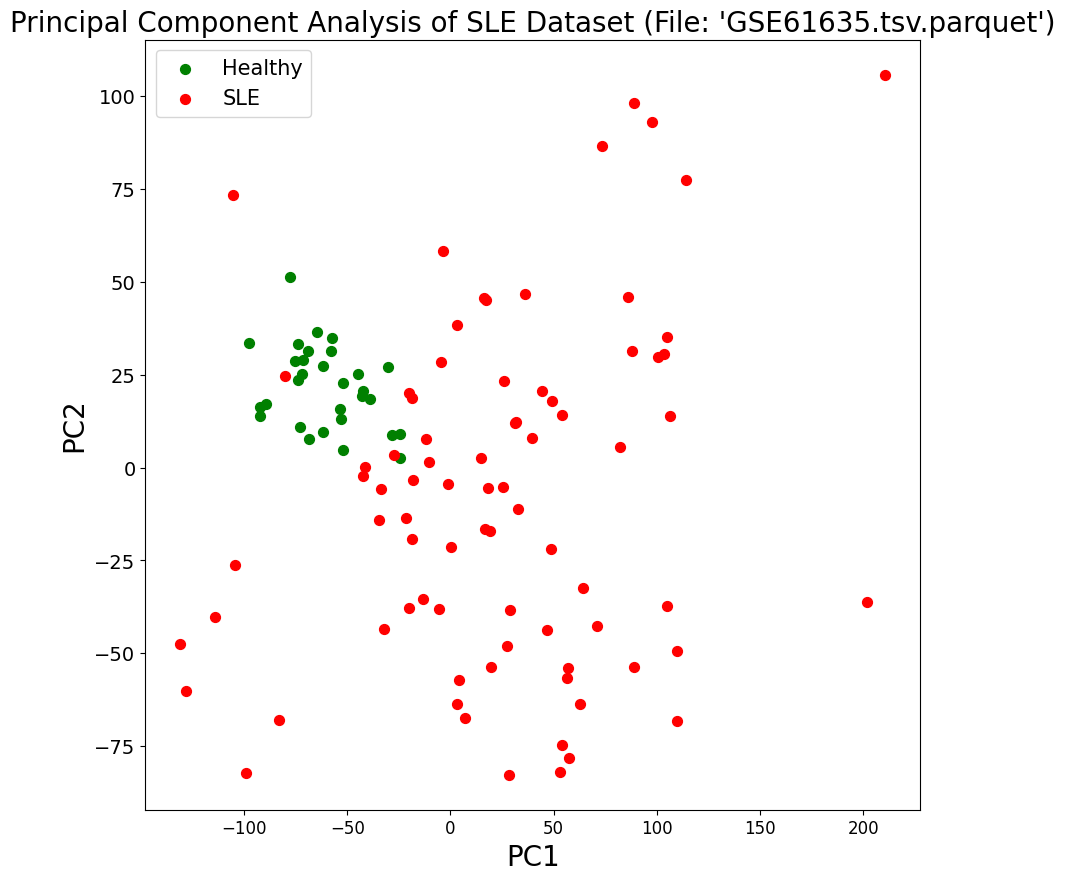

<Figure size 640x480 with 0 Axes>

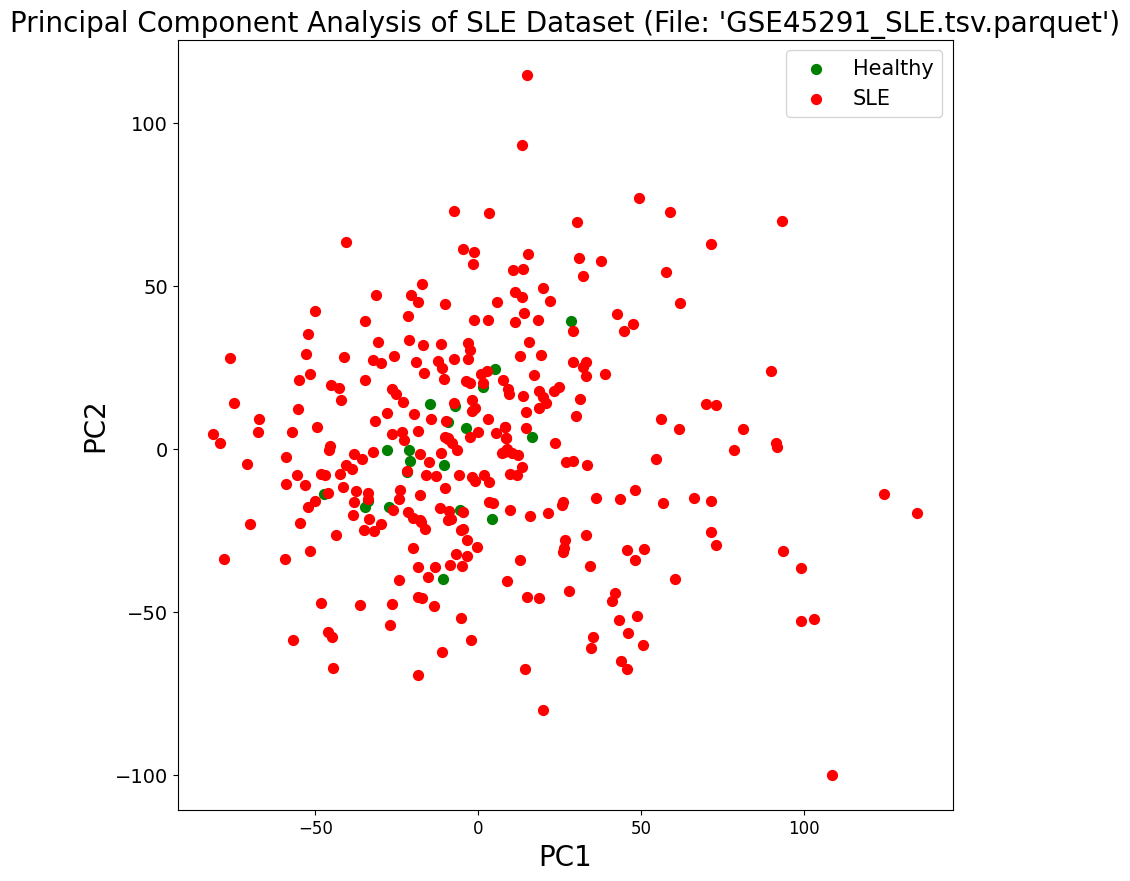

<Figure size 640x480 with 0 Axes>

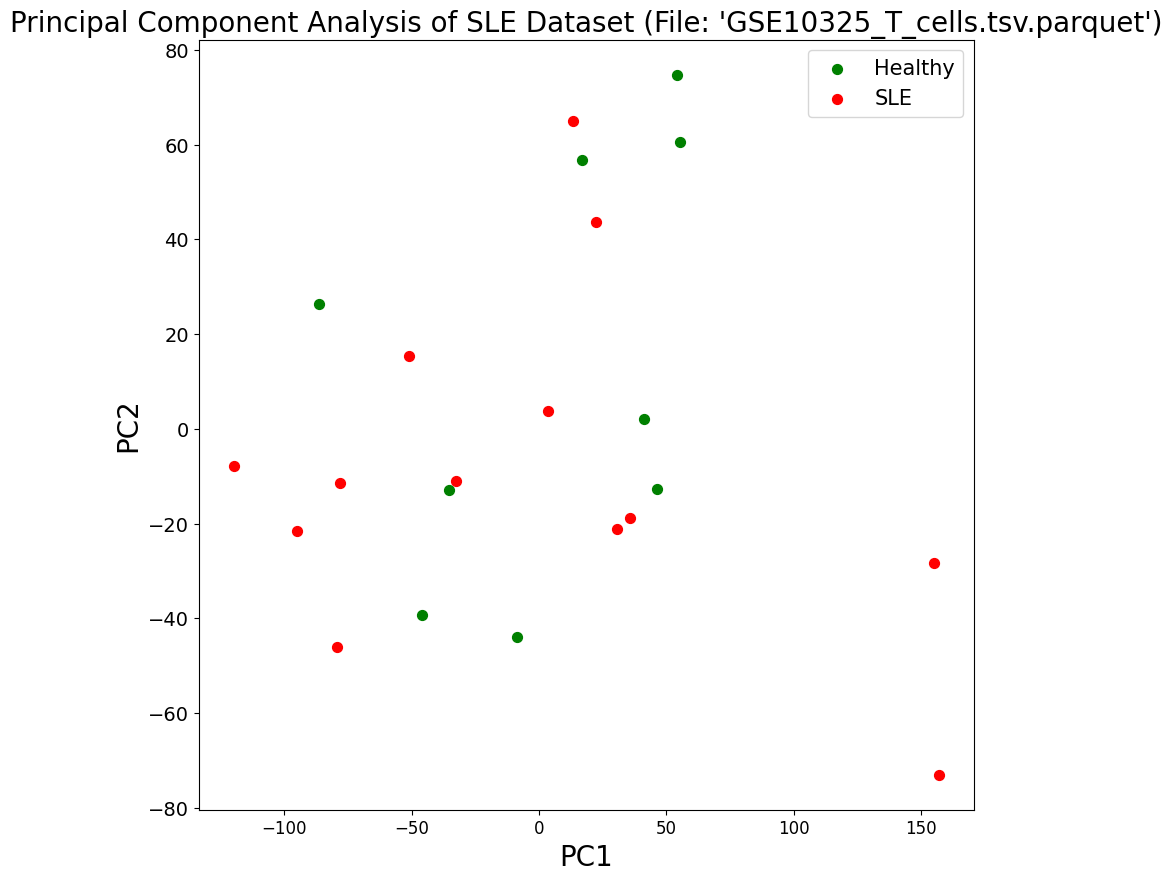

<Figure size 640x480 with 0 Axes>

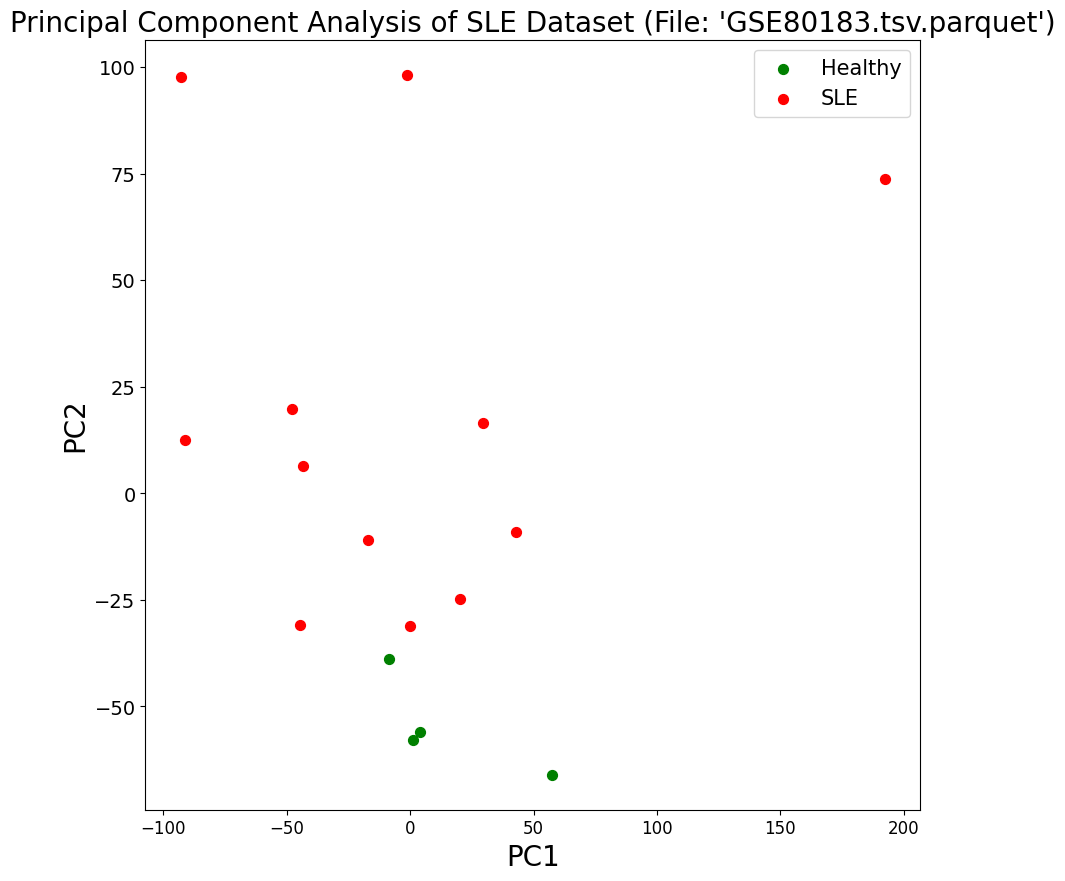

<Figure size 640x480 with 0 Axes>

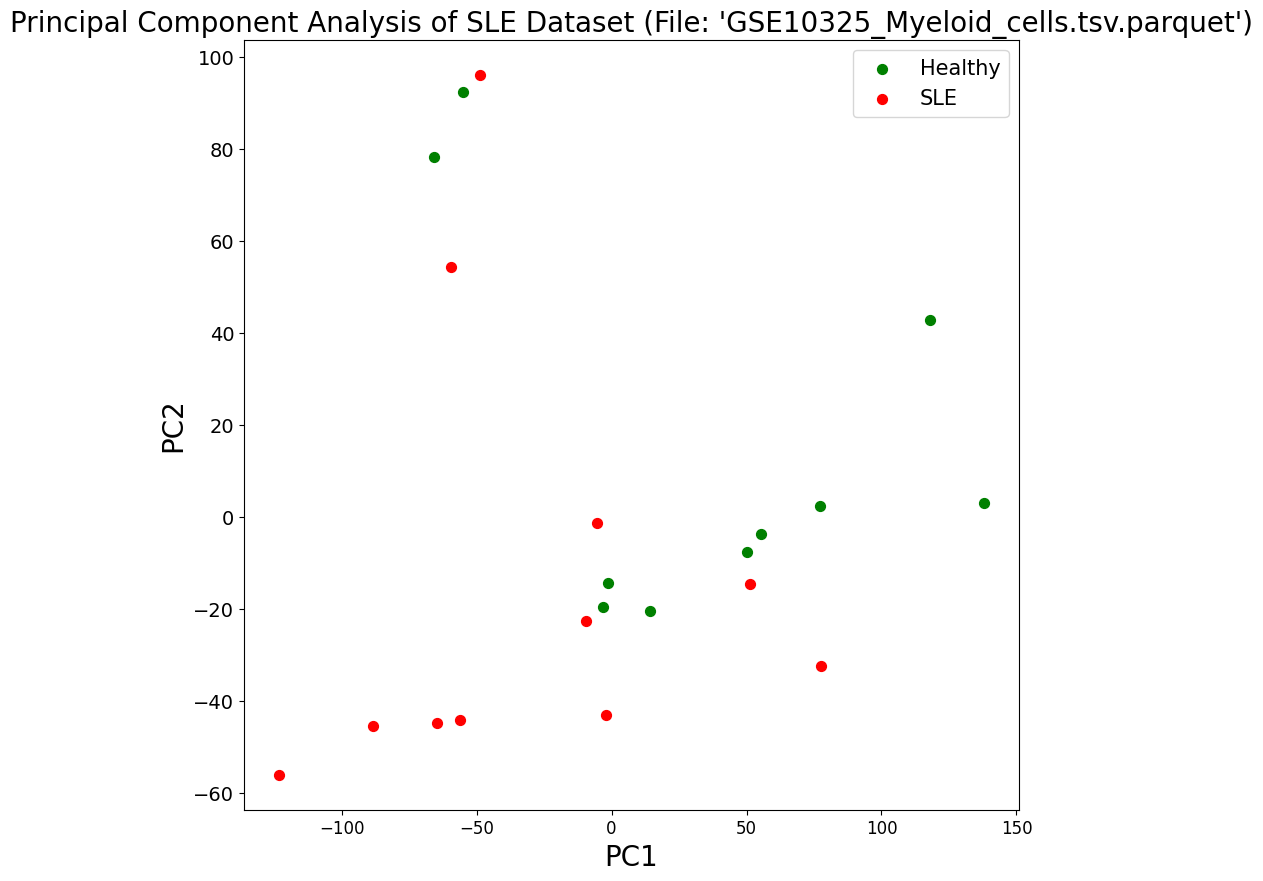

<Figure size 640x480 with 0 Axes>

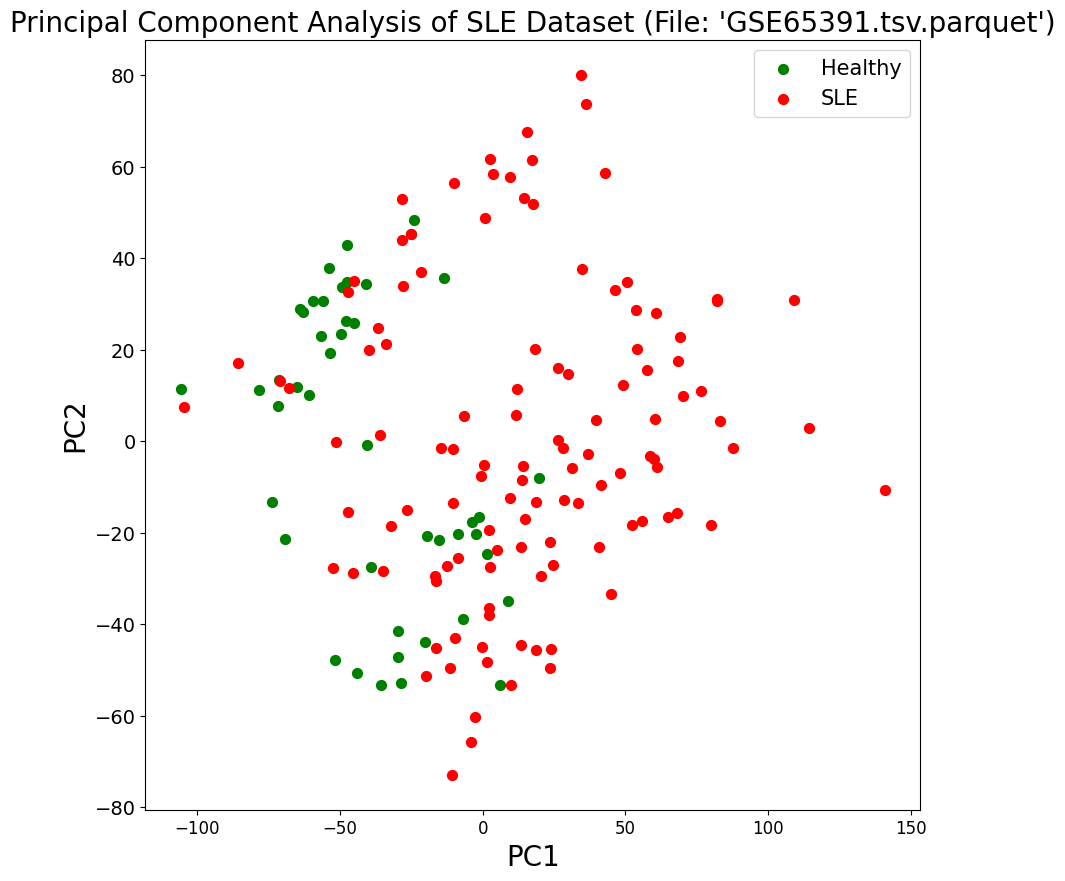

<Figure size 640x480 with 0 Axes>

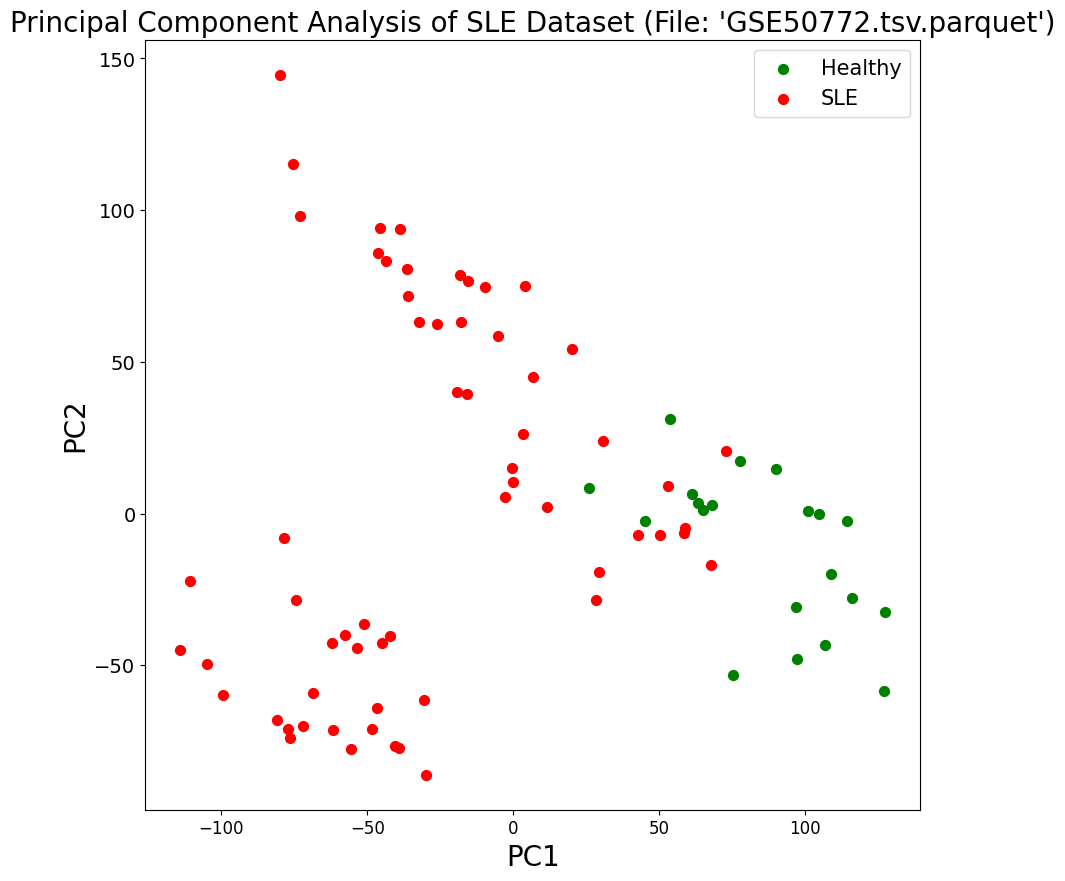

<Figure size 640x480 with 0 Axes>

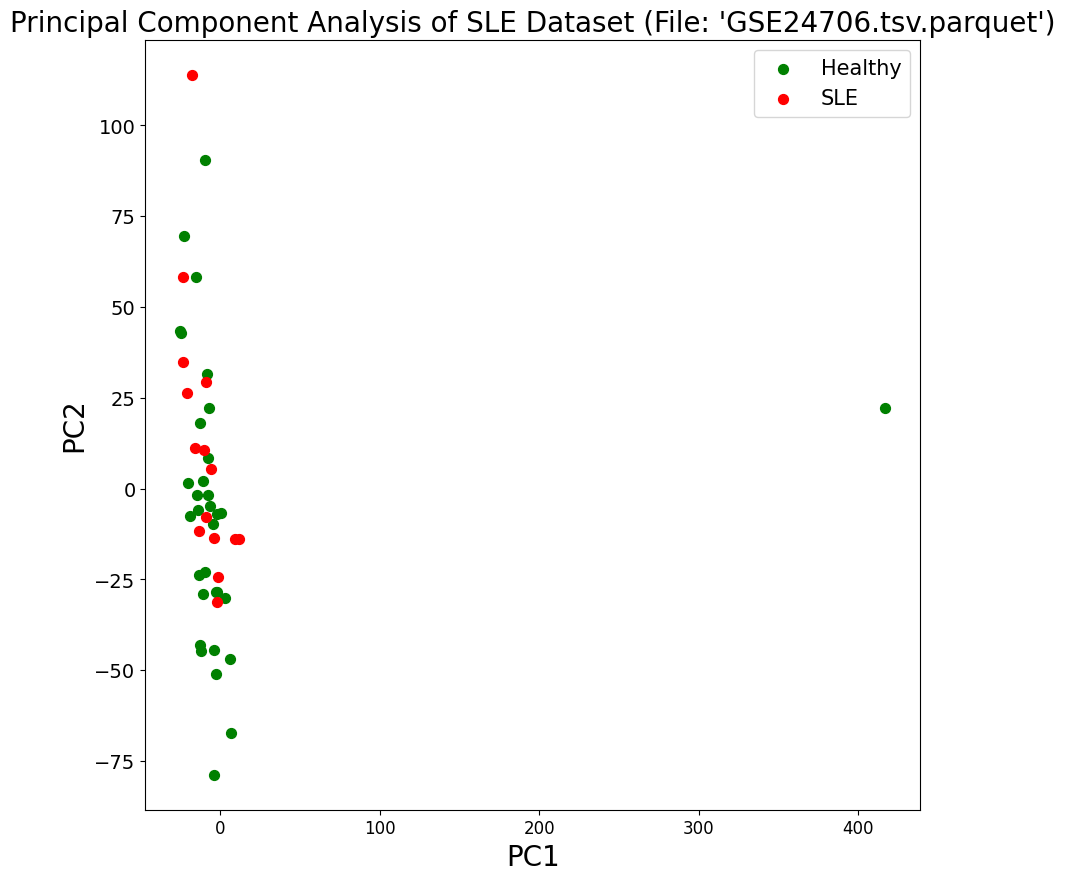

<Figure size 640x480 with 0 Axes>

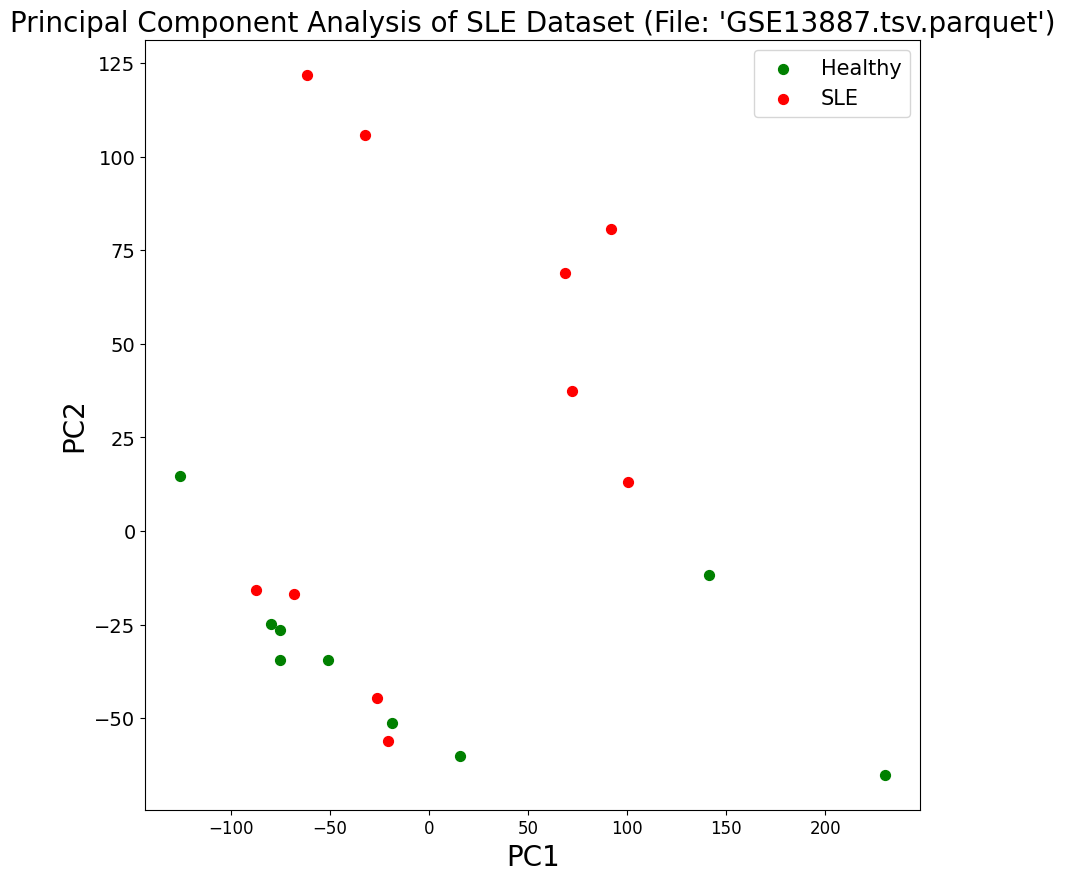

<Figure size 640x480 with 0 Axes>

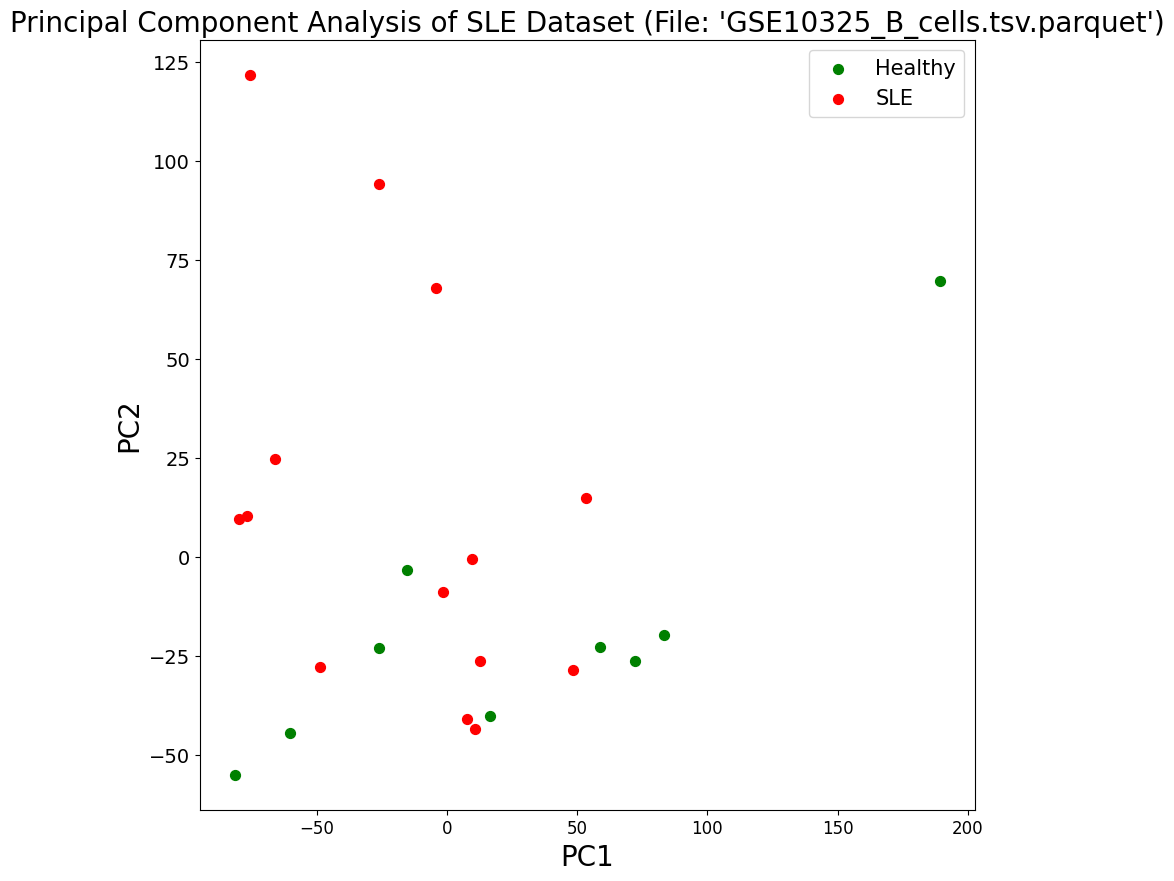

<Figure size 640x480 with 0 Axes>

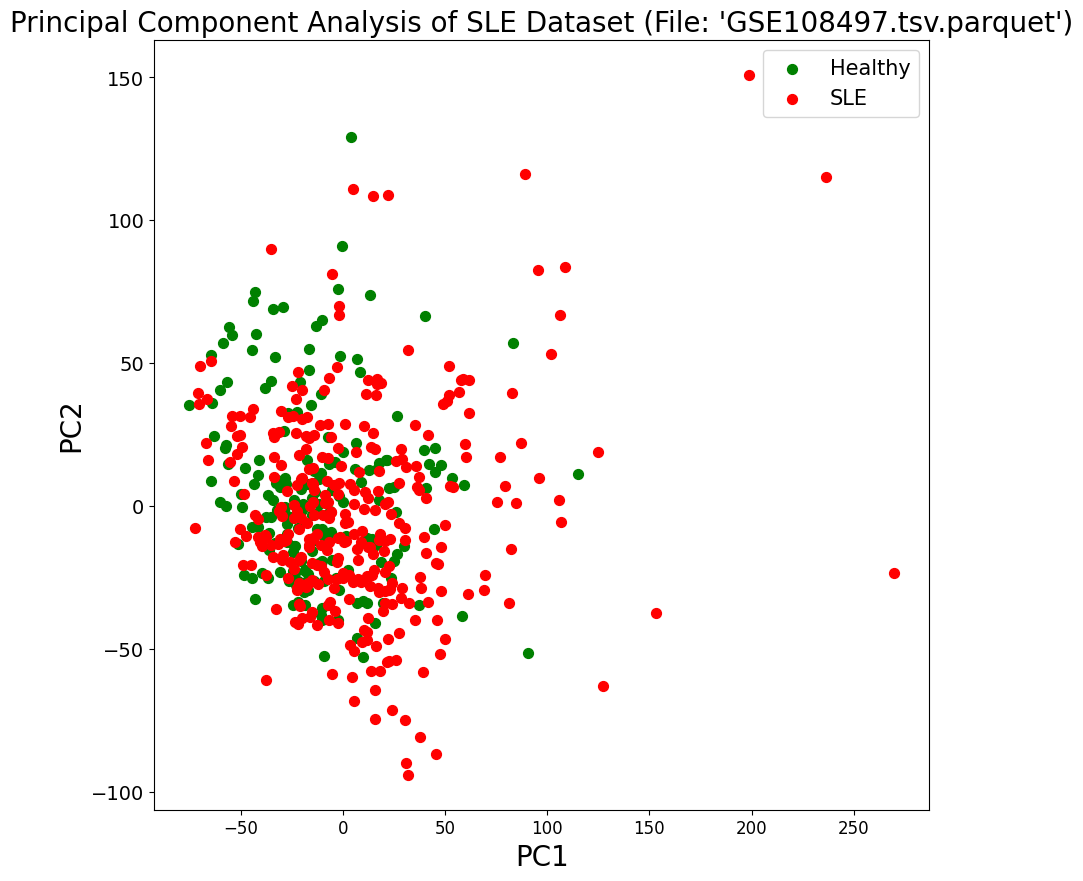

<Figure size 640x480 with 0 Axes>

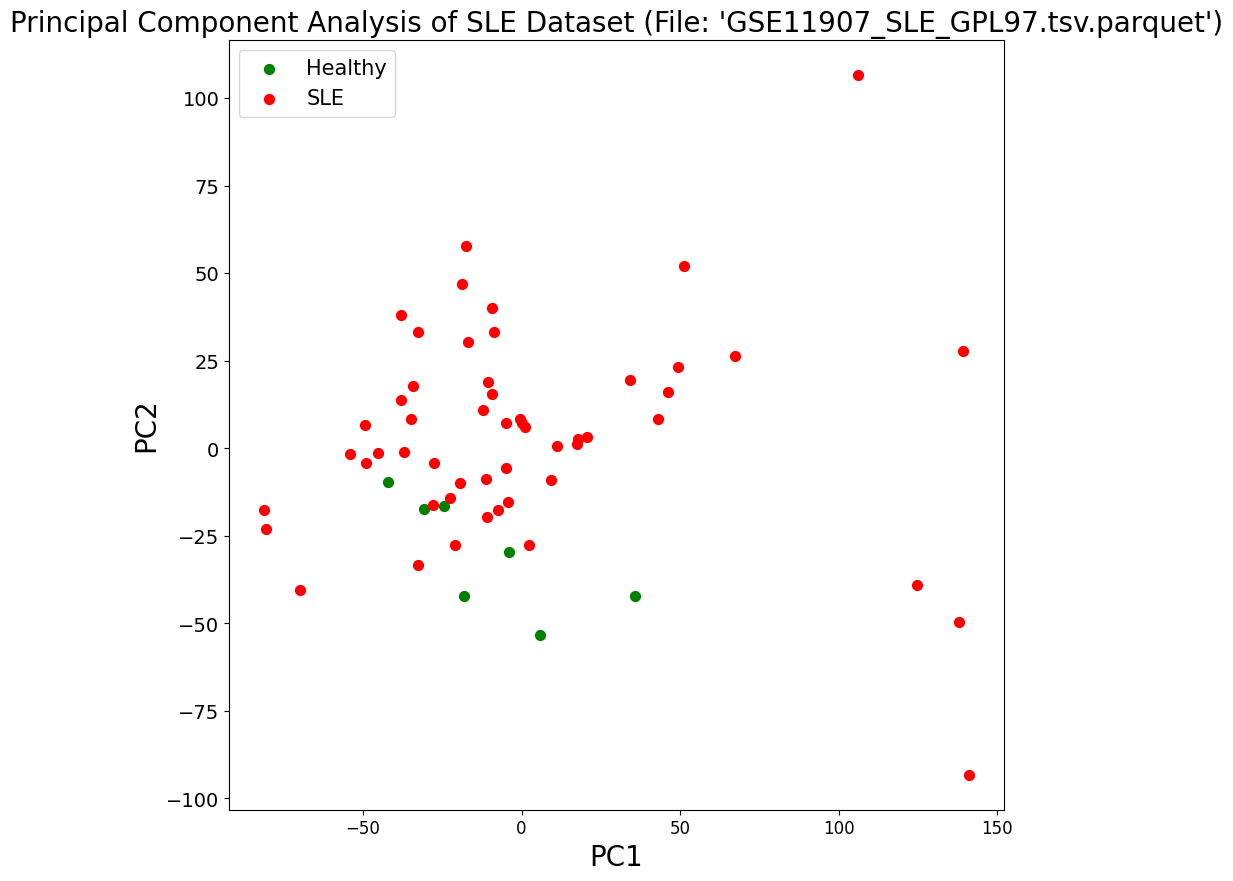

<Figure size 640x480 with 0 Axes>

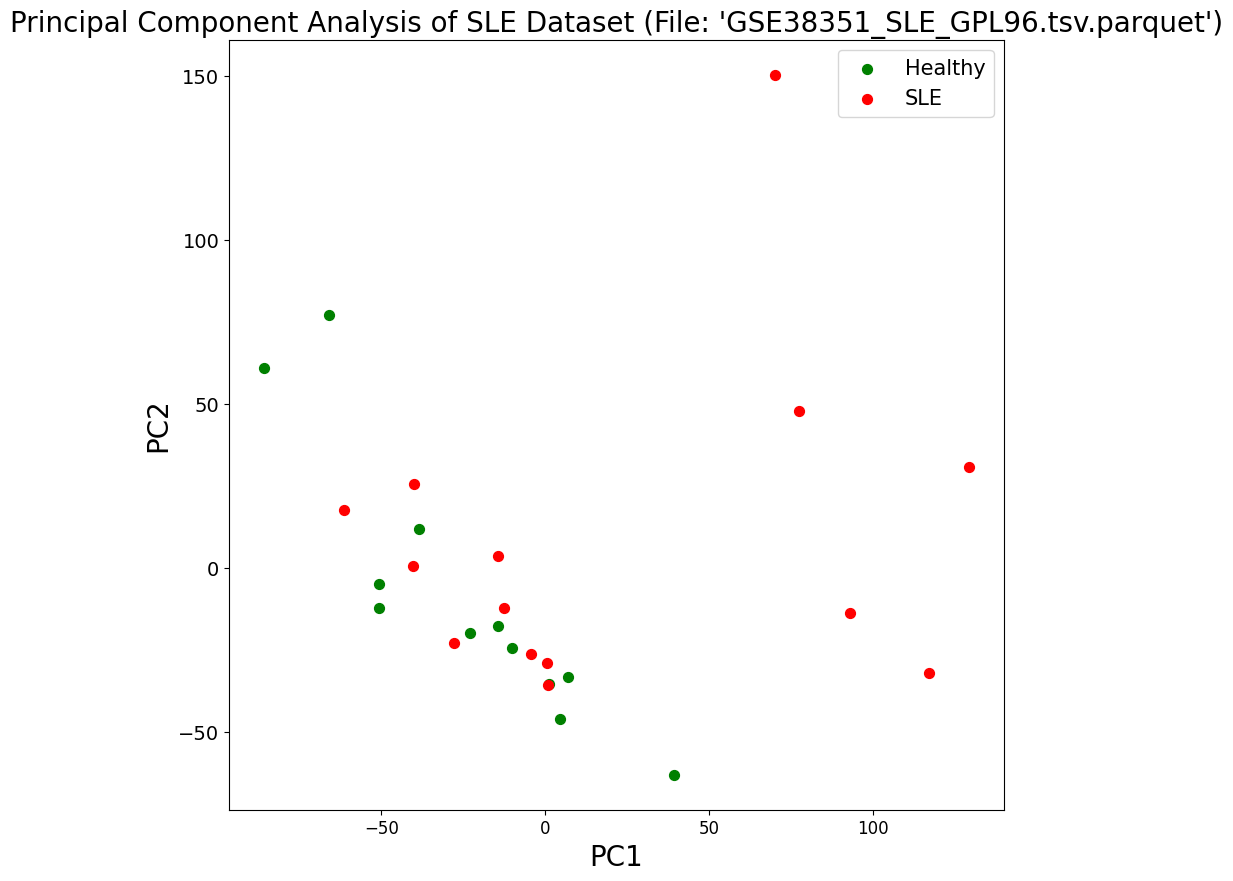

<Figure size 640x480 with 0 Axes>

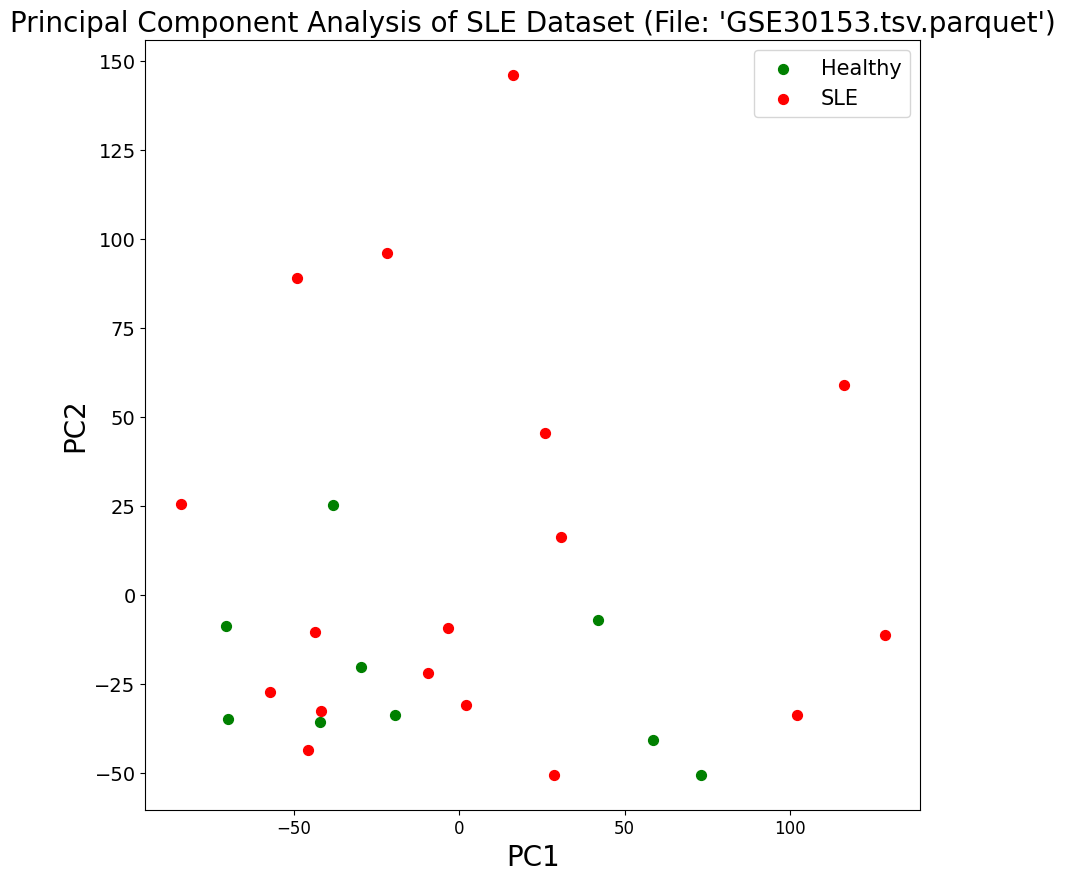

<Figure size 640x480 with 0 Axes>

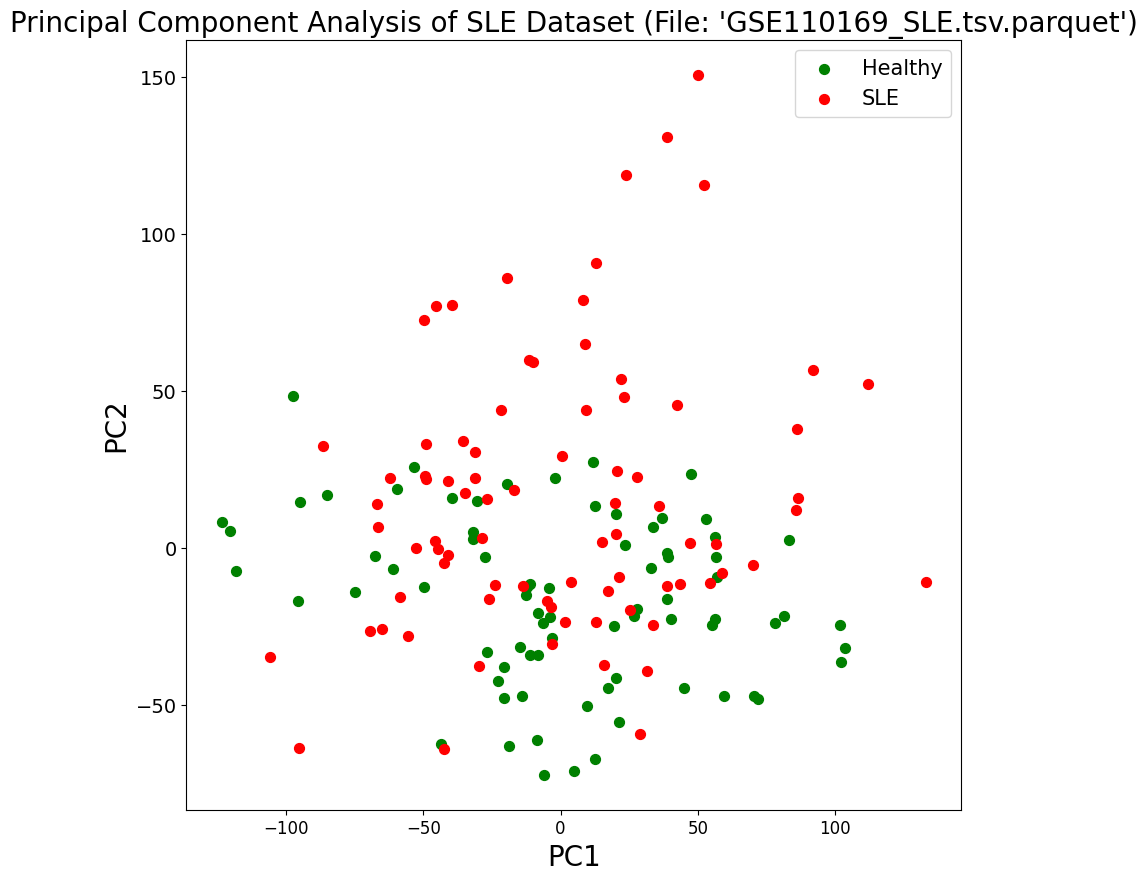

<Figure size 640x480 with 0 Axes>

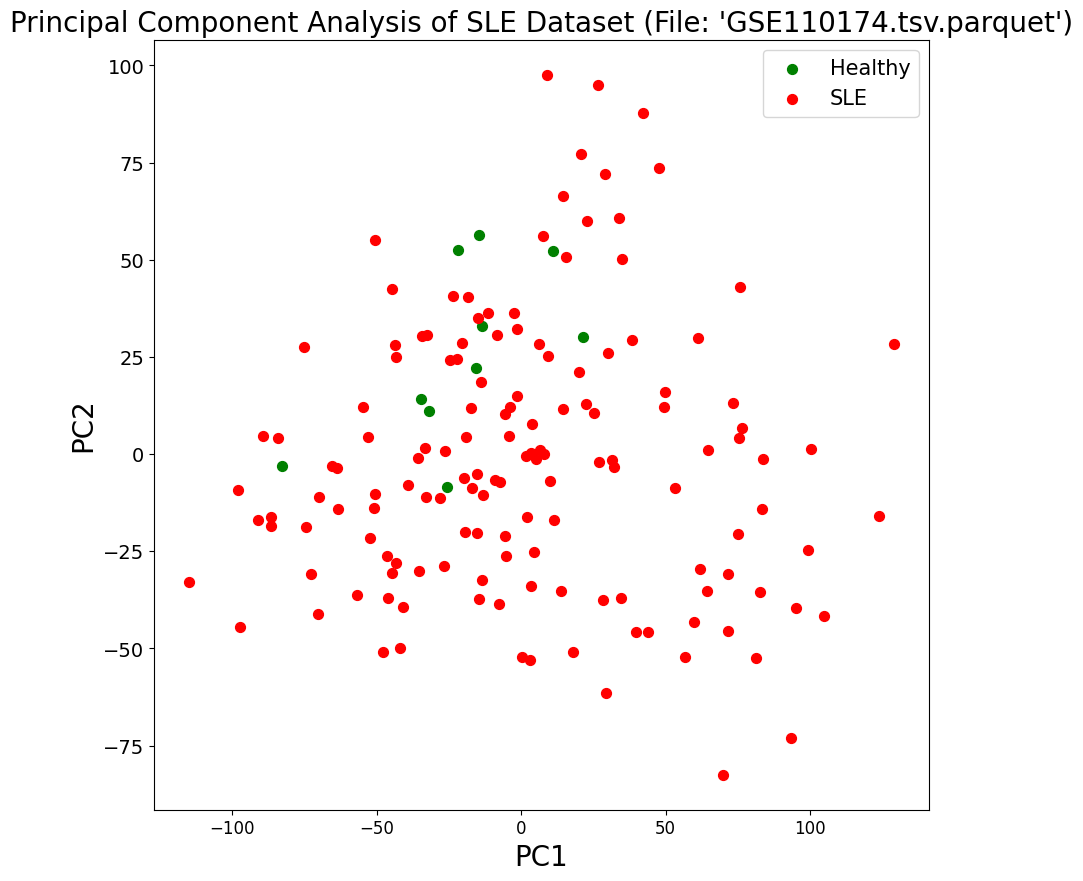

<Figure size 640x480 with 0 Axes>

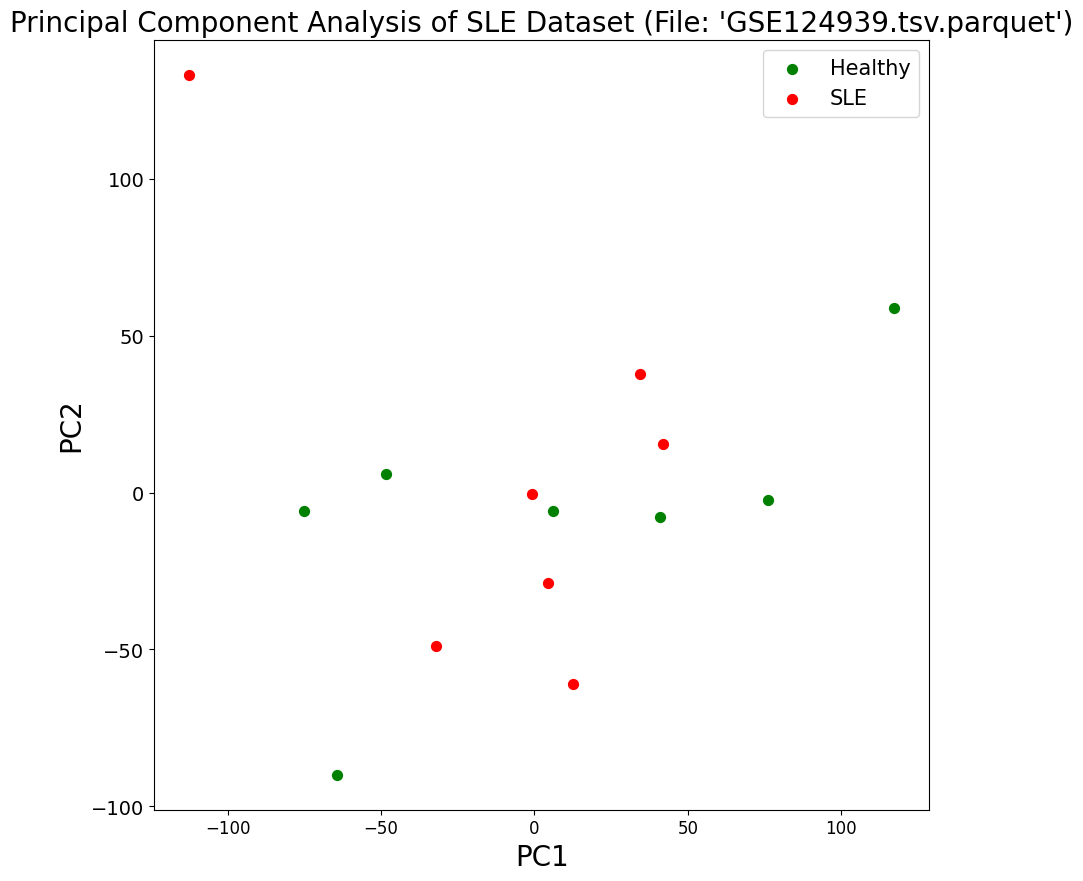

<Figure size 640x480 with 0 Axes>

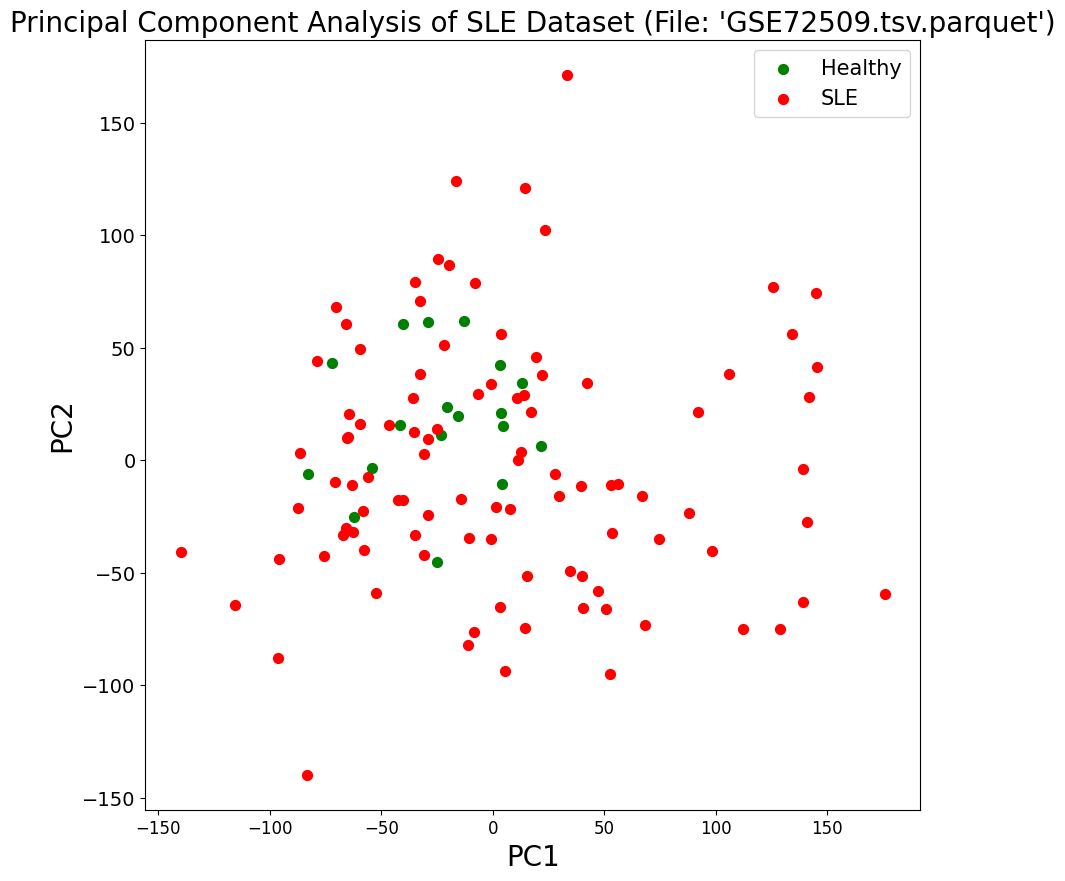

<Figure size 640x480 with 0 Axes>

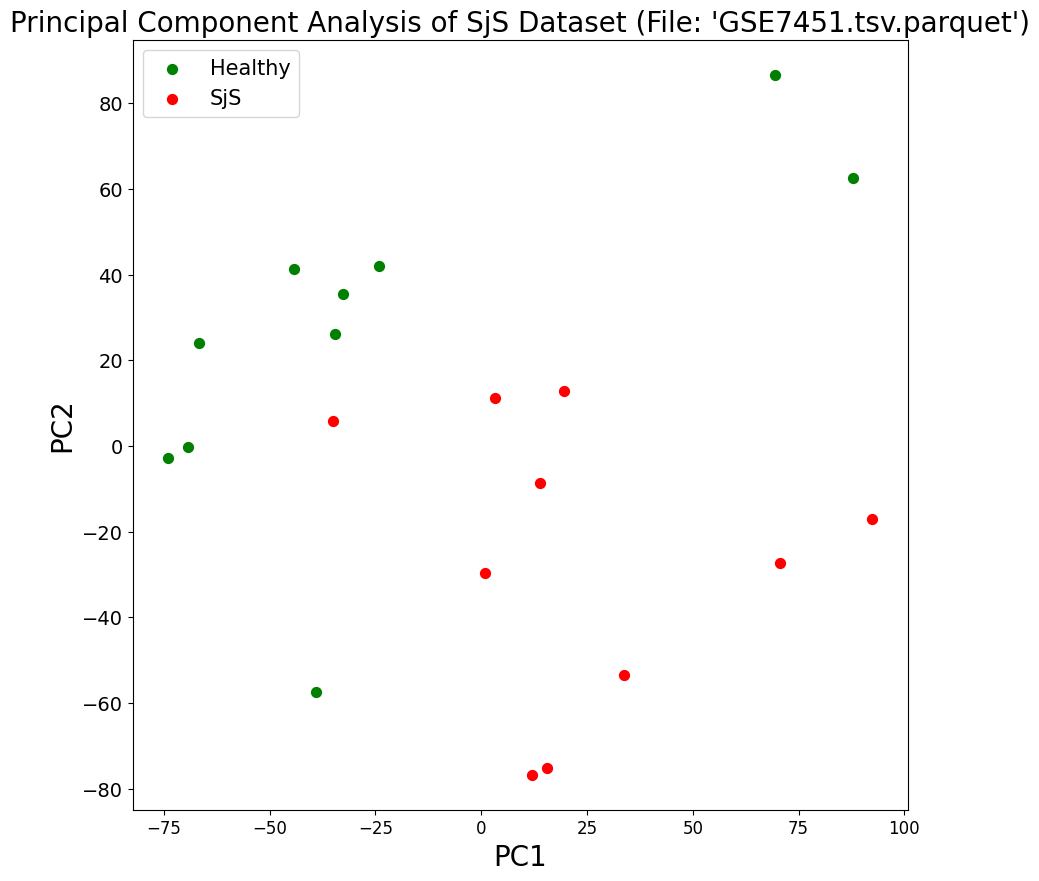

<Figure size 640x480 with 0 Axes>

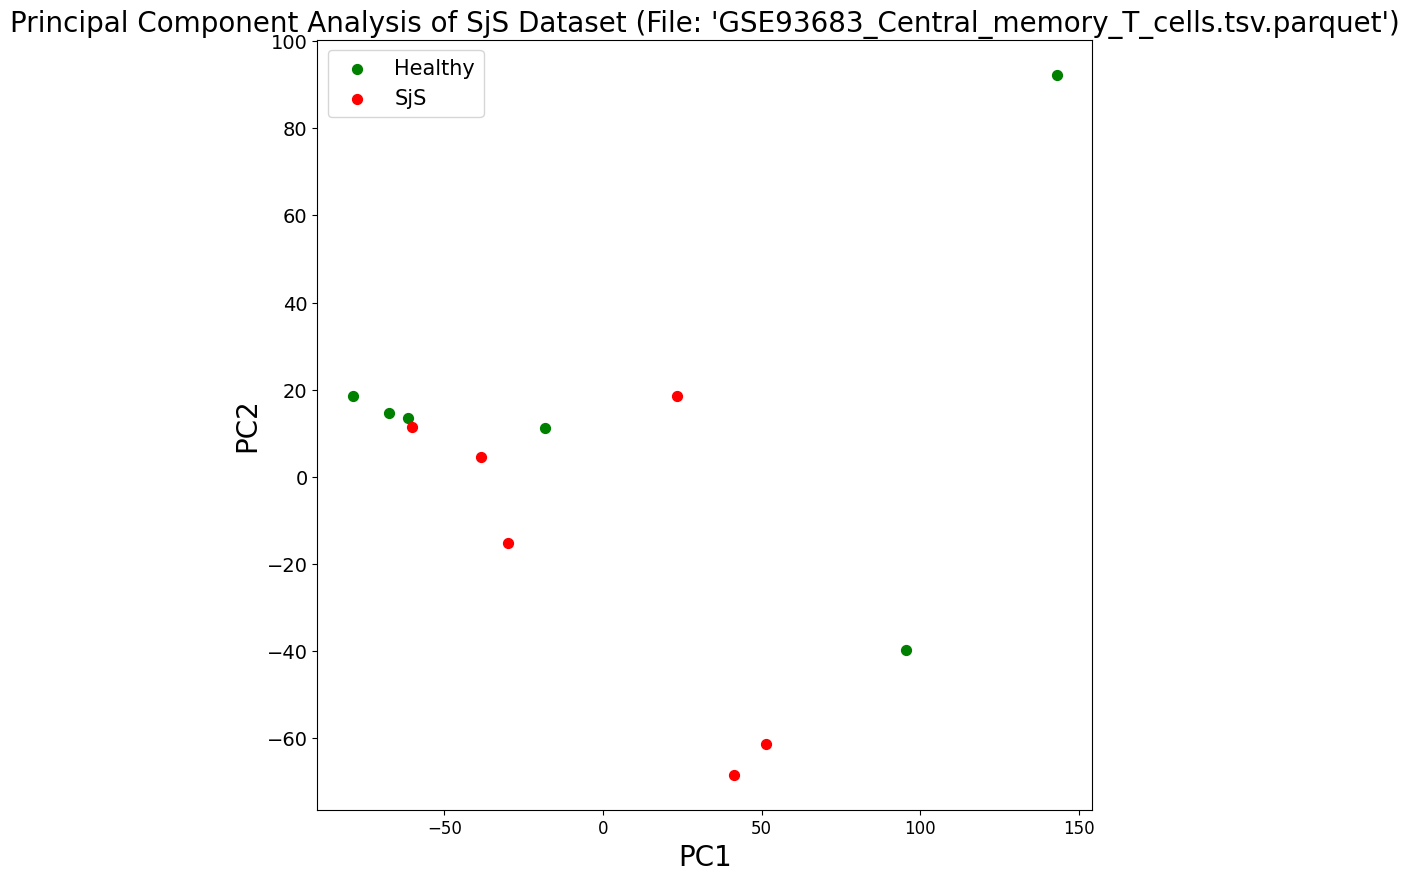

<Figure size 640x480 with 0 Axes>

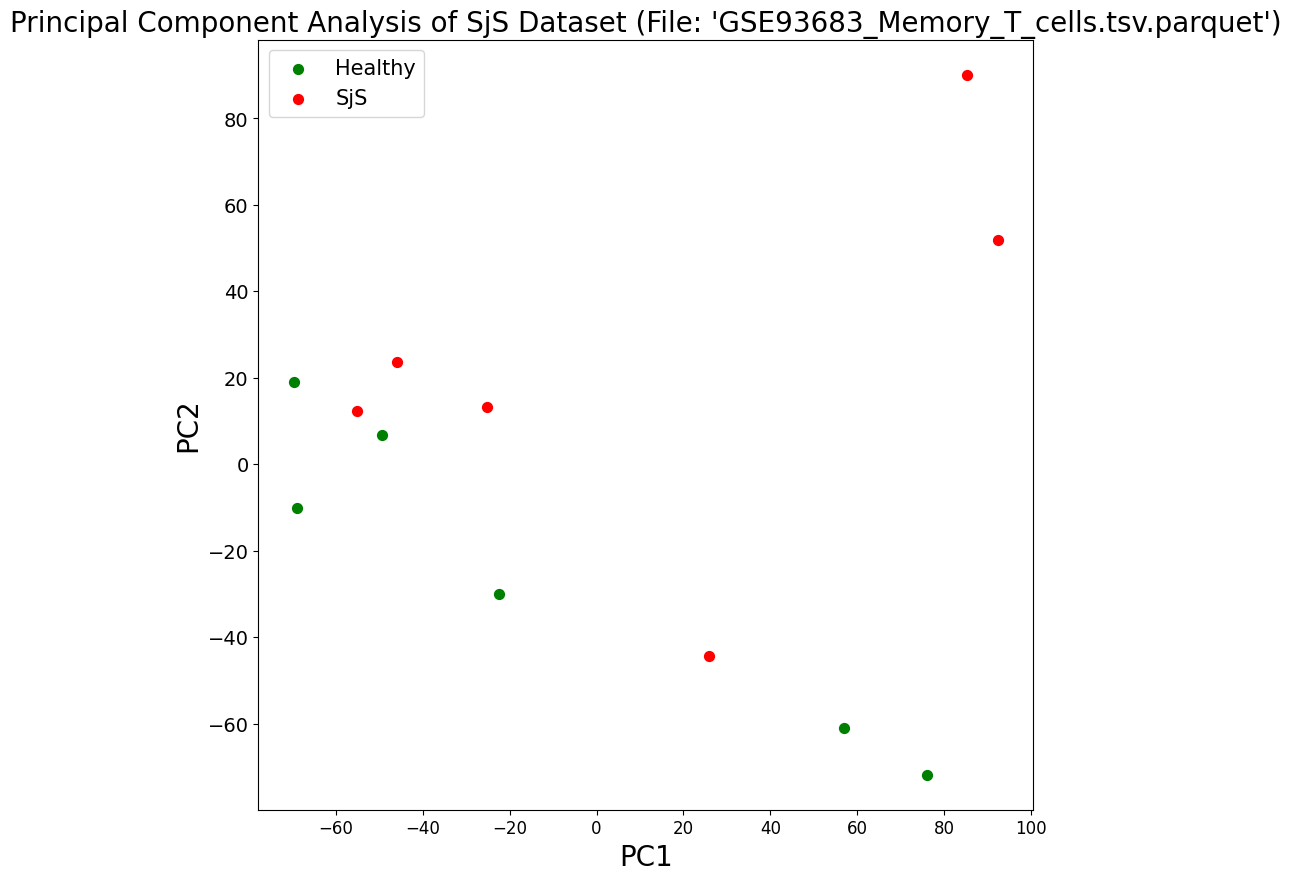

<Figure size 640x480 with 0 Axes>

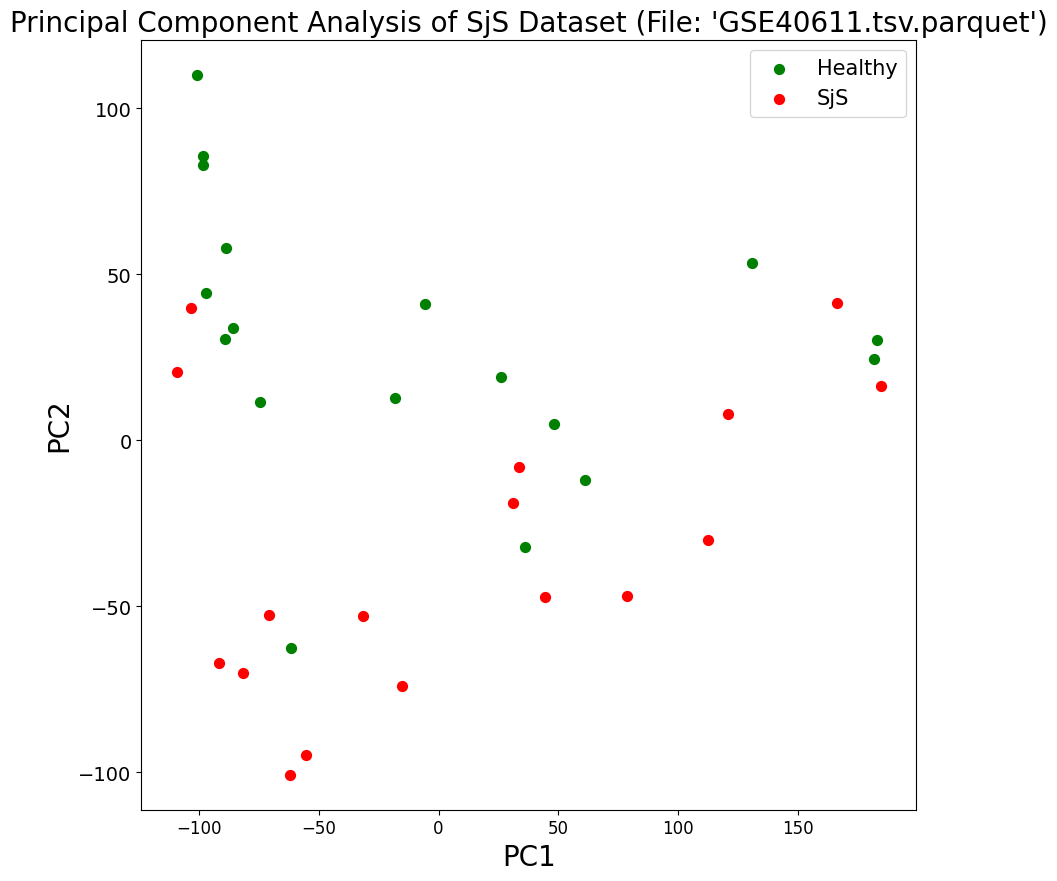

<Figure size 640x480 with 0 Axes>

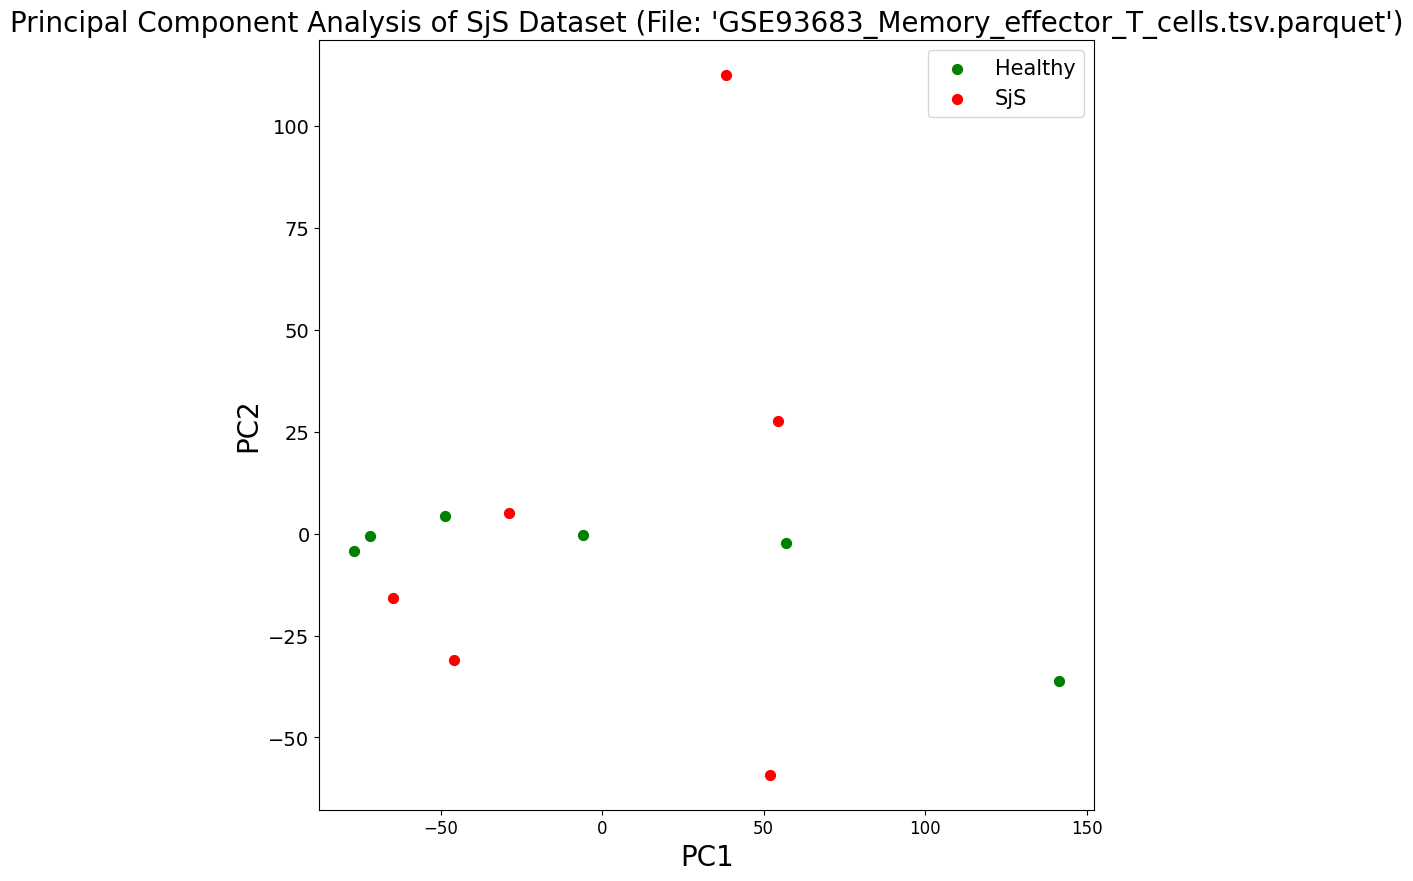

<Figure size 640x480 with 0 Axes>

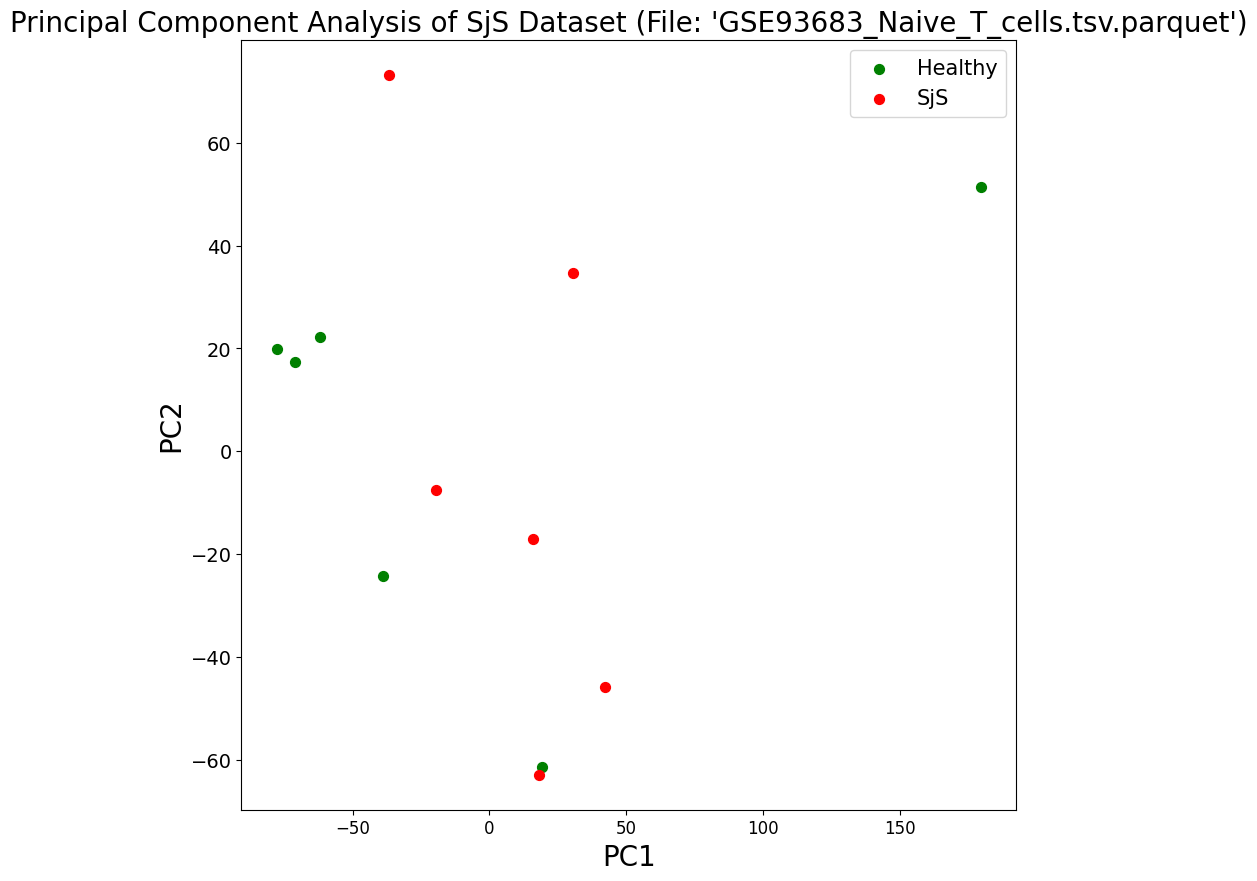

<Figure size 640x480 with 0 Axes>

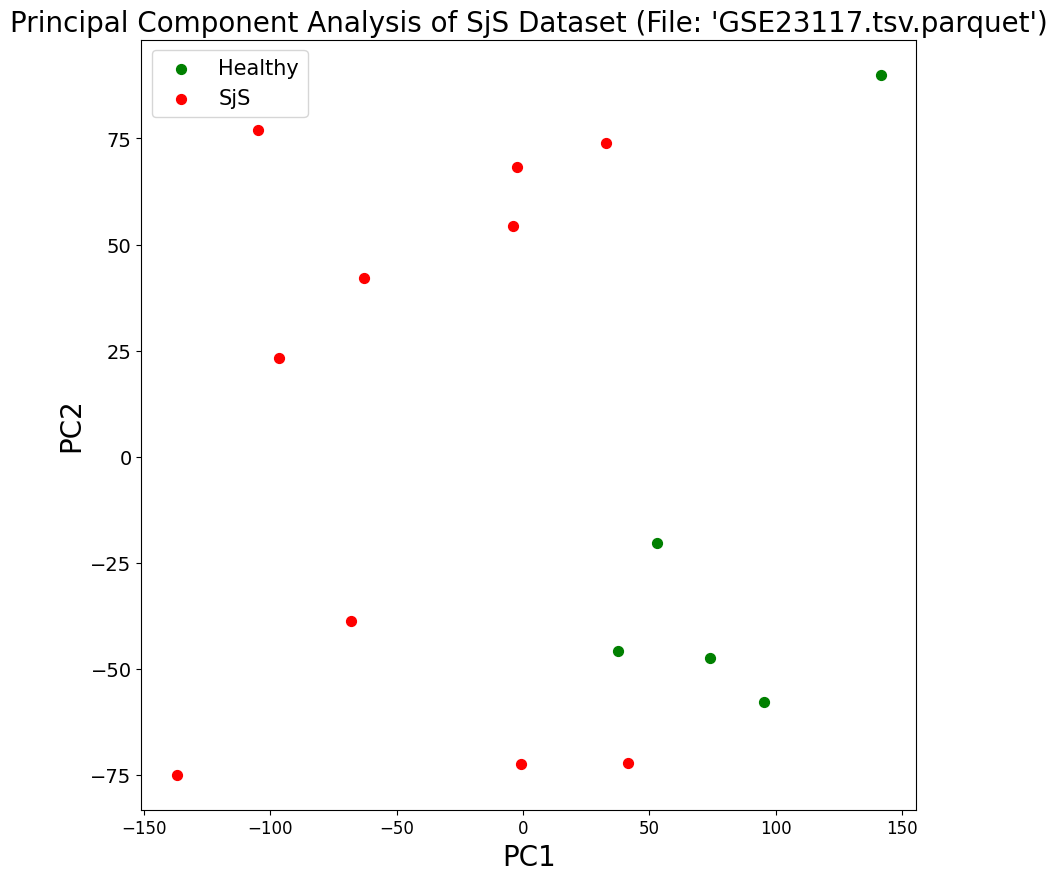

<Figure size 640x480 with 0 Axes>

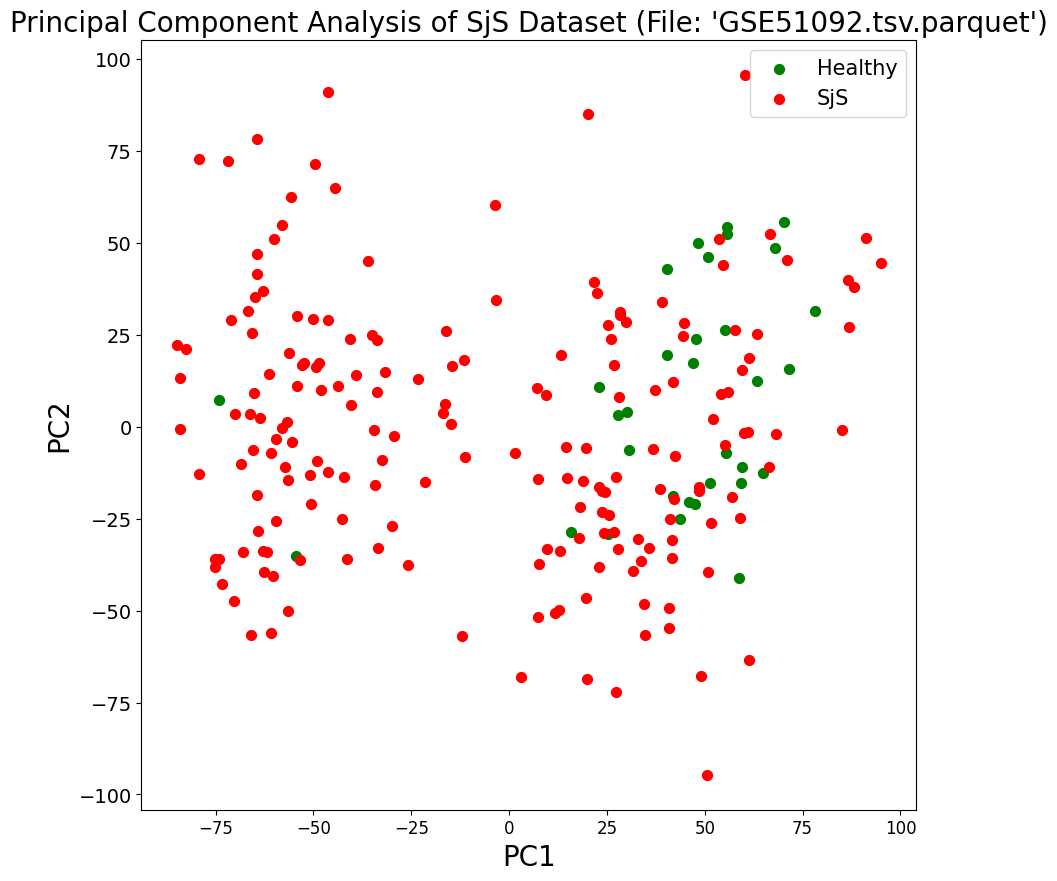

<Figure size 640x480 with 0 Axes>

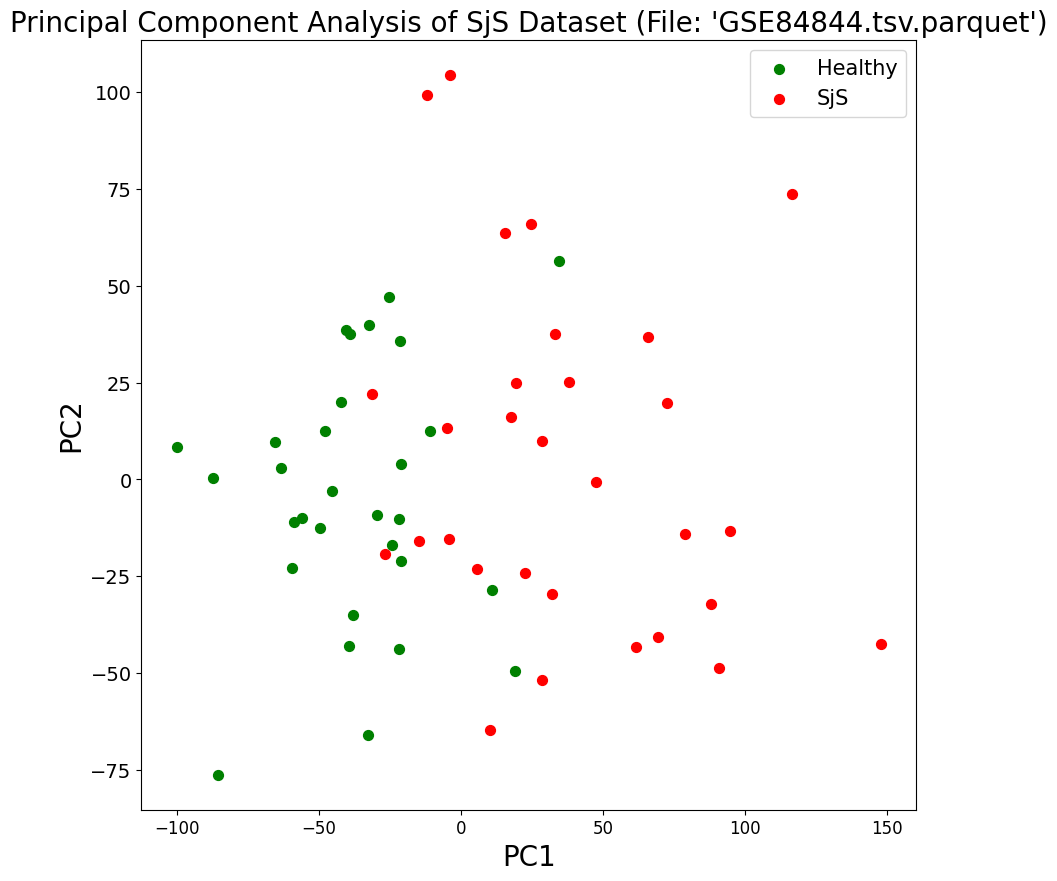

In [2]:
for condition in Condition:
    for file_path in Path(f"{files_path}/{condition.name}").glob('*.parquet'):
        file = os.path.basename(file_path)
        logging.info(f"Processing file: {file}")
        
        pca = PcaHelper(FileDataLoader(condition, file_name=file), files_path, metadata_path)
        pca.draw(
            column_that_defines_colors="Condition",
            target_colors=[
                ("Healthy", "g"),
                (condition.name, "r")
            ]
        )